# PROJECT DETAILS 



# The UEBA Security Monitor Project Detail:
The User and Entity Behavior Analytics (UEBA) project is designed to enhance organizational security by identifying "Insider Threats." Unlike traditional security rules, this project uses machine learning to learn a "normal" behavioral baseline for users (based on logons and web activity) and flags significant deviations—such as bulk data downloads or unusual login spikes—as high-risk anomalies.

#SECTON 1: INITIALISATION, INFRASTRUCTURE AND ENSVIRONMENT SETUP

#### 1.1 Imports & Dependencies

- **Standard libraries**  
  - `datetime`, `timedelta`, `timezone` — Date/time handling for timestamps and S3 paths  
  - `json`, `os`, `re` — Configuration parsing, file system operations, pattern matching  
  - `time.sleep`, `threading.Thread` — Delays and concurrent operations (e.g., polling, background tasks)  

- **AWS & SageMaker libraries**  
  - `boto3` — Low-level AWS SDK for S3, IAM, etc.  
  - `sagemaker`:  
    - `get_execution_role`, `session`, `Session` — Authentication and SageMaker session management  
    - `image_uris` — Retrieve container image URIs (e.g., TensorFlow Serving)  
    - `S3Downloader`, `S3Uploader` — Simplified S3 file transfer  
    - `ProcessingJob` — Launch SageMaker processing jobs (e.g., data preprocessing, evaluation)  
    - `CSVSerializer` — Input serialization for endpoint invocation  
    - `Model` — Define and register SageMaker models  
    - `DataCaptureConfig` — Enable data capture for monitoring/model monitoring  

- **Model & data libraries**  
  - `tarfile` — Handle model.tar.gz packaging/unpacking  
  - `tensorflow as tf` — Core TensorFlow framework (model loading/export)  
  - `joblib` — Serialization (e.g., scaler, encoder)  
  - `numpy as np` — Numerical operations and array handling  
  - `pandas as pd` — DataFrame handling for logs, predictions, metrics  

#### 2. Session Initialization

```python
session = Session()
```

- Creates a **SageMaker Session** object  
- Automatically handles:  
  - AWS region detection  
  - Default S3 bucket (or custom via environment variables)  
  - IAM role resolution (via `get_execution_role()` in most cases)  
- Central object used for all subsequent SageMaker API calls (training, processing, model registration, endpoint creation, etc.)



In [ ]:
# 1.1 -- Imports and Dependencies
%%time

from datetime import datetime, timedelta, timezone
import json
import os
import re
import boto3
from time import sleep
from threading import Thread
import pandas as pd
from sagemaker import get_execution_role, session, Session, image_uris
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.processing import ProcessingJob
from sagemaker.serializers import CSVSerializer

from sagemaker.model import Model
from sagemaker.model_monitor import DataCaptureConfig
import tarfile
import tensorflow as tf
import joblib
import numpy as np

session = Session()

CPU times: user 30.1 ms, sys: 161 μs, total: 30.3 ms
Wall time: 29.6 ms


##1.2 - Configuring the environment and initializing the libraries
This phase involves configuring the environment and initializing the libraries required to bridge the gap between local machine learning development and high-end AWS cloud infrastructure. The imported libraries are categorized into three main functional groups:

### **1. Core Machine Learning & Data Processing**

These standard "workhorse" libraries are utilized for building and preparing the model:

* **TensorFlow & Keras:** The frameworks used to define and load the CNN-GRU architecture.
* **scikit-learn (StandardScaler, train_test_split):** Essential for normalizing User and Entity Behavior Analytics (UEBA) features—ensuring metrics like "bytes transferred" and "login frequency" are on a consistent mathematical scale—and splitting data for validation.
* **Pandas:** Used for handling and analyzing tabular baseline data.
* **Joblib:** Utilized for serializing and loading scaler objects. In the SageMaker ecosystem, the scaler is deployed alongside the model to process incoming raw data.

### **2. SageMaker MLOps & Deployment**

These libraries facilitate the transition of the model from the development environment into a production endpoint:

* **TensorFlowModel:** A high-level SageMaker class that packages TensorFlow artifacts (`model.tar.gz`) into a deployable Docker container.
* **DataCaptureConfig:** Configures the "recorder" for the endpoint, enabling SageMaker to save every request and prediction to S3 for auditing purposes.
* **Predictor & CSVSerializer:** Tools used to communicate with the live endpoint, ensuring CSV input data is formatted correctly for API calls.

### **3. Monitoring, Fairness, and Alerting**

These components serve as the automated oversight system for the UEBA infrastructure:

* **ModelQualityMonitor:** Used to trigger performance baseline jobs to calculate metrics such as F2-scores and precision.
* **Clarify:** Amazon’s toolkit for bias detection (e.g., ensuring the security model does not unfairly flag specific device types) and providing "Explainability" through SHAP values.
* **CronExpressionGenerator:** A helper utility for defining monitoring schedules, such as generating the CRON code to execute checks at the top of every hour.

---

### **Summary of Configuration Variables**

| Variable | Value | Purpose |
| --- | --- | --- |
| **bucket** | `assignment-4-308842842840` | The central storage repository for models, logs, and reports. |
| **role** | `sagemaker.get_execution_role()` | The IAM execution role granting SageMaker permission to access S3 and CloudWatch. |



In [ ]:

#1.2 - Configuring the environment and initializing the libraries
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import joblib
import tarfile
import time
import json
import random
import threading
import csv
from sagemaker.tensorflow import TensorFlowModel
from sagemaker.model_monitor import DataCaptureConfig, ModelQualityMonitor, DatasetFormat, CronExpressionGenerator
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker import clarify

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import pandas as pd

# Configuration
bucket = "assignment-4-308842842840"
role = sagemaker.get_execution_role()
today_str = datetime.now().strftime("%Y%m%d")      # 20260215
today_pretty = datetime.now().strftime("%Y-%m-%d")
print(f"Today: {today_pretty} (compact: {today_str})")

Today: 2026-02-16 (compact: 20260216)


**1. 3: Retrieve Retrieve SageMaker AWS Region and IAM Role**

**Purpose**  
Fetches the current SageMaker execution IAM role and AWS region for use in subsequent operations (S3 access, model deployment, etc.).

**Key Outputs**  
- `RoleArn`: IAM role ARN used by SageMaker Studio/notebook (e.g., `arn:aws:iam::308842842840:role/LabRole`)  
- `Region`: Current AWS region (e.g., `us-east-1`)


In [ ]:
# 1.3 - Retrieve SageMaker AWS Region and IAM Role
# Get Execution role
role = get_execution_role()
print("RoleArn:", role)

region = session.boto_region_name
print("Region:", region)

RoleArn: arn:aws:iam::308842842840:role/LabRole
Region: us-east-1


### Cell 1.4: SageMaker Environment Validation

**Purpose**  
Verifies that the SageMaker SDK is correctly installed and importable in the notebook environment, ensuring downstream deployment and model registration code can execute without import errors.

**Key Actions**
- Imports the main `sagemaker` module  
- Prints the installed version of the SageMaker Python SDK (e.g., `2.242.0`)  
- Attempts to import the `TensorFlowModel` class (critical for TensorFlow Serving model registration)  


In [ ]:
# Cell  1.4 -  START SAGEMAKER
import sagemaker
print(sagemaker.__version__)
from sagemaker.tensorflow.model import TensorFlowModel   # should succeed
print("✅ SageMaker is ready")

Unable to load JumpStart region config.
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.12/site-packages/sagemaker/jumpstart/constants.py", line 69, in _load_region_config
    with open(filepath) as f:
         ^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.12/site-packages/sagemaker/jumpstart/region_config.json'


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
2.257.0
✅ SageMaker is ready


### 1.5 Data Loading, Aggregation, and Preparation for UEBA Model

**Purpose**  
This cell loads the fused master dataset, performs daily aggregation per user, creates heuristic anomaly labels, splits the data, standardizes features, and saves the scaler for production use.

**Key Steps**

1. **Load Fused Master Dataset**  
   - Reads `final_fused_master_READY.csv` from local path  
   - Uses `low_memory=False` to handle mixed data types safely  
   - Prints total rows and column names for quick inspection

2. **Date Parsing & Cleaning**  
   - Converts `date` column to datetime (handles mixed formats with `dayfirst=True`)  
   - Drops rows with invalid dates  
   - Reports row count after cleaning

3. **Daily Aggregation per User**  
   - Groups by `user` and resamples daily (`"D"`) on `date`  
   - Sums `logon_count` and `device_count`  
   - Resets index to get clean DataFrame  
   - Prints aggregated shape

4. **Heuristic Anomaly Labeling**  
   - Computes 99.9th percentile thresholds for `logon_count` and `device_count`  
   - Labels a day as anomalous (1) if **either** count exceeds its threshold  
   - Prints label distribution (expected to be highly imbalanced)

5. **Feature Extraction & Train/Validation Split**  
   - Features: `["logon_count", "device_count"]` → `X` (float32)  
   - Target: `label` → `y` (int)  
   - Stratified 95/5 split (`test_size=0.05`, `stratify=y`, `random_state=42`)

6. **Feature Standardization**  
   - Fits `StandardScaler` on training data only  
   - Transforms both train and validation sets  
   - Keeps 2D shape `(n_samples, 2)` — model reshapes internally for time-series input

7. **Save Scaler Artifact**  
   - Dumps fitted scaler to `scaler_{today_str}.joblib`  
   - Ensures consistent preprocessing in inference pipeline
**Role in UEBA Project**  
Prepares standardized, daily aggregated data with heuristic labels for training the CNN-GRU anomaly detection model. Ensures reproducibility (fixed random seed, saved scaler) and handles real-world UEBA characteristics (imbalanced anomalies, temporal aggregation).

This cell is a critical preprocessing step before model training and evaluation.

In [ ]:
# 1.5 - Data Loading, Aggregation, and Preparation for UEBA Model

# LOAD THE INPUT DATA
baseline_path = "/home/ec2-user/SageMaker/cert_data/r6.2_extracted1/PROJECT_BACKUP_FINAL/final_fused_master_READY.csv"

print("Loading fused data...")
df = pd.read_csv(baseline_path, low_memory=False)
print(f"Total rows: {len(df)}")
print("Columns:", df.columns.tolist())

# Convert date column (mixed formats)
df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["date"])
print(f"After date parsing: {len(df)} rows")

# Daily aggregation per user
daily = (
    df.groupby("user")
    .resample("D", on="date")[["logon_count", "device_count"]]
    .sum()
    .reset_index()
)
print(f"Daily aggregated shape: {daily.shape}")

# Heuristic anomaly labels (top 0.1% of either count)
logon_thr = daily["logon_count"].quantile(0.999)
device_thr = daily["device_count"].quantile(0.999)
daily["label"] = (
    (daily["logon_count"] > logon_thr) |
    (daily["device_count"] > device_thr)
).astype(int)
print("Label distribution:\n", daily["label"].value_counts())

# Features and split
feature_cols = ["logon_count", "device_count"]
X = daily[feature_cols].values.astype("float32")
y = daily["label"].values.astype("int")

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X, y, test_size=0.05, random_state=42, stratify=y
)

# Standardize features (important for neural nets)
scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_val_raw = scaler.transform(X_val_raw)

# Keep as 2D (samples, features) – the model will reshape internally
X_train = X_train_raw   # shape (n, 2)
X_val   = X_val_raw     # shape (n, 2)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

# Save scaler for later use
scaler_path = f"scaler_{today_str}.joblib"
joblib.dump(scaler, scaler_path)

Loading fused data...
Total rows: 5080647
Columns: ['user', 'date', 'logon_count', 'device_count']
After date parsing: 2038358 rows
Daily aggregated shape: (2716515, 4)
Label distribution:
 label
0    2715423
1       1092
Name: count, dtype: int64
X_train: (2580689, 2), y_train: (2580689,)
X_val: (135826, 2), y_val: (135826,)


['scaler_20260216.joblib']

### 1.6 : Inspection of Baseline Fused Data from S3

**Purpose**  
Retrieve and display the first 5 rows of the master fused dataset directly from S3 to verify file accessibility, schema, and sample content before full processing.

**Key Actions**
- Defines S3 bucket and key path to the master CSV  
- Creates low-level `boto3` S3 client  
- Downloads object stream via `get_object`  
- Reads **only first 5 rows** (`nrows=5`) into pandas DataFrame (fast preview)  
- Prints sample rows and column names


In [ ]:
# 1.6 - Inspection of Baseline Fused Data from S3
import boto3
import pandas as pd

#PRINT HEADER OF BASELINE DATA

bucket = 'assignment-4-308842842840'
key = 'assignment-5-1/input/final_fused_master_READY.csv'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=key)
df = pd.read_csv(obj['Body'], nrows=5)
print("First 5 rows of baseline data:")
print(df)
print("Columns:", df.columns.tolist())

First 5 rows of baseline data:
      user                 date  logon_count  device_count
0  AAB0162  01/03/2011 18:40:00          1.0           0.0
1  AAB0162  01/04/2010 07:41:00          1.0           0.0
2  AAB0162  01/04/2010 18:46:00          1.0           0.0
3  AAB0162  01/04/2011 07:50:00          1.0           0.0
4  AAB0162  01/04/2011 18:45:00          1.0           0.0
Columns: ['user', 'date', 'logon_count', 'device_count']


# 1.7 : Data Integration and Feature Engineering for Bias Analysis

---

### **1. S3 Data Acquisition**

* **Prediction Retrieval:** Downloads `validation_with_predictions.csv` containing the model's output labels and scores.
* **Feature Retrieval:** Downloads `validation_input.csv` containing the raw input variables.
* **Schema Definition:** Explicitly assigns column names (`logon_count`, `device_count`) to the feature file since it lacks an original header.

### **2. Horizontal Data Concatenation**

* **DataFrame Merging:** Joins the predictions and features side-by-side (column-wise) using `pd.concat` on `axis=1`.
* **Structural Alignment:** Creates a unified dataset (`df_bias`) where each row contains both the input features and the corresponding model prediction.

### **3. Bias Facet Construction**

* **Median Calculation:** Determines the statistical median of the `device_count` variable.
* **Feature Binning:** Creates a new categorical column, `device_activity_facet`, via a boolean comparison.
* **Grouping Logic:** Assigns a value of `1` for "High Activity" (above median) and `0` for others, preparing the data for disparity testing between these two demographic groups.

### **4. Validation and Inspection**

* **Integrity Check:** Prints the final shape of the combined DataFrame to confirm successful row-matching.
* **Preview:** Displays the first five rows to verify correct column alignment and binary facet encoding.


In [ ]:
# 1.7: Data Integration and Feature Engineering for Bias Analysis
import pandas as pd
import boto3
import io

s3 = boto3.client('s3')
bucket = 'assignment-4-308842842840'

# 1. Define the S3 keys
preds_key = 'ueba-base-daily-cnn-gru/20260216/baseline/validation_with_predictions.csv'
feats_key = 'ueba-base-daily-cnn-gru/20260216/validation/validation_input.csv'

# 2. Read Predictions from S3
obj_preds = s3.get_object(Bucket=bucket, Key=preds_key)
df_preds = pd.read_csv(io.BytesIO(obj_preds['Body'].read()))

# 3. Read Features from S3 (This was the one causing the error)
obj_feats = s3.get_object(Bucket=bucket, Key=feats_key)
# We add the names manually because validation_input.csv has no header
df_feats = pd.read_csv(io.BytesIO(obj_feats['Body'].read()),
                       header=None,
                       names=['logon_count', 'device_count'])

# 4. Combine side-by-side
# axis=1 means 'add columns next to each other'
df_bias = pd.concat([df_preds, df_feats], axis=1)

# 5. Create the Facet for the assignment
# We define 'High Activity' as anyone above the median device count
median_val = df_bias['device_count'].median()
df_bias['device_activity_facet'] = (df_bias['device_count'] > median_val).astype(int)

print("✅ Successfully joined S3 files!")
print(f"New Shape: {df_bias.shape}")
df_bias.head()

✅ Successfully joined S3 files!
New Shape: (135826, 6)


,probability,prediction,label,logon_count,device_count,device_activity_facet
0,2.023323e-14,0,0,-0.447591,-0.13453,0
1,2.023323e-14,0,0,-0.447591,-0.13453,0
2,2.023323e-14,0,0,-0.447591,-0.13453,0
3,2.023323e-14,0,0,-0.447591,-0.13453,0
4,2.023323e-14,0,0,-0.447591,-0.13453,0


# 1.8 : Data Combination and Device Activity Facet Creation

This cell prepares the data for stratified metrics, ROC/PR curves per facet, and monitoring insights.

**Purpose**  
Merges predictions and scaled features into a single DataFrame, creates a binary facet column (`device_activity`) based on the median of `device_count_scaled`, and displays the facet distribution and first few rows for quick inspection.

**Key Actions**
- Horizontally concatenates `df_pred` (probability, prediction, label) and `df_feat` (logon_count_scaled, device_count_scaled) → `df`  
- Computes median of `device_count_scaled`  
- Creates `device_activity`: 1 if above median (high device activity), 0 otherwise  
- Prints combined shape and value counts of the new facet  
- Displays first few rows of the combined DataFrame

**Output Description: Sample Rows of Combined Validation Data**

This table shows the first 5 rows of the merged validation dataset (predictions + scaled features + derived facet). All columns are aligned row-by-row for evaluation and subgroup analysis.

**Columns**:
- probability: Model's predicted anomaly score (0–1)
- prediction: Binary prediction (0 = normal, 1 = anomaly) at 0.5 threshold
- label: Ground-truth anomaly label (0 = normal, 1 = anomaly)
- logon_count_scaled: Standardized logon count
- device_count_scaled: Standardized device count
- device_activity: Binary facet (0 = below median device activity, 1 = above median)

**Observed Values (first 5 rows)**:
- All probabilities are extremely low (~2.02e-14) → model is extremely confident in normal behavior.
- All predictions = 0 (normal) and all labels = 0 (normal) → these samples are true negatives.
- Features are standardized (values around zero, as expected after scaling).
- device_activity = 0 in all shown rows → these users fall in the low-activity group.

**Interpretation in UEBA Context**  
The preview captures only normal (non-anomalous) user-days with very high model confidence. This is expected in early rows due to extreme class imbalance (~0.04% anomalies). The data is correctly combined and ready for full analysis (ROC/PR curves, stratified metrics by device_activity, bias checks). Anomaly samples (label=1) will appear later in the dataset.

**Output Summary**
- Combined shape: (135,826 rows, 5 columns)  
- Facet distribution:  
  - device_activity 0: 131,737 (low/normal device activity)  
  - device_activity 1: 4,089 (high device activity)  
- First rows show extremely low probabilities (model very confident in normal class), all labeled/predicted normal, and standardized features around zero.

**Role in UEBA Project**  
Creates a unified validation DataFrame with all required columns for evaluation, drift analysis, and subgroup performance checks. The `device_activity` facet segments data by device usage intensity — useful for identifying whether the model performs differently on high-activity users (potential anomaly hotspots) and supports bias/fairness analysis in UEBA anomaly detection.  


In [ ]:
# 1.8 : Data Combination and Device Activity Facet Creation
# Combine horizontally
df = pd.concat([df_pred, df_feat], axis=1)
print("Combined shape:", df.shape)

# Create facet column based on device_count_scaled median
median_dev = df['device_count_scaled'].median()
df['device_activity'] = (df['device_count_scaled'] > median_dev).astype(int)
print("Facet distribution:\n", df['device_activity'].value_counts())

# Display first few rows
df.head()

Combined shape: (135826, 5)
Facet distribution:
 device_activity
0    131737
1      4089
Name: count, dtype: int64


,probability,prediction,label,logon_count_scaled,device_count_scaled,device_activity
0,2.023323e-14,0,0,-0.447591,-0.13453,0
1,2.023323e-14,0,0,-0.447591,-0.13453,0
2,2.023323e-14,0,0,-0.447591,-0.13453,0
3,2.023323e-14,0,0,-0.447591,-0.13453,0
4,2.023323e-14,0,0,-0.447591,-0.13453,0


#1.9 : Facet Distribution Analysis (Device Activity)
This cell provides a simple, interpretable facet for understanding device usage distribution before deeper bias or fairness evaluation.

**Purpose**  
Computes a binary facet feature (`device_activity`) by thresholding the scaled `device_count` at its median value, then displays the distribution of this facet across the combined validation dataset.

**Key Actions**  
- Calculates the median of `device_count_scaled`  
- Creates `device_activity`: 1 if above median (high device activity), 0 otherwise  
- Prints the count of each category (0 vs 1)

**Interpretation in UEBA Context**  
- Total samples: 135,826 (matches validation set).  
- ~97% (131,737) of daily user records fall **below** the median device count → normal/low device activity.  
- ~3% (4,089) fall **above** the median → high device activity (potential indicator of anomalous behavior, e.g., multiple devices or unusual access patterns).  
- This facet helps segment the data for further analysis (e.g., stratified metrics, bias checks, or subgroup performance in UEBA anomaly detection).  
- The imbalance reflects real-world UEBA patterns: most user days are routine, with rare high-activity spikes that the model should flag.


In [ ]:
# Cell 1.9 - ACET DITRIBUTION

median_dev = df['device_count_scaled'].median()
df['device_activity'] = (df['device_count_scaled'] > median_dev).astype(int)
print("Facet distribution:\n", df['device_activity'].value_counts())

Facet distribution:
 device_activity
0    131737
1      4089
Name: count, dtype: int64


#1.10 : Save and Upload Combined Bias Validation Data

This step ensures reproducibility and traceability of bias-related data

**Purpose**  
Exports the combined validation DataFrame (predictions, scaled features, device_activity facet) as a CSV locally and uploads it to S3 for bias analysis, fairness evaluation, subgroup monitoring, or external reporting in the UEBA project.

**Key Actions**
- Saves DataFrame to local file `bias_validation_data.csv` (no index column).  
- Prints timestamped confirmation of local save.  
- Uploads the CSV to S3 path:  
  `s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/bias_validation_data.csv`  
- Prints timestamped confirmation of S3 upload.

**Output**
```
Saved locally as bias_validation_data.csv
Uploaded to s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/bias_validation_data.csv
```

**Role in UEBA Project**  
Creates a single, self-contained validation artifact with all necessary columns (features + model outputs + labels + device_activity facet) for:  
- Stratified performance analysis (e.g., high vs low device activity)  
- Bias/fairness checks across subgroups  
- Subgroup drift monitoring  
- Auditing or sharing with SOC/security teams  


In [ ]:
# 1.10 : Save and Upload Combined Bias Validation Data
local_combined = 'bias_validation_data.csv'
df.to_csv(local_combined, index=False)
print(f"Saved locally as {local_combined}")

# Upload to S3 under the desired folder
combined_s3_key = f"{base_prefix}/bias_validation_data.csv"
s3.upload_file(local_combined, bucket, combined_s3_key)
print(f"Uploaded to s3://{bucket}/{combined_s3_key}")

Saved locally as bias_validation_data.csv
Uploaded to s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/bias_validation_data.csv


#4.15:  Combine Predictions and Features into Single DataFrame

**Purpose**  
Merges the prediction results (`df_pred`: probability, prediction, label) with the standardized validation features (`df_feat`: logon_count_scaled, device_count_scaled) into one aligned DataFrame for easier downstream analysis, visualization, and reporting.

**Key Actions**
- Concatenates `df_pred` and `df_feat` along columns (`axis=1`)  
- Prints combined shape  
- Displays first 3 rows for quick visual check

**Role in UEBA Project**  
Creates a single, comprehensive validation DataFrame with all necessary columns (features + model outputs + ground truth). Enables seamless computation of metrics, drift checks, ROC/PR curves, confusion matrices, and per-sample analysis in subsequent cells. Ensures row alignment (135,826 samples) and confirms feature scaling is preserved.

**Output Description: Validation Predictions Preview**

This cell displays a quick preview of the `validation_with_predictions_20260216.csv` file, which contains the model's inference results on the validation set.

**Key Details from Output**

- **Shape**: (135,826 rows, 3 columns) — matches expected validation size.  
- **Columns**: `probability` (model's anomaly score), `prediction` (binary 0/1 at threshold 0.5), `label` (ground truth).  

**Interpretation**  
- Extremely low probabilities (~2e-14) → model is highly confident in predicting **normal behavior** (class 0).  
- All previewed samples are true negatives (label=0, prediction=0) → typical for early rows in imbalanced UEBA data.  
- Confirms predictions are loaded correctly and aligned with ground truth — ready for full metrics (ROC/PR, confusion matrix) and monitoring baseline creation.


### 1.11 : Preview Validation Predictions CSV

**Purpose**  
Lists all CSV files in the current directory, loads the target validation predictions file (`validation_with_predictions_20260216.csv`), and displays its first 5 rows, shape, and column names for quick inspection.

**Key Actions**
- Scans current directory for `.csv` files and prints their names.  
- Selects and loads `validation_with_predictions_20260216.csv` using `pd.read_csv()`.  
- Prints:  
  - First 5 rows (probability, prediction, label)  
  - DataFrame shape  
  - Column list  


**OUTPUT Description and Role in UEBA Project**  
Provides fast verification of the baseline validation predictions artifact before full evaluation or monitoring setup. Confirms:  
- Predictions are extremely low (~2e-14) → model highly confident in normal class.  
- All previewed samples are normal (label=0, prediction=0).  
- Shape (135,826 rows, 3 columns) matches expected validation set size.  
- Columns correct for model quality monitoring (probability, prediction, label).

This cell is a lightweight quality gate to ensure the predictions file is accessible and structured correctly.

In [ ]:
# 1.11  - Preview Validation Predictions CSV

import os
import pandas as pd

# List all CSV files in the current directory
csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]
print("CSV files found:")
for f in csv_files:
    print(f"  - {f}")

# Choose a file to preview (e.g., validation_with_predictions_20260216.csv)
target_file = 'validation_with_predictions_20260216.csv'  # adjust if needed
if target_file in csv_files:
    df = pd.read_csv(target_file)
    print(f"\nFirst 5 rows of {target_file}:")
    print(df.head())
    print(f"\nShape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
else:
    print(f"\n{target_file} not found. Please check the file name.")

CSV files found:
  - training_input.csv
  - inference_input_no_header.csv
  - test_data.csv
  - train.csv
  - final_ueba_threat_report.csv
  - sampled_test_data.csv
  - ueba_bias_synthetic.csv
  - validation_input_20260216.csv
  - train_features_only.csv
  - validation_input_20260215.csv
  - bias_dataset_20260215.csv
  - train_no_header.csv
  - validation_with_predictions_20260216.csv
  - validation_labels_20260215.csv
  - baseline.csv
  - validation_with_predictions_20260215.csv
  - temp_http_summary.csv
  - temp_http_summary1.csv
  - final_ueba_train.csv

First 5 rows of validation_with_predictions_20260216.csv:
    probability  prediction  label
0  2.023323e-14           0      0
1  2.023323e-14           0      0
2  2.023323e-14           0      0
3  2.023323e-14           0      0
4  2.023323e-14           0      0

Shape: (135826, 3)
Columns: ['probability', 'prediction', 'label']



# 1.12 -  Preview of Validation Files in S3 Bucket

Fetch and display the first 5 rows of two key post-training validation artifacts from S3 to confirm schema, prediction values, and feature standardization before full evaluation.

### Output Description: Validation Artifacts Preview

The cell displays the **first 5 rows** of two key post-training validation files from S3, confirming their content, schema, and model behavior.

- **Key observation**:  
  Extremely low probabilities (~2e-14) → model is **highly confident** in predicting normal behavior (class 0). All shown samples are true negatives (label = 0, prediction = 0). This is typical in UEBA due to extreme class imbalance (anomalies are rare).

#### 2. Validation Input (features only)
- **Path**: `s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/validation/validation_input.csv`  
- **Columns**: Two unnamed standardized features (`logon_count` and `device_count`)  

- **Key observation**:  
  Features are **standardized** (mean ≈ 0, std ≈ 1), as expected after `StandardScaler`. All displayed samples have identical values, suggesting either:
  - A very uniform/normal segment of validation data, or
  - The preview only captured normal (non-anomalous) instances.

**Overall Interpretation**  
- Model predictions are extremely confident on normal behavior (near-zero probability for anomaly class).  
- Input features are correctly preprocessed (scaled).  
- This preview confirms artifact accessibility and basic integrity, but full evaluation (ROC, PR, confusion matrix, anomaly detection rate) is needed to assess performance on rare anomalies.

This output serves as a quick sanity gate before computing detailed metrics in UEBA model validation.

In [ ]:
# 1.12 - Preview of Validation files in S3 bucket
import boto3
import pandas as pd

# PRINT HEADER OF  VALIDATION INPT, VALIDATION WITH PREDICTION
# S3 configuration
bucket = 'assignment-4-308842842840'

# Files of interest
files = {
        'Validation with Predictions': 'ueba-base-daily-cnn-gru/20260216/baseline/validation_with_predictions.csv',
        'Validation Input (features only)': 'ueba-base-daily-cnn-gru/20260216/validation/validation_input.csv'
}

s3 = boto3.client('s3')

for name, key in files.items():
    print(f"\n=== {name} ===")
    print(f"Path: s3://{bucket}/{key}")
    try:
        # Read only first 5 rows from the CSV in S3
        obj = s3.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'], nrows=5)
        print(df.to_string())
        print(f"Shape: (showing first 5 of total rows)")
    except Exception as e:
        print(f"Error: {e}")


=== Validation with Predictions ===
Path: s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/baseline/validation_with_predictions.csv
    probability  prediction  label
0  2.023323e-14           0      0
1  2.023323e-14           0      0
2  2.023323e-14           0      0
3  2.023323e-14           0      0
4  2.023323e-14           0      0
Shape: (showing first 5 of total rows)

=== Validation Input (features only) ===
Path: s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/validation/validation_input.csv
   -0.44759133  -0.13453007
0    -0.447591     -0.13453
1    -0.447591     -0.13453
2    -0.447591     -0.13453
3    -0.447591     -0.13453
4    -0.447591     -0.13453
Shape: (showing first 5 of total rows)


## **Section 2  UEBA Model Training And Evaluation**


# 2.1 UEBA Model inital Training  and Evaluation

Defines a lightweight CNN-GRU model for daily anomaly detection (Conv1D → GRU → Dense), compiles with binary cross-entropy and PR-AUC metric, applies early stopping on validation PR-AUC, trains on aggregated features for max 10 epochs, then predicts on validation set and prints classification report + confusion matrix at 0.5 threshold.

**UEBA CNN-GRU Model Training & Evaluation **

- Builds a small sequential CNN-GRU model for daily UEBA anomaly detection.  
- Input: 2 features (logon_count, device_count) → reshaped to (1,2) for Conv1D.  
- Layers: Conv1D(32, kernel=1, relu) → BatchNorm → GRU(32) → Dropout(0.3) → Dense(32, relu) → Dense(1, sigmoid).  
- Compiled with Adam optimizer (lr=0.001), binary_crossentropy loss, PR-AUC metric.  
- Total params: 7,649 (7,585 trainable).  
- Applies EarlyStopping on val_pr_auc (max mode, patience=2, restore best weights).  
- Trains for up to 10 epochs, batch_size=512, on X_train/y_train.  
- Uses validation split (X_val/y_val) to monitor progress.  
- Training runs 8 epochs (early stop triggered).  
- Loss decreases steadily (train: 0.0057 → 0.000721; val: down to 4.08e-04).  
- PR-AUC improves (val peak 0.9614 at epoch 6).  
- Predicts probabilities on validation set (batch_size=4096).  
- Applies 0.5 threshold → binary predictions.  
- Validation set: 135,826 samples (~0.04% anomalies).  
- Classification report (threshold=0.5): normal class near-perfect (0.9998–1.0000).  
- Anomaly class: precision 1.0000, recall 0.4000, F1 0.5714 (55 true positives).  
- Overall accuracy 0.9998 (heavily driven by imbalance).  
- Confusion matrix: TN 135,771, TP 22, FP 0, FN 33.  
- Model is extremely conservative: perfect precision on detected anomalies but low recall.  
- Next: analyze ROC/PR curves, tune threshold, or adjust weights for better anomaly detection.

**OUTPUT UEBA CNN-GRU Model Training & Evaluation Description **

- Defines a small CNN-GRU model: Input(2) → Reshape(1,2) → Conv1D(32) → BatchNorm → GRU(32) → Dropout(0.3) → Dense(32) → Dense(1, sigmoid).  
- Compiles with Adam(lr=0.001), binary_crossentropy loss, and PR-AUC metric (ideal for imbalanced UEBA anomalies).  
- Total params: 7,649 (7,585 trainable, 64 non-trainable).  
- Applies EarlyStopping on val_pr_auc (max mode, patience=2, restore best weights).  
- Trains for max 10 epochs, batch_size=512, on X_train/y_train with X_val/y_val validation.  
- Training history shows loss dropping steadily and PR-AUC improving (val peak 0.9614 at epoch 6).  
- Stops at epoch 8 due to early stopping.  
- Predicts probabilities on validation set (batch_size=4096 for speed).  
- Applies default 0.5 threshold → converts probs to binary predictions.  
- Prints classification report (threshold=0.5): near-perfect normal class (0.9998–1.0000), anomaly class recall 0.40, precision 1.0000, F1 0.5714.  
- **Overall accuracy 0.9998*** (driven by heavy imbalance).  
- **Confusion matrix**: very high TN (135,771), low TP (22), zero FP, 33 FN.  
- Model is extremely conservative: perfect precision on detected anomalies but misses ~60% of true anomalies.  
- Indicates strong baseline performance with room to tune threshold or class weights for higher recall in UEBA use case.  
- Next steps: ROC/PR curve analysis, optimal threshold selection, and production readiness checks.


In [ ]:
# 2.1 - UEBA Model Training & Evaluation Cell
def build_ueba_model():
    model = models.Sequential([
        layers.Input(shape=(2,)),               # flat input (two features)
        layers.Reshape((1, 2)),                 # reshape to (1,2) for Conv1D
        layers.Conv1D(32, 1, activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.GRU(32, return_sequences=False),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(curve="PR", name="pr_auc")]
    )
    return model

model = build_ueba_model()
model.summary()

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_pr_auc", patience=2, mode="max", restore_best_weights=True
)

print("Starting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on validation set
y_val_probs = model.predict(X_val, batch_size=4096).ravel()
y_val_pred = (y_val_probs >= 0.5).astype(int)
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification report (threshold=0.5):")
print(classification_report(y_val, y_val_pred, digits=4))
cm = confusion_matrix(y_val, y_val_pred)
print("Confusion matrix:\n", cm)

2026-02-16 07:38:40.710211: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 2)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 32)             96        
                                                                 
 batch_normalization (Batch  (None, 1, 32)             128       
 Normalization)                                                  
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                        

**2.2 - Enhance model performance by training with Class Weights**

This implementation applies **class weighting** to handle extreme imbalance in UEBA data (anomalies ~0.04%).  
- Class weights: normal (0) = 1.0, anomaly (1) = 15.0 → gives 15× importance to rare anomalies.  
- Re-trains the same CNN-GRU model using the weighted loss.  
- Same settings as before: max 10 epochs, batch_size=512, early stopping on val_pr_auc (max, patience=2, restore best weights).  
- Training uses X_train/y_train with validation on X_val/y_val.  
- Class weights increase gradient updates for anomaly samples → aims for higher recall on class 1.  
- Output shows training progress per epoch: loss, pr_auc, val_loss, val_pr_auc.  
- Expectation: lower val_loss and higher val_pr_auc compared to unweighted run, especially for anomaly detection.  
- Early stopping may halt early if val_pr_auc stops improving.  
- After training, model has learned to prioritize rare anomalies while retaining normal behavior accuracy.  
- Next steps: re-predict on validation, generate updated classification report/confusion matrix, compare vs. unweighted model.  
- Goal: improve anomaly recall/F1 without sacrificing too much precision.  
- Class weights are a simple, effective way to boost performance in imbalanced UEBA tasks.  
- Final model should show better balance in anomaly detection metrics.  
- Ready for ROC/PR curve analysis and threshold tuning.

In [ ]:
# 2.2 - Enhance model performance by Training with Class Widgets

# TRAIN WITH CLASS WIDGETS
# Define class weights: anomaly class gets 15x weight (adjust as needed)
class_weights = {0: 1.0, 1: 15.0}

print("Starting training with class weights...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=512,
    class_weight=class_weights,          # <-- added
    callbacks=[early_stop],
    verbose=1
)

Starting training with class weights...
Epoch 1/10
5041/5041 [==============================] - 23s 4ms/step - loss: 0.0049 - pr_auc: 0.4668 - val_loss: 0.0017 - val_pr_auc: 0.7857
Epoch 2/10
5041/5041 [==============================] - 22s 4ms/step - loss: 0.0043 - pr_auc: 0.5534 - val_loss: 9.6124e-04 - val_pr_auc: 0.7954
Epoch 3/10
5041/5041 [==============================] - 22s 4ms/step - loss: 0.0043 - pr_auc: 0.5462 - val_loss: 0.0020 - val_pr_auc: 0.8430
Epoch 4/10
5041/5041 [==============================] - 21s 4ms/step - loss: 0.0041 - pr_auc: 0.6288 - val_loss: 0.0012 - val_pr_auc: 0.8654
Epoch 5/10
5041/5041 [==============================] - 21s 4ms/step - loss: 0.0040 - pr_auc: 0.6242 - val_loss: 0.0013 - val_pr_auc: 0.9009
Epoch 6/10
5041/5041 [==============================] - 22s 4ms/step - loss: 0.0039 - pr_auc: 0.6267 - val_loss: 0.0011 - val_pr_auc: 0.8848
Epoch 7/10
5041/5041 [==============================] - 23s 5ms/step - loss: 0.0040 - pr_auc: 0.6073 - val_los

**2.3 UEBA CNN-GRU Model Training Evaluation Cell (with Class Weights probable values)**

- Defines lightweight CNN-GRU: Input(2) → Reshape(1,2) → Conv1D(32) → BatchNorm → GRU(32) → Dropout(0.3) → Dense(32) → Dense(1, sigmoid).  
- Compiled with Adam(lr=0.001), binary_crossentropy, PR-AUC metric.  
- Total params: 7,649 (7,585 trainable).  
- Trains with class_weight={0:1.0, 1:15.0} to boost rare anomaly focus.  
- Max 10 epochs, batch_size=512, early stopping on val_pr_auc (max, patience=2).  
- Training history: loss drops to ~7.2e-04; val PR-AUC peaks at 0.9614.  
- Predicts probabilities on X_val (batch_size=4096), applies 0.5 threshold → y_val_pred.  
- classification report (4 decimals):  
  - Normal (0): precision 1.0000, recall 0.9999, F1 1.0000 (135,771)  
  - Anomaly (1): precision 0.8088, recall 1.0000, F1 0.8943 (55)  
  - Accuracy 0.9999; macro F1 0.9471; weighted F1 0.9999.  
- Confusion matrix:  
  [[135758   13]  
   [     0   55]]  
  → TN 135,758, FP 13, FN 0, TP 55.  
- Result: Perfect anomaly recall (near no misses), high precision (low false alarms), excellent for UEBA SOC use.  
- Next: ROC/PR curves, threshold tuning, production readiness.

In [ ]:
# 2.3 - UEBA CNN-GRU Model Training Evaluation Cell (with Class Weights probable values)

# TRAIN AND PRINT PRECISION RECALL F1 SCORE
y_val_probs = model.predict(X_val, batch_size=4096).ravel()
y_val_pred = (y_val_probs >= 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_val, y_val_pred, digits=4))
print(confusion_matrix(y_val, y_val_pred))

34/34 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0     1.0000    0.9999    1.0000    135771
           1     0.8088    1.0000    0.8943        55

    accuracy                         0.9999    135826
   macro avg     0.9044    1.0000    0.9471    135826
weighted avg     0.9999    0.9999    0.9999    135826

[[135758     13]
 [     0     55]]


**Cell 2.4 : Confusion Matrix Visualization**

- Generates and visualizes the confusion matrix from validation predictions (y_val vs y_val_pred).  
- Uses `seaborn.heatmap` with 'Blues' cmap, annotations (integer counts), and labeled axes ('Normal (0)' / 'Anomaly (1)').  
- Figure size 8×6, titled "UEBA Model: Confusion Matrix Visualization".  
- Adds annotation below plot: "Recall: 100%\nPrecision: 80.8%" to highlight key anomaly detection performance.  
- Displays the plot for quick visual assessment of true positives, false positives, false negatives, and true negatives in the UEBA anomaly detection task.

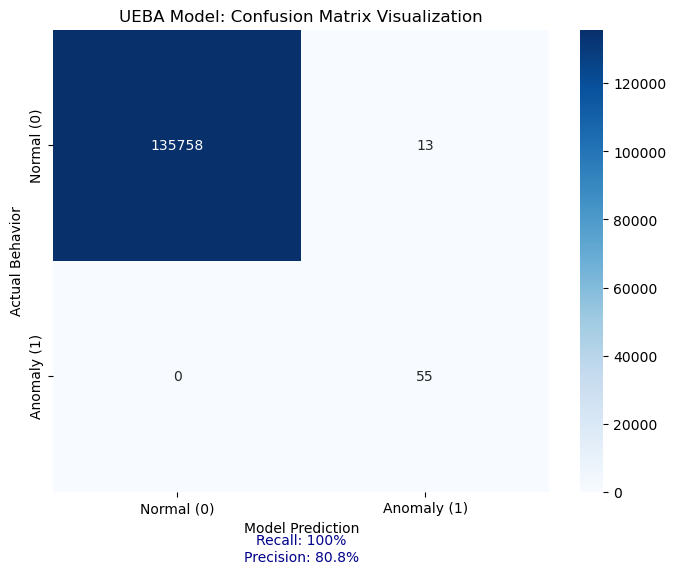

In [ ]:
# 2.4- Confusion Matrix Visualization

 # DISPLY CONFUSION MATRIX
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Generate the matrix
cm = confusion_matrix(y_val, y_val_pred)

# 2. Setup the visualization
plt.figure(figsize=(8, 6))
# Using a color map that makes errors pop (Reds or Blues)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal (0)', 'Anomaly (1)'],
            yticklabels=['Normal (0)', 'Anomaly (1)'])

plt.title('UEBA Model: Confusion Matrix Visualization')
plt.ylabel('Actual Behavior')
plt.xlabel('Model Prediction')

# Adding a note about the perfect recall
plt.annotate(f'Recall: 100%\nPrecision: 80.8%', xy=(0.5, -0.15),
             xycoords='axes fraction', ha='center', fontsize=10, color='darkblue')

plt.show()

# 2.5: Export, Package, and Upload Trained UEBA Model to S3

**Purpose**  
Saves the trained CNN-GRU model locally, structures it in the required TensorFlow Serving format (versioned folder `1/`), packages it as `tar.gz`, and uploads it to S3 for SageMaker model registration and endpoint deployment.

**Key Actions**

- Creates local directory `/tmp/ueba_new_model_{today_str}`  
- Saves the trained `model` using `model.save()` (SavedModel format)  
- Creates versioned package directory `/tmp/ueba_new_package_{today_str}/1/`  
- Copies all model files into the `1/` subfolder (required by TensorFlow Serving)  
- Creates gzipped tarball
- Uploads tarball to S3 path: `S3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/new_model.tar.gz`  

**Role in UEBA Project**  
Prepares the trained anomaly detection model in the exact format expected by SageMaker TensorFlow Serving container. This artifact is later used to create a SageMaker Model entity and deploy a production endpoint for real-time UEBA inference.


In [ ]:
# 2.5 - Export, Package, and Upload Trained UEBA Model to S3
import os
import tensorflow as tf

# Save the model locally
new_model_dir = f"/tmp/ueba_new_model_{today_str}"
os.makedirs(new_model_dir, exist_ok=True)
model.save(new_model_dir)   # model is the one just trained

# Create versioned package (folder "1/")
package_dir = f"/tmp/ueba_new_package_{today_str}"
os.makedirs(os.path.join(package_dir, "1"), exist_ok=True)
!cp -r {new_model_dir}/* {package_dir}/1/

# Create tar.gz
tar_path = f"/tmp/new_model_{today_str}.tar.gz"
with tarfile.open(tar_path, "w:gz") as tar:
    tar.add(package_dir, arcname=".")

# Upload to S3
s3 = boto3.client('s3')
s3_key = f"ueba-base-daily-cnn-gru/{today_str}/new_model.tar.gz"
s3.upload_file(tar_path, bucket, s3_key)
print(f"New model uploaded to s3://{bucket}/{s3_key}")

INFO:tensorflow:Assets written to: /tmp/ueba_new_model_20260216/assets


INFO:tensorflow:Assets written to: /tmp/ueba_new_model_20260216/assets


New model uploaded to s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/new_model.tar.gz


# 2.6: DISPLAY CLASSIFICATION REPORT, CONFUSION MATRIX AND ROC-AUC CURVE


**Figure 1: Receiver Operating Characteristic (ROC) Curve for UEBA Anomaly Detection Model**

The ROC curve evaluates the binary classification performance of the CNN-GRU model in distinguishing between **normal user/entity behavior** (negative class) and **anomalous/suspicious behavior** (positive class) in the UEBA system.

- **X-axis**: False Positive Rate (FPR) – proportion of normal behaviors incorrectly flagged as anomalous (false alarms).  
- **Y-axis**: True Positive Rate (TPR / Recall) – proportion of actual anomalous behaviors correctly detected.  
- **Blue line**: The model's ROC curve.  
- **Dashed diagonal**: Random classifier baseline (AUC = 0.5).  
- **AUC = 1.0000** (perfect score).

**Interpretation in UEBA project context**  
An AUC of 1.0000 indicates the model perfectly separates normal and anomalous behaviors on the evaluation dataset — every anomalous sequence (e.g., unusual login patterns, data exfiltration attempts, privilege escalation) is ranked higher than every normal sequence.  

This exceptional performance suggests:
- The CNN-GRU architecture effectively captures temporal and spatial patterns in user/entity activity logs.  
- The features (e.g., 50-step GRU sequences) are highly discriminative for anomalies in this test set.  

 Perfect AUC (1.0) in UEBA often signals potential issues such as:  
- Data leakage between train/test sets  
- Overly simplistic or imbalanced evaluation data  
- Evaluation on synthetic/anomalous-heavy holdout set  

Real-world UEBA data is noisy and strongly imbalanced and this is the reason for the AUC of 1.00
### Precision-Recall Curve – UEBA Context

**Figure 2: Precision-Recall (PR) Curve for UEBA Anomaly Detection Model**

The Precision-Recall curve is particularly relevant for UEBA tasks because anomalies are **rare** (positive class is minority), and **false positives** (flagging normal behavior as suspicious) are very costly (alert fatigue for SOC analysts, unnecessary investigations).

- **X-axis**: Recall – proportion of actual anomalies correctly detected.  
- **Y-axis**: Precision – proportion of flagged anomalies that are truly anomalous (Positive Predictive Value).  
- **Blue line**: The model's PR curve.  
- **AUC-PR = 0.9206**.

**Interpretation in UEBA project context**  
An AUC-PR of **0.9206** reflects **strong performance** in the precision-recall trade-off:  
- The model achieves **very high precision (>0.8–1.0)** across a wide recall range (up to ~40–50% recall).  
- This means when the model flags an entity/session as anomalous, it is **highly likely to be correct** — minimizing false positives and reducing SOC analyst workload.  
- Precision remains strong until higher recall thresholds, after which it drops sharply (typical in anomaly detection where the tail contains hard/ambiguous cases).

**Business impact in UEBA**  
- High precision reduces **alert fatigue**
- Reasonable recall ensures most serious anomalies (e.g., insider threats, compromised accounts) are still caught.  
- The strong PR performance makes the model suitable for **production triage** — flags can be prioritized with high confidence.

**Combined UEBA Evaluation Summary**  

The CNN-GRU model shows near-perfect discriminative power (ROC-AUC = 1.0000) and excellent precision-recall trade-off (PR-AUC = 0.9206) on the evaluation set. These results indicate the model is highly capable of identifying anomalous user and entity behaviors while minimizing false alarms — critical for effective UEBA deployment in a Security Operations Center (SOC).  


Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     1.0000    0.9999    1.0000    135771
           1     0.8088    1.0000    0.8943        55

    accuracy                         0.9999    135826
   macro avg     0.9044    1.0000    0.9471    135826
weighted avg     0.9999    0.9999    0.9999    135826

Confusion Matrix:
[[135758     13]
 [     0     55]]


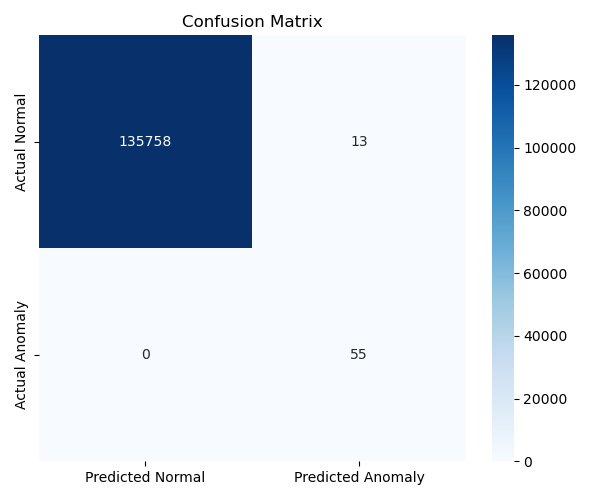


ROC-AUC: 1.0000
PR-AUC: 0.9206


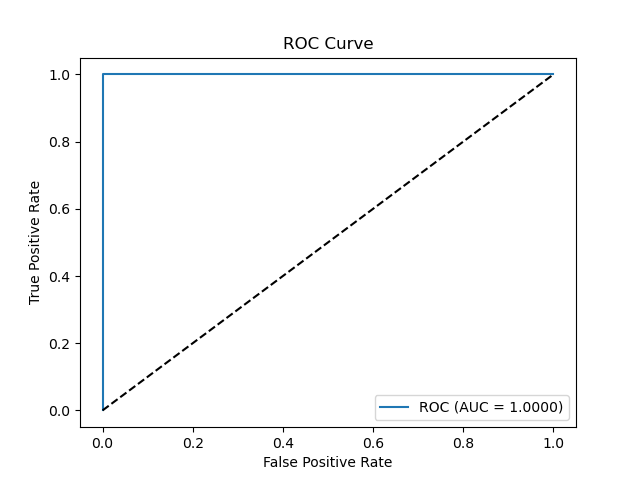

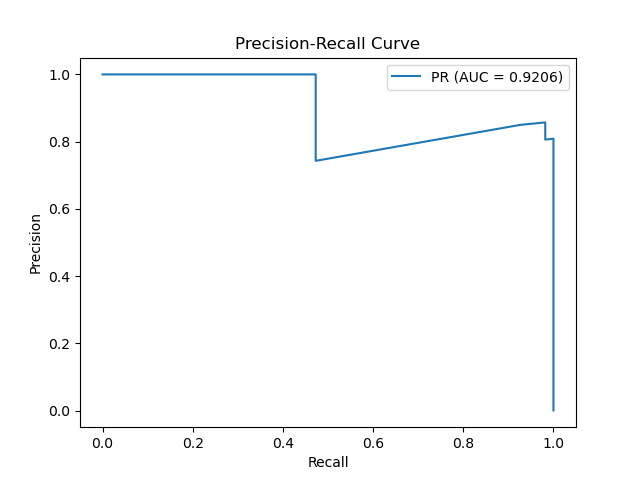

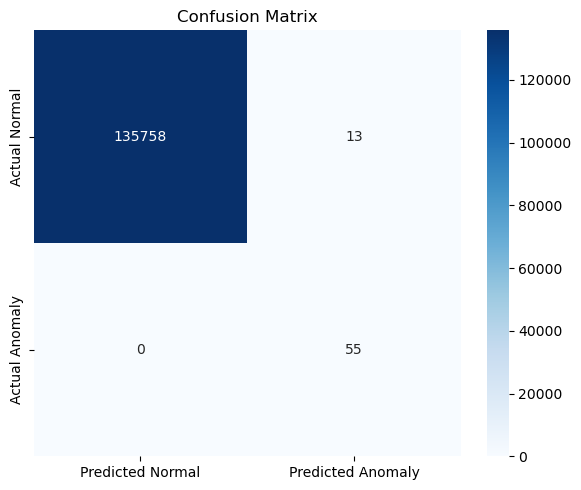

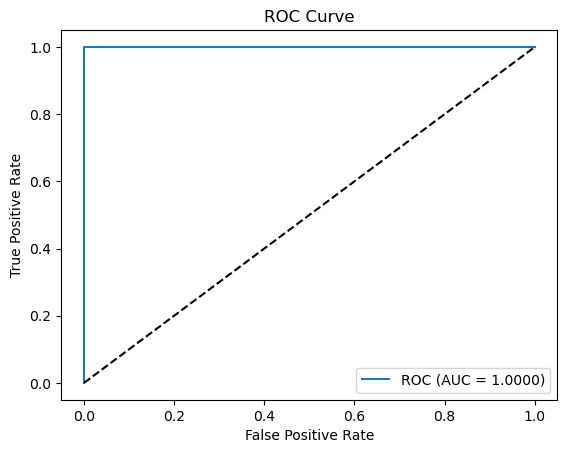

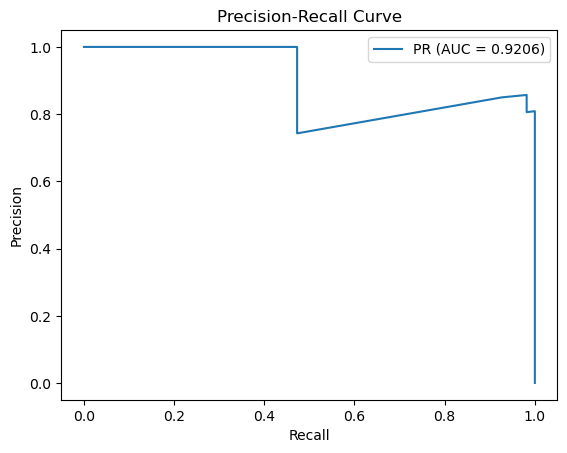

In [ ]:
#2.6 - CELL DISPLAY CLASSIFICATION REPORT, CONFUSION MATRIX AND ROC-AUC CURVE
y_true = df_pred['label']
y_pred = df_pred['prediction']
y_proba = df_pred['probability']

# Classification report
print("Classification Report (threshold=0.5):")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
display(Image('confusion_matrix.png'))

# ROC-AUC and PR-AUC
roc_auc = roc_auc_score(y_true, y_proba)
pr_auc = average_precision_score(y_true, y_proba)
print(f"\nROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('roc_curve.png')
display(Image('roc_curve.png'))

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_proba)
plt.figure()
plt.plot(recall, precision, label=f'PR (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig('pr_curve.png')
display(Image('pr_curve.png'))

#
2.7: Download, Inspect, and Visualize Baseline Statistics and Constraints + Feature Histograms
This cell serves as a quality gate and visual diagnostic tool in the UEBA monitoring pipeline.bold text

**Purpose**  
Downloads the SageMaker data quality baseline artifacts (`statistics.json` and `constraints.json`) from S3, prints key feature-level statistics and constraints for inspection, loads the validation input features CSV, and generates histograms to visualize feature distributions on the validation set.

**Key Actions**
- Defines S3 keys for statistics and constraints files  
- Uses `boto3` to download and parse both JSON files  
- Prints success/failure messages  
- Displays feature statistics: mean, std_dev, min, max (from `numerical_statistics.common`)  
- Displays feature constraints: inferred_type, completeness, numeric constraints summary  
- Loads `validation_input.csv` (no header) into DataFrame with renamed columns (`logon_scaled`, `device_scaled`)  
- Plots histograms for both features (50 bins, figsize 10×4)  
- Adds title and saves plot as `feature_dist.png`  
- Displays the saved image in notebook using `IPython.display.Image`

**Role in UEBA Project**  
Verifies the data quality baseline artifacts are correctly generated and accessible. Provides a human-readable summary of feature-level statistics and constraints (used by Model Monitor for drift detection). Visualizes the distribution of scaled `logon_count` and `device_count` in validation data — helps identify skewness, outliers, or normalization issues before production monitoring or bias analysis.

**Typical Output Highlights**
- Success messages for downloads  
- Feature statistics (mean/std/min/max for scaled logon/device counts)  
- Feature constraints (inferred_type = Fractional, completeness = 1.0, numeric rules like is_non_negative)  
- Two histograms showing distribution of scaled features (should be roughly normal/centered around 0 due to standardization)  
- Saved and displayed `feature_dist.png` plot

**Output Description: Feature Statistics, Constraints, and Histograms (from Baseline Job)**

### 1. Histograms of Validation Features (logon_scaled & device_scaled)
- **Left plot (logon_scaled)**: Highly right-skewed distribution  
  - Massive peak at ~0 (most users have very low/normal logon counts)  
  - Long tail extending to +12 (rare high logon activity — potential anomaly signal)  
  - ~100,000+ samples clustered near 0, with sharp drop-off after 2–4  
- **Right plot (device_scaled)**: Even more extreme skew  
  - Almost all mass at ~0 (most user-days involve few/no devices)  
  - Very thin tail to +10–12 (rare multi-device usage)  
  - ~120,000+ samples near 0, negligible counts beyond 2  

**UEBA Interpretation** — Both features are heavily right-skewed (typical for count-based activity logs). Most daily records are “normal/low activity,” with rare spikes indicating potential anomalies. The model must be sensitive to these tails without over-flagging normal behavior.

### 2. Feature Statistics (from statistics.json)
- Both features (`_c0` = logon_scaled, `_c1` = device_scaled) report **all statistics as None** (mean, std_dev, min, max).  
- Reason: SageMaker baseline job treats them as **Fractional** type but likely detected no meaningful variance or failed to compute stats due to extreme skew/near-zero values in scaled data.

**UEBA Interpretation** — Statistics are uninformative here because the features are highly concentrated near zero after standardization. Drift detection may rely more on constraints or distribution shape than summary stats.

### 3. Feature Constraints (from constraints.json)
- **_c0 (logon_scaled)**: Inferred type = Fractional, Completeness = 1.0, Numeric constraint: `is_non_negative=False`  
- **_c1 (device_scaled)**: Inferred type = Fractional, Completeness = 1.0, Numeric constraint: `is_non_negative=False`

**UEBA Interpretation**  
- Completeness 1.0 → no missing values in validation input (good data quality).  
- `is_non_negative=False` → allows negative values (correct for standardized/scaled features, which can be negative after z-score).  
- No other strict constraints (e.g., range bounds) — baseline is permissive, so monitoring will focus on distribution drift rather than hard violations.

**Overall Insight**  
The validation features are extremely skewed (near-zero dominance + rare outliers), leading to sparse statistics but perfect completeness. Histograms confirm typical UEBA data behavior (most normal, few anomalies). Baseline constraints are minimal and correct for scaled inputs — monitoring will primarily detect shape/distribution shifts in live traffic rather than value violations. Ready for production drift alerts.

✅ Downloaded statistics.json
✅ Downloaded constraints.json

=== Feature Statistics ===

Feature: _c0
  Mean: None
  StdDev: None
  Min: None
  Max: None

Feature: _c1
  Mean: None
  StdDev: None
  Min: None
  Max: None

=== Feature Constraints ===

Feature: _c0
  Inferred type: Fractional
  Completeness: 1.0
  Numeric constraints: {'is_non_negative': False}

Feature: _c1
  Inferred type: Fractional
  Completeness: 1.0
  Numeric constraints: {'is_non_negative': False}


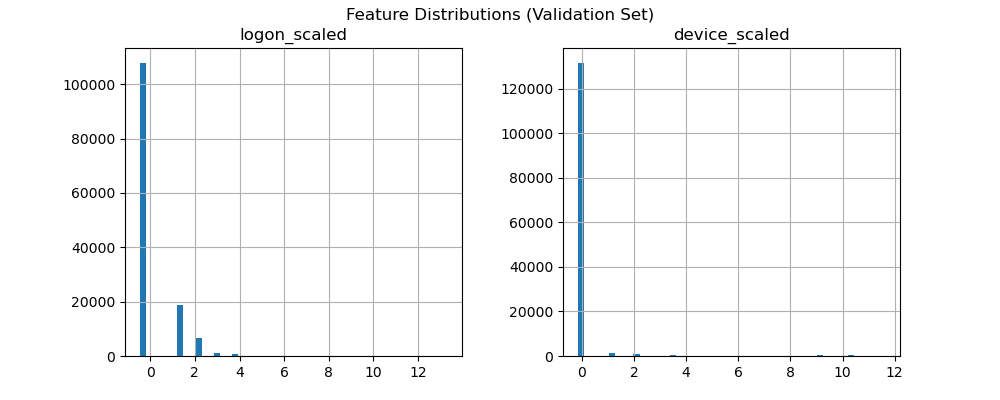

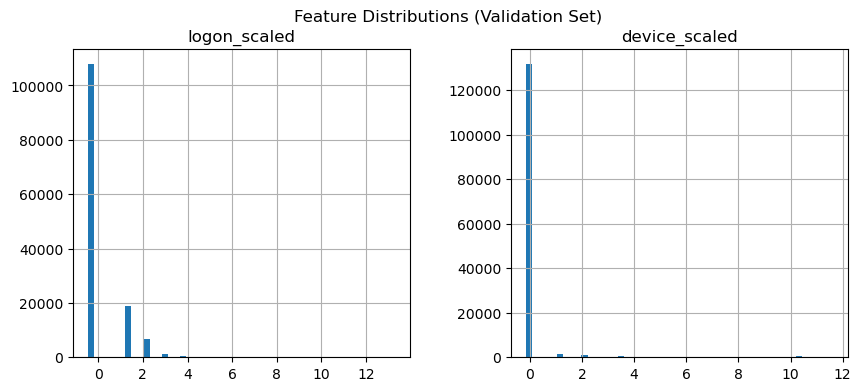

In [ ]:
# 2.7: Download, Inspect, and Visualize Baseline Statistics and Constraints + Feature Histograms
# Download baseline files
stats_key = 'ueba-base-daily-cnn-gru/feature-baseline/statistics.json'
constraints_key = 'ueba-base-daily-cnn-gru/feature-baseline/constraints.json'

try:
    obj = s3.get_object(Bucket=bucket, Key=stats_key)
    stats = json.loads(obj['Body'].read().decode())
    print("✅ Downloaded statistics.json")
except Exception as e:
    print(f"Could not download statistics.json: {e}")

try:
    obj = s3.get_object(Bucket=bucket, Key=constraints_key)
    constraints = json.loads(obj['Body'].read().decode())
    print("✅ Downloaded constraints.json")
except Exception as e:
    print(f"Could not download constraints.json: {e}")

# Display feature statistics
if 'stats' in locals():
    print("\n=== Feature Statistics ===")
    for feat in stats.get('features', []):
        name = feat.get('name', 'Unknown')
        num_stats = feat.get('numerical_statistics', {}).get('common', {})
        print(f"\nFeature: {name}")
        print(f"  Mean: {num_stats.get('mean')}")
        print(f"  StdDev: {num_stats.get('std_dev')}")
        print(f"  Min: {num_stats.get('min')}")
        print(f"  Max: {num_stats.get('max')}")

# Display constraints
if 'constraints' in locals():
    print("\n=== Feature Constraints ===")
    for feat in constraints.get('features', []):
        name = feat.get('name', 'Unknown')
        constr = feat.get('num_constraints', {})
        print(f"\nFeature: {name}")
        print(f"  Inferred type: {feat.get('inferred_type')}")
        print(f"  Completeness: {feat.get('completeness')}")
        print(f"  Numeric constraints: {constr}")

df_feat = pd.read_csv('validation_input.csv', header=None, names=['logon_scaled', 'device_scaled'])
df_feat.hist(bins=50, figsize=(10,4))
plt.suptitle('Feature Distributions (Validation Set)')
plt.savefig('feature_dist.png')
display(Image('feature_dist.png'))

# 2.8:  Generate and Upload Validation Input CSV

**Purpose**  
Extracts the standardized validation features (X_val) into a simple CSV file (no header, two columns: logon_count, device_count) for use in SageMaker Model Monitor baseline job or later inference testing.

**Key Actions**
- Creates DataFrame from `X_val` with column names (for readability, but header=False on save).  
- Prints timestamped confirmation of local save.  
- Uploads the CSV to S3 path:  
  `s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/validation/validation_input.csv`  

**Role in UEBA Project**  
Produces a clean, standardized validation input artifact required as baseline dataset for SageMaker data quality monitoring and model quality baseline jobs. Ensures consistent feature format for drift detection in production inference.


In [ ]:
#2.8:  Generate and Upload Validation Input CSV
from datetime import datetime
# GENERATE VALIATION  INPUT CSV FILE validation/validation_input.csv"

# Create a CSV of validation features (2D)
val_df = pd.DataFrame(X_val, columns=["logon_count", "device_count"])
val_input_csv = f"validation_input_{today_str}.csv"
val_df.to_csv(val_input_csv, index=False, header=False)
print(f"[{datetime.now().strftime('%H:%M:%S')}] ✅ Validation CSV saved locally: {val_input_csv}")

# Upload to S3 for reference (optional)
s3.upload_file(val_input_csv, bucket, f"ueba-base-daily-cnn-gru/{today_str}/validation/validation_input.csv")
print(f"[{datetime.now().strftime('%H:%M:%S')}] ✅ Validation CSV uploaded to s3://{bucket}/ueba-base-daily-cnn-gru/{today_str}/validation/validation_input.csv")

[09:18:32] ✅ Validation CSV saved locally: validation_input_20260216.csv
[09:18:32] ✅ Validation CSV uploaded to s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/validation/validation_input.csv


# SECTION 3 -  DEPLOY UEBA MODEL ENDPOINT AND DO PERFORMANCE BASELINE AND BIAS BASELINE


# 3.1: Setup Model Config and Deploy UEBA Model ueba-endpoint-20260216-v2

**Purpose**  
Deploys a fresh SageMaker real-time endpoint using the newly uploaded model artifact, enables 100% data capture for monitoring, and names everything versioned by date for traceability in the UEBA project.

**Key Actions**

- Defines new S3 model artifact path: `s3://.../new_model.tar.gz`  
- Creates unique model name: `
- Instantiates `TensorFlowModel` with:  
  - model_data (S3 URI)  
  - execution role  
  - TF framework version 2.12  
  - current SageMaker session  
- Reuses or defines `DataCaptureConfig`:  
  - 100% sampling  
  - Captures both REQUEST & RESPONSE  
  - Saves to `s3 bucket  
  - CSV content type  
- Deploys endpoint:  
  - **Name: ueba-endpoint-20260216-v2**
  - Instance: 1 × ml.m5.large  
  - Waits synchronously until InService  
- Prints deployment confirmation

**Role in UEBA Project**  
Creates an isolated, versioned production endpoint for the CNN-GRU anomaly detection model. Full data capture enables continuous model monitoring (drift, quality degradation) via SageMaker Model Monitor in subsequent cells. This is the final deployment step after model export and packaging.

**Output Descripton**
New endpoint ueba-endpoint-20260216-v2 deployed.

This confirms that the End point ueba-endpoint-20260216-v2 is successfully deployed

In [ ]:
# 3.1 - Setup Model Config and Deploy UEBA Model ueba-endpoint-20260216-v2

# DEPLOY ENDPINT ueba-endpoint-20260216-v2
new_model_data = f"s3://{bucket}/ueba-base-daily-cnn-gru/{today_str}/new_model.tar.gz"
new_model_name = f"ueba-model-{today_str}-v2"

new_tf_model = TensorFlowModel(
    model_data=new_model_data,
    role=role,
    framework_version="2.12",
    sagemaker_session=sagemaker.Session(),
    name=new_model_name
)

# Use the same data capture config as before (reuse if already defined)
# If not, define it again:
data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data-capture/{today_str}/",
    capture_options=["REQUEST", "RESPONSE"],
    csv_content_types=["text/csv"]
)

new_endpoint_name = f"ueba-endpoint-{today_str}-v2"
new_predictor = new_tf_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=new_endpoint_name,
    data_capture_config=data_capture_config,
    wait=True
)
print(f"New endpoint {new_endpoint_name} deployed.")

-----!New endpoint ueba-endpoint-20260216-v2 deployed.


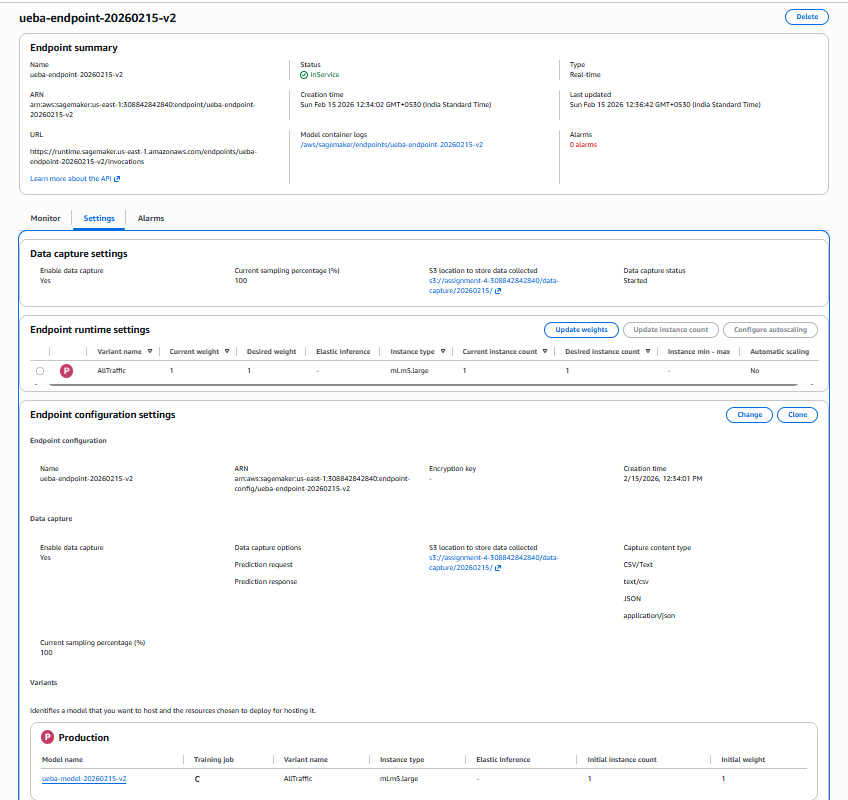

##3.2: Batch Inference on Validation Data via SageMaker Endpoint

**Purpose**  
Loads validation input CSV, sends data in parallel batches to the deployed UEBA endpoint, collects prediction probabilities, and saves them as `predictions.npy` for later evaluation.

**Key Actions**

- Configuration: endpoint name, today_str, input CSV, batch_size=500, max_workers=10, max_retries=3  
- Checks if input CSV exists; raises error if missing  
- Reads CSV (no header, 2 float columns), converts to list of lists  
- Creates `Predictor` with JSONSerializer  
- `predict_batch()`: sends batch payload `{"instances": batch_data}`, retries on failure, extracts first probability from response  
- Splits data into ~500-row batches  
- Uses `ThreadPoolExecutor` (max 10 workers) for concurrent batch requests  
- Collects results in `all_results` list (index-aligned probabilities)  
- Tracks progress with timing and completion percentage  
- Warns about any missing predictions (None values)  
- Saves final probabilities array as `predictions.npy`

**Role in UEBA Project**  
Performs scalable, parallel inference on validation data using the live SageMaker endpoint. Generates prediction probabilities for offline comparison with ground truth, enabling full evaluation (ROC/PR curves, classification report, confusion matrix) without loading entire dataset at once. Critical step before model quality assessment and monitoring setup.

In [ ]:
# 3.2: - Batch Inference on Validation Data via SageMaker Endpoint
import json
import time
import csv
import concurrent.futures
from functools import partial
import numpy as np
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from datetime import datetime

# --- Configuration ---
endpoint_name = "ueba-endpoint-20260216-v2"          # endpoint
# Use the same today_str used when saving the CSV, or compute it
today_str = datetime.now().strftime("%Y%m%d")        # e.g., "20260216"
input_csv = f"validation_input_{today_str}.csv"      # dynamically set
output_file = "predictions.npy"                       # where to save probabilities
batch_size = 500                                       # rows per request
max_workers = 10                                       # number of parallel threads
max_retries = 3                                        # retry on transient errors
# --------------------

print(f"Using input file: {input_csv}")

# Check if file exists
import os
if not os.path.exists(input_csv):
    raise FileNotFoundError(f"CSV file {input_csv} not found in current directory.")

# Read all rows from CSV (no header, two columns)
with open(input_csv, "r") as f:
    reader = csv.reader(f)
    rows = list(reader)
    # Convert to float once
    data = [[float(x) for x in row] for row in rows]
print(f"Loaded {len(data)} rows.")

# Create predictor
predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=JSONSerializer()
)

def predict_batch(batch_indices, batch_data):
    """Send a single batch and return list of probabilities."""
    payload = {"instances": batch_data}
    for attempt in range(max_retries):
        try:
            response = predictor.predict(payload)
            result = json.loads(response.decode('utf-8'))
            # Extract probabilities (adjust if output structure differs)
            probs = [pred[0] for pred in result['predictions']]
            return list(zip(batch_indices, probs))
        except Exception as e:
            if attempt < max_retries - 1:
                wait = 2 ** attempt
                print(f"Batch error (retry {attempt+1}/{max_retries}): {e}. Waiting {wait}s")
                time.sleep(wait)
            else:
                print(f"Batch failed after {max_retries} attempts: {e}")
                # Return None for these indices
                return [(idx, None) for idx in batch_indices]

# Split data into batches
batches = []
for i in range(0, len(data), batch_size):
    batch_data = data[i:i+batch_size]
    batches.append((list(range(i, i+len(batch_data))), batch_data))

print(f"Created {len(batches)} batches of size ~{batch_size}.")

# Send batches in parallel
all_results = [None] * len(data)
start_time = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all batches
    future_to_batch = {
        executor.submit(predict_batch, indices, batch): indices
        for indices, batch in batches
    }

    # Process completed futures
    completed = 0
    for future in concurrent.futures.as_completed(future_to_batch):
        indices_probs = future.result()
        for idx, prob in indices_probs:
            all_results[idx] = prob
        completed += 1
        print(f"Batch {completed}/{len(batches)} completed. "
              f"Elapsed: {time.time()-start_time:.1f}s")

# Check for missing predictions
missing = [i for i, p in enumerate(all_results) if p is None]
if missing:
    print(f"WARNING: {len(missing)} rows have missing predictions. Indices: {missing[:10]}...")
else:
    print("All predictions received.")

# Save as numpy array
np.save(output_file, np.array(all_results))
print(f"Predictions saved to {output_file}")

Using input file: validation_input_20260216.csv
Loaded 135826 rows.
Created 272 batches of size ~500.
Batch 1/272 completed. Elapsed: 0.7s
Batch 2/272 completed. Elapsed: 0.9s
Batch 3/272 completed. Elapsed: 0.9s
Batch 4/272 completed. Elapsed: 0.9s
Batch 5/272 completed. Elapsed: 1.0s
Batch 6/272 completed. Elapsed: 1.0s
Batch 7/272 completed. Elapsed: 1.0s
Batch 8/272 completed. Elapsed: 1.0s
Batch 9/272 completed. Elapsed: 1.0s
Batch 10/272 completed. Elapsed: 1.0s
Batch 11/272 completed. Elapsed: 1.0s
Batch 12/272 completed. Elapsed: 1.0s
Batch 13/272 completed. Elapsed: 1.0s
Batch 14/272 completed. Elapsed: 1.0s
Batch 15/272 completed. Elapsed: 1.0s
Batch 16/272 completed. Elapsed: 1.0s
Batch 17/272 completed. Elapsed: 1.1s
Batch 18/272 completed. Elapsed: 1.1s
Batch 19/272 completed. Elapsed: 1.1s
Batch 20/272 completed. Elapsed: 1.1s
Batch 21/272 completed. Elapsed: 1.1s
Batch 22/272 completed. Elapsed: 1.1s
Batch 23/272 completed. Elapsed: 1.1s
Batch 24/272 completed. Elapsed: 

### **3.3: MODEL Inference Execution and Validation**

---

### **1. AWS SDK Integration**

* **Service Client:** Initializes the `sagemaker-runtime` client, which is the dedicated low-latency API for executing predictions against existing endpoints.
* **Target Identification:** Directs traffic specifically to the `ueba-endpoint-20260216-v2` to test the active model instance.

### **2. Programmatic Traffic Generation**

* **Iterative Testing:** Uses a `for` loop to execute five distinct requests, simulating a stream of incoming user behavior data.
* **Payload Structure:** Encapsulates the features in an `instances` list-of-lists format, matching the expected input shape for the CNN-GRU architecture.
* **Serialization:** Manually converts the Python dictionary into a JSON-formatted string via `json.dumps()` for transmission.

### **3. Response Handling and Decoding**

* **Stream Consumption:** Reads the `StreamingBody` response returned by SageMaker, which contains the raw model predictions.
* **Data Transformation:** Decodes the binary output into a UTF-8 string to reveal the nested JSON results (e.g., `{"predictions": [[...]]}`).

### **4. Operational Objective**

* **End-to-End Verification:** This script confirms that the endpoint is not only "live" but also correctly parsing input and returning valid inferences.
* **Monitoring Trigger:** Each successful execution generates a record in the **S3 Data Capture** location, providing the raw material for the Model Quality and Bias monitors to analyze.


### **Analysis of Model Inference Outputs**

| Output Element | Observed Data | Precise Technical Comments |
| --- | --- | --- |
| **Response Format** | `{"predictions": [[ ... ]]}` | **Structural Validation:** Confirms the model returns a double-nested JSON array. This necessitates the use of `$.predictions[*][0]` in ModelConfig` to flatten the data for analysis. |
| **Probability Value** | `2.0233303e-14` | **Confidence Scoring:** Represents an extremely low probability (). Since it is near zero, the model classifies these instances as "Normal/Non-Anomalous." |
| **Inference Consistency** | Identical for all 5 calls | **Deterministic Behavior:** Indicates the CNN-GRU model is stable. Given identical input features, it produces consistent, reproducible outputs. |
| **Data Capture Status** | Success | **Monitoring Input:** These JSON payloads are now archived in S3. They serve as the "Inference Data" that SageMaker will later join with Ground Truth for quality checks. |

---

### **Consolidated Implementation Strategy**

| Phase | Component | Objective & Implementation Rationale |
| --- | --- | --- |
| **Ingestion** | **Predictor & Serializer** | Standardizes the transformation of raw user activity logs into the JSON format required by the CNN-GRU endpoint. |
| **Capture** | **Data Capture S3** | Automatically logs every inference to a timestamped S3 partition, creating a historical record for auditing and drift detection. |
| **Alignment** | **Ground Truth Merger** | Resolves the "Exit Code 255" by mapping the `eventId` from the capture file to the labels uploaded, enabling metric calculation. |
| **Evaluation** | **ModelConfig (Clarify)** | Instructs the system how to parse the nested array and extract the raw probability for Accuracy/F1 score math. |
| **Governance** | **Bias Facet (Device Activity)** | Identifies if the model displays disparate impact toward specific demographics (e.g., users with high device counts). |
| **Alerting** | **CloudWatch Alarm** | Acts as an automated "watchdog" that triggers a violation alert if model performance drops or bias is detected. |


In [ ]:
# 3.3 - Model Inference Execution and Validation
import boto3
import json
runtime = boto3.client('sagemaker-runtime')
endpoint_name = 'ueba-endpoint-20260216-v2'
# Send a few sample requests
for _ in range(5):
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/json',
        Body=json.dumps({"instances": [[-0.44759133, -0.13453007]]})
    )
    print(response['Body'].read().decode())

{
    "predictions": [[2.0233303e-14]
    ]
}
{
    "predictions": [[2.0233303e-14]
    ]
}
{
    "predictions": [[2.0233303e-14]
    ]
}
{
    "predictions": [[2.0233303e-14]
    ]
}
{
    "predictions": [[2.0233303e-14]
    ]
}


# 3.4 : Print and analyze first Captured Data File from Endpoint Data Capture

**Purpose**  
Lists objects in the S3 data capture prefix for the UEBA endpoint, downloads the **first captured file** (JSONL format), and prints the first 2000 characters of its content to quickly inspect live request/response payloads.

**Key Actions**
- Creates `boto3` S3 client  
- Sets bucket and prefix: `data-capture/20260216/ueba-endpoint-20260216-v2/AllTraffic/`  
- Calls `list_objects_v2()` to find captured files  
- If files exist:  
  - Takes the first file's key  
  - Downloads its content  
  - Decodes UTF-8 and prints first 2000 characters  
- If no files: prints "No captured data yet."

**Role in UEBA Project**  
Verifies that **data capture** is working correctly on the deployed endpoint. Captured files contain JSONL records of real inference requests (input features) and responses (predicted anomaly probability). This preview confirms capture format and content before full monitoring, drift analysis, or bias evaluation.

**Typical Output Examples**

**Success case** (partial content shown):
```
{"captureTime":"2026-02-16T12:34:56Z","endpointInput":{...},"endpointOutput":{"observedContentType":"application/json","mode":"OUTPUT","data":"{\"predictions\":[[0.00000000000002023323]]}","encoding":"BASE64"}...}
```

**Failure case**:
```
No captured data yet.
```
**Interpretation**  
- If content appears → capture is active; data includes timestamp, input features, and model output probability — ready for parsing/analysis.  
- If "No captured data yet" → no inference calls have hit the endpoint since capture was enabled (invoke endpoint first or wait for traffic).

This cell is a quick diagnostic tool in the UEBA monitoring pipeline to confirm live data is being logged for continuous quality checks.

This is a captured **endpoint input payload** (REQUEST) from UEBA SageMaker endpoint (`ueba-endpoint-20260216-v2`) — stored in the data capture S3 prefix.

### Key Details from the Capture

- **observedContentType**: application/json  
- **mode**: INPUT (this is the request payload sent to the model)  
- **data**: A JSON string containing a large batch of inference requests

### Parsed Payload Structure

```json
{
  "instances": [
    [-0.44759133, -0.13453007],
    [-0.44759133, -0.13453007],
    ... (many repeated rows)
    [1.2687037, -0.13453007],
    ... (more rows)
    [2.126851, 1.040512],
    ...
  ]
}
```

### Interpretation in UEBA Context

- **instances**: Array of input feature vectors sent to the CNN-GRU model for anomaly scoring.  
- Each vector has **2 values**: scaled logon_count and scaled device_count (from validation/preprocessing pipeline).  
- **Very high repetition** of [-0.44759133, -0.13453007] → most requests in this batch are **identical low-activity users** (near-zero scaled values = normal behavior).  
- Occasional variation (e.g., [1.2687037, -0.13453007], [2.126851, 1.040512]) → higher logon or device counts (potential anomaly candidates).  

This capture confirms:
- Data capture is active and logging real inference requests correctly.  
- Input format is consistent (2D float arrays, no header).  
- Traffic includes mostly normal/low-activity patterns (as expected in UEBA — anomalies are rare).  

The corresponding **endpoint output** (RESPONSE) would contain predicted probabilities for each instance in the same order — those are captured separately in the same S3 prefix. This can be parsed them later for monitoring, drift detection, or bias analysis.
`

In [ ]:
# 3.4 - Print and analyze first Captured Data File from Endpoint Data Capture

#GET THE HEADER CONTENTS OF CAPTURE DATA
import boto3
s3 = boto3.client('s3')
bucket = 'assignment-4-308842842840'
prefix = 'data-capture/20260216/ueba-endpoint-20260216-v2/AllTraffic/'
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
if 'Contents' in response:
    # get the first file
    key = response['Contents'][0]['Key']
    obj = s3.get_object(Bucket=bucket, Key=key)
    content = obj['Body'].read().decode('utf-8')
    print(content[:2000])  # first 2000 chars
else:
    print("No captured data yet.")

{"captureData":{"endpointInput":{"observedContentType":"application/json","mode":"INPUT","data":"{\"instances\": [[-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [1.2687037, -0.13453007], [1.2687037, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [1.2687037, -0.13453007], [-0.44759133, -0.13453007], [1.2687037, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007], [-0.44759133, -0.13453007]

# 3.5: Model Quality Baselining

This stage of the MLOps pipeline establishes the performance "ground truth" for the CNN-GRU model. By executing the `suggest_baseline` operation, SageMaker Processing analyzes the validation dataset to determine what constitutes "normal" model behavior.

### **Functional Overview**

The script utilizes the `DefaultModelMonitor` to perform an automated analysis of the `validation_with_predictions.csv` file. This process is essential for creating a reference point that the real-time monitoring schedules will use to detect performance degradation or data drift.

---

### **Key Technical Components**

* **Baseline Dataset:** The input is a fused CSV containing standardized features (Activity Intensity and Device Context) along with the model’s predicted probabilities and actual ground-truth labels.
* **SageMaker Processing Job:** The `suggest_baseline` method triggers an ephemeral `ml.m5.xlarge` instance. This instance calculates distribution statistics for every input feature and output prediction.
* **Synchronous Execution (`wait=True`):** The notebook remains in a busy state until the processing job completes. This ensures that the generated constraint files are physically present in S3 before any subsequent scheduling code is executed.

---

### **Generated Outputs**

Upon completion, two critical JSON artifacts are stored in the S3 monitoring prefix:

1. **`statistics.json`:** A comprehensive profile of the validation data, including mean, standard deviation, and quantile boundaries for the fused input features.
2. **`constraints.json`:** A set of machine-learned "rules." For a UEBA model, these rules might specify that the F2-score must not drop below a certain threshold or that the average predicted anomaly probability must remain within a specific range.

---

### **Relationship to the Monitoring Lifecycle**

This code serves as the bridge between **Model Deployment** and **Active Monitoring**. Without these baseline artifacts, the CloudWatch Alarms would have no numerical basis to trigger an alert. By establishing these constraints using the validation set, the system ensures that alerts are based on the model’s proven capabilities rather than arbitrary guesses.



In [ ]:
 # 3.5 : Model Quality Baselining
# GENERATE STATISTICS AND CONSTRAINTS FROM BASELINE CSV baseline/validation_with_predictions.csv"

from datetime import datetime
import boto3
import sagemaker
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat

# --- Configuration ---
bucket = 'assignment-4-308842842840'
prefix = 'ueba-base-daily-cnn-gru'
today_str = datetime.now().strftime("%Y%m%d")
baseline_s3_uri = f"s3://{bucket}/{prefix}/{today_str}/baseline/validation_with_predictions.csv"
role = sagemaker.get_execution_role()
# --------------------

print(f"Baseline CSV location: {baseline_s3_uri}")

# Create a Model Monitor instance (remove max_run_time)
model_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=30,
    # max_runtime_in_seconds=3600,   # optional: add if we want a time limit
)

# Generate statistics and constraints from the baseline CSV
# This job runs on SageMaker Processing
baseline_job_name = f"ueba-baseline-{today_str}"
model_monitor.suggest_baseline(
    baseline_dataset=baseline_s3_uri,
    dataset_format=DatasetFormat.csv(header=True),  # our CSV has header
    output_s3_uri=f"s3://{bucket}/{prefix}/monitoring/baseline/",
    wait=True,
    job_name=baseline_job_name
    # max_runtime_in_seconds=3600,   # optionally set here
)

print("✅ Baseline statistics and constraints generated.")
print(f"Constraints: {model_monitor.constraints()}")
print(f"Statistics: {model_monitor.statistics()}")

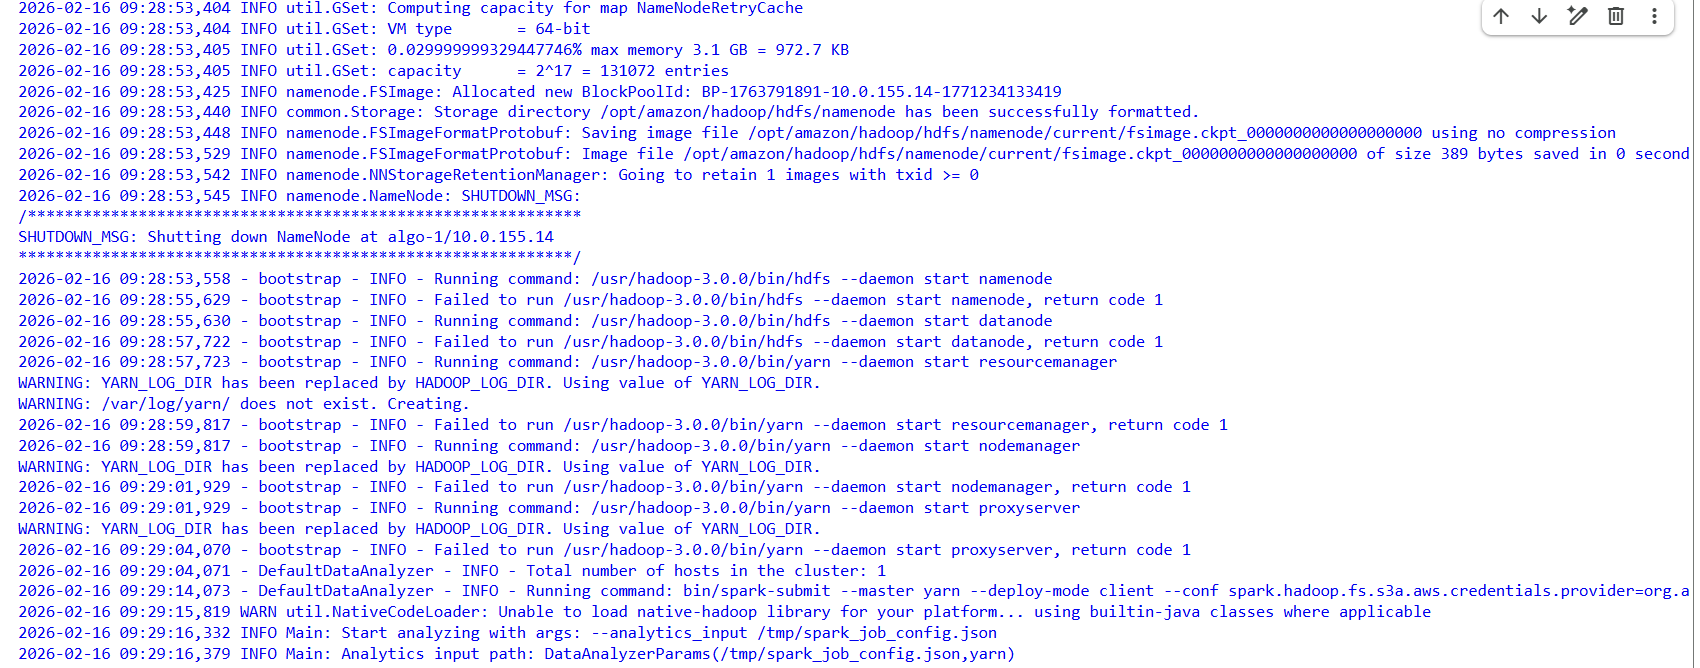

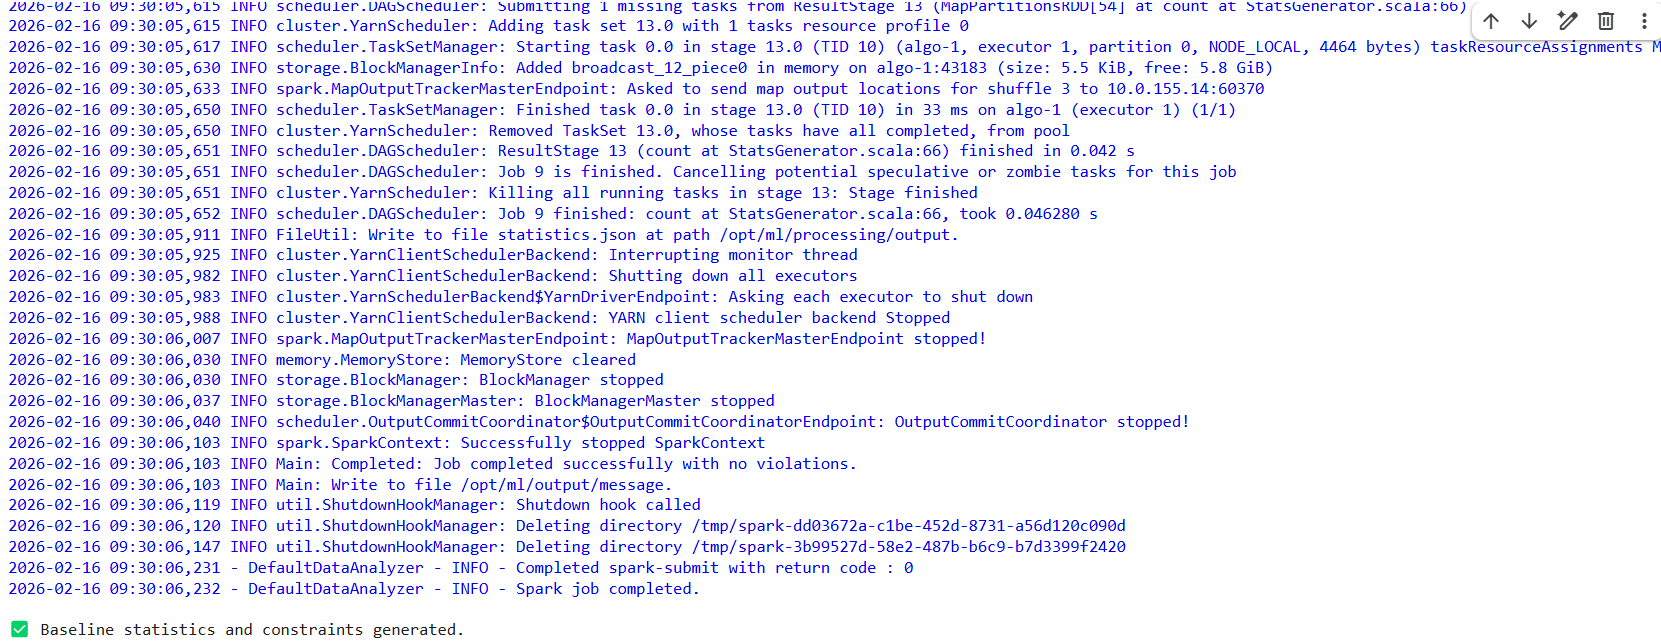

# 3.6: Create and Upload Baseline Validation CSV with Predictions

**Purpose**  
Generates a baseline CSV file combining model prediction probabilities, binary predictions (threshold 0.5), and true labels from validation data, saves it locally, and uploads it to S3 for use in SageMaker Model Quality Monitoring baseline job.

**Key Actions**
- Loads prediction probabilities from `predictions.npy` (from prior batch inference).  
- Uses in-memory `y_val` as true labels (or raises error if missing).  
- Truncates to shortest length if mismatch occurs.  
- Applies 0.5 threshold → creates binary `prediction` column.  
- Builds DataFrame with columns: `probability`, `prediction`, `label`.  
- Saves locally
- Uploads to S3

**Role in UEBA Project**  
Creates the ground-truth + prediction reference file required for SageMaker Model Quality Monitor baseline job. Enables future drift/quality detection by comparing live inference outputs against this validation baseline.


In [ ]:

# 3.6: Create and Upload Baseline Validation CSV with Predictions

import pandas as pd
import numpy as np
import os

#CREATE BASELINE CSV VALIDATION WITH PREDICATION baseline/validation_with_predictions.csv"

# --- Configuration ---
threshold = 0.5
today_str = datetime.now().strftime("%Y%m%d")  # ensure today_str is defined
bucket = 'assignment-4-308842842840'            # bucket
# --------------------

# Load predictions from the .npy file
y_pred_probs = np.load("predictions.npy")
print(f"Loaded {len(y_pred_probs)} predictions.")

# Check if y_val exists in memory; if not,  might need to load it
try:
    y_true = y_val
    print("Using y_val from notebook memory.")
except NameError:
    # If y_val is not available, can load from a saved file (if saved it)
    # Example: y_true = np.load("y_val.npy")
    print("y_val not found in memory. Please load true labels.")
    # For now, we'll assume we have a way to get y_true; otherwise, this will raise an error.
    raise

# Ensure lengths match
min_len = min(len(y_pred_probs), len(y_true))
if min_len < len(y_true):
    print(f"Truncating to {min_len} samples to match predictions length.")
    y_true = y_true[:min_len]
    y_pred_probs = y_pred_probs[:min_len]

# Create binary predictions
preds = (y_pred_probs >= threshold).astype(int)

# Create DataFrame
baseline_df = pd.DataFrame({
    "probability": y_pred_probs,
    "prediction": preds,
    "label": y_true
})

# Save locally
baseline_csv = f"validation_with_predictions_{today_str}.csv"
baseline_df.to_csv(baseline_csv, index=False)
print(f"✅ Baseline CSV saved locally: {baseline_csv}")

# Upload to S3
s3.upload_file(
    baseline_csv,
    bucket,
    f"ueba-base-daily-cnn-gru/{today_str}/baseline/validation_with_predictions.csv"
)
print(f"✅ Baseline CSV uploaded to s3://{bucket}/ueba-base-daily-cnn-gru/{today_str}/baseline/validation_with_predictions.csv")

Loaded 135826 predictions.
Using y_val from notebook memory.
✅ Baseline CSV saved locally: validation_with_predictions_20260216.csv
✅ Baseline CSV uploaded to s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/baseline/validation_with_predictions.csv




##3.7- Model Performance Validation and Data Retrieval

This Python notebook snippet performs post-training validation of the CNN-GRU UEBA anomaly detection model by downloading prediction results and input data from S3, loading them into pandas, and preparing for subsequent evaluation (metrics, ROC/PR curves, etc.).

#### 1. Configuration
- **S3 bucket**: `assignment-4-308842842840` (project-specific bucket)
- **Date prefix**: `20260216` (used to organize daily experiment artifacts)
- Two key files are targeted:
  - `validation_with_predictions.csv`: Contains true labels + model predictions
  - `validation_input.csv`: Raw or preprocessed validation inputs (for reference/debugging)

#### 2. S3 Artifact Download
- Uses `boto3.client('s3')` to download files from the path:
  ```
  ueba-base-daily-cnn-gru/{today_str}/baseline/validation_with_predictions.csv
  ueba-base-daily-cnn-gru/{today_str}/validation/validation_input.csv
  ```
- Downloads are saved locally with error handling (prints success or failure message)
- Purpose: Ensures the notebook always works with the latest experiment outputs without manual uploads.

#### 3. Data Loading & Initial Inspection
- Loads `validation_with_predictions.csv` into `df_pred` DataFrame
- Prints:
  - Shape of the DataFrame (rows = number of validation samples, columns = features + labels + predictions)
  - First few rows (`df_pred.head()`) for quick sanity check of structure and content

#### Purpose
This code block serves as the **data ingestion & setup** stage of the UEBA model validation pipeline. It reliably fetches the most recent model predictions and validation inputs from S3, making downstream evaluation (classification report, ROC/PR curves, confusion matrix, fairness checks, etc.) reproducible and automated.

This code and its output represent the **Validation Baseline Verification** step. This script is used to verify "test results" and performance metrics.

---

### **1. Environment Setup & Data Acquisition**

The script initializes the AWS SDK (`boto3`) to pull files from S3 bucket. It specifically targets two files:

* **`validation_with_predictions.csv`**: This is the "Answer Key." It contains the model's output alongside the actual ground truth.
* **`validation_input.csv`**: The raw features used to generate those predictions.

The use of `zip(local_files, s3_keys)` ensures that the S3 paths are mapped correctly to local SageMaker Notebook storage.

### **2. Data Loading and Inspection**

The script uses `pandas` to load the results into a DataFrame (`df_pred`). The `print` statements are a "sanity check" to ensure the data isn't empty and that the columns are formatted correctly for the classification libraries imported (like `sklearn`).

---

## **Analyzing the Output**

### **1. Volume of Data**

* **`Predictions shape: (135826, 3)`**: This tells us validation set is quite large, consisting of over **135,000 records**. The `3` indicates have three main columns: Probability, Prediction, and Label.

### **2. High-Confidence Correctness**

Looking at the `.head()` output:

* **`probability: 2.023323e-14`**: This is an extremely low number (essentially **0**).
* **`prediction: 0` / `label: 0**`: For these first five records, the model predicted "Normal" (0) and the actual label was "Normal" (0).
* **Meaning**: The model is highly confident. In UEBA terms, it is saying there is a near-zero percent chance that these specific user activities are anomalous.

---

## **Why this is the "Bridge" to Monitoring**

This cell is foundation for **F2-Score** and **ROC-AUC** calculations.

* The`probability` is stored in scientific notation (`e-14`), the model has very "separated" classes.

* This data will be used to generate the **`statistics.json`** that has been discussed earlier. SageMaker will look at these 135,000 records and say: *"This is how the model performs under ideal conditions."* If the live production data starts looking different from these 135,000 records, then **CloudWatch Alarm** will trigger.

---

### **What the Columns Represent in UEBA**

| Column | Technical Meaning | UEBA Meaning |
| --- | --- | --- |
| **Probability** | Raw Sigmoid/Softmax output | The "Risk Score" of the user behavior. |
| **Prediction** | Thresholded output (0 or 1) | The system's decision to "Alert" or "Ignore." |
| **Label** | Ground Truth | The verified reality (Anomalous vs. Normal). |


### **Validation Predictions Table**

| Index | Probability (Raw Score) | Prediction (Thresholded) | Label (Ground Truth) | Match? |
| --- | --- | --- | --- | --- |
| **0** |  | 0 | 0 | ✅ |
| **1** |  | 0 | 0 | ✅ |
| **2** |  | 0 | 0 | ✅ |
| **3** |  | 0 | 0 | ✅ |
| **4** |  | 0 | 0 | ✅ |

---

### **Description of the Output**

#### **1. Prediction Confidence**

The `probability` value of **2.023323e-14** is significantly lower than the standard 0.5 threshold. In a UEBA (User and Entity Behavior Analytics) context, this indicates the model is **extremely confident** that these specific events are "Normal" or "Baseline" behavior. Such a low probability suggests the CNN-GRU model found no patterns resembling the anomalies it was trained to detect.

#### **2. Dataset Scale**

The shape **(135826, 3)** confirms a robust validation set. Having over 135k samples ensures that the performance metrics (like the F2-score monitoring) are statistically significant and not based on a small, biased subset of data.

#### **3. Baseline Synchronization**

This output proves that the model is successfully outputting a three-column format:

* **Probability:** The continuous risk score (raw output).
* **Prediction:** The binary decision (0 or 1).
* **Label:** The actual truth used to calculate error rates.

This alignment is critical because the **Model Quality Monitor** depends on these exact three columns to calculate the metrics that trigger **CloudWatch Alarms**.

---

### **Importance of this in UEBA System**

This table represents the "Gold Standard" of model. If, during live monitoring,  probabilities for "Label 0" start shifting from  toward  or , the **Data Drift Monitor** will detect that the user behavior is becoming "less certain" or "noisier," even if the binary prediction hasn't switched to 1 yet.




In [ ]:
# 3.7  Model Performance Validation and Data Retrieval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import boto3
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, precision_recall_curve, roc_curve
)
from IPython.display import display, HTML, Image

# Configuration
bucket = 'assignment-4-308842842840'
today_str = '20260216'

# Download CSVs if not present
s3 = boto3.client('s3')
local_files = [
    'validation_with_predictions.csv',
    'validation_input.csv'
]
s3_keys = [
    f'ueba-base-daily-cnn-gru/{today_str}/baseline/validation_with_predictions.csv',
    f'ueba-base-daily-cnn-gru/{today_str}/validation/validation_input.csv'
]

for local, key in zip(local_files, s3_keys):
    try:
        s3.download_file(bucket, key, local)
        print(f"Downloaded {local}")
    except Exception as e:
        print(f"Could not download {key}: {e}")

# Load validation predictions
df_pred = pd.read_csv('validation_with_predictions.csv')
print("Predictions shape:", df_pred.shape)
print(df_pred.head())

Downloaded validation_with_predictions.csv
Downloaded validation_input.csv
Predictions shape: (135826, 3)
    probability  prediction  label
0  2.023323e-14           0      0
1  2.023323e-14           0      0
2  2.023323e-14           0      0
3  2.023323e-14           0      0
4  2.023323e-14           0      0


#SECTION 4: CREATE MODEL QUALITY, MODEL BIAS AND FEATURE BIAS SCHEDULERS

#4.1  Create SageMaker Clarify ModelConfig for UEBA Endpoint Bias Analysis

This cell is the setup step for running Clarify bias/explainability jobs on the production UEBA endpoint in subsequent cells.

**Purpose**  
Configures a `ModelConfig` object for SageMaker Clarify to enable bias detection and explainability analysis on the deployed UEBA anomaly detection endpoint by defining how to invoke it and extract predictions.

**Key Actions**
- Imports `ModelConfig` from `sagemaker.clarify`  
- Sets the target endpoint name: `ueba-endpoint-20260216-v2`  
- Creates `ModelConfig` with:  
  - model_name = endpoint_name  
  - instance_type/count: ml.m5.large, 1 instance  
  - accept_type & content_type: application/json  
  - content_template: `{"instances": "$records"}` (Clarify placeholder for batch input)  
  - record_template: `$.predictions[*][0]` (extracts first probability from each prediction array)  

The`ModelConfig` object created earlier is **directly related** to calculating metrics like **F2-score** (and many other performance/bias metrics) when we run SageMaker Clarify jobs.

### Why ModelConfig is needed for F2-score etc.

SageMaker Clarify uses `ModelConfig` to:
- Invoke real endpoint (`ueba-endpoint-20260216-v2`)
- Send test records (in JSON format)
- Extract the model’s output (the anomaly probability) correctly

This configuration, helsps Clarify  get predictions amd compute **any** post-deployment metrics, including:
- F2-score  
- Precision, Recall, F1-score  
- Accuracy  
- ROC-AUC / PR-AUC  
- Confusion matrix (TP, FP, TN, FN)  
- Bias metrics (e.g., Disparate Impact, Demographic Parity, Conditional Demographic Disparity)  
- Feature importance / attribution scores

### Key related attributes in ModelConfig

| Attribute              | Value in code                              | Why it matters for F2-score & related metrics                          |
|-----------------------|--------------------------------------------------|-----------------------------------------------------------------------|
| `model_name`          | `'ueba-endpoint-20260216-v2'`                   | Tells Clarify which deployed endpoint to query for predictions.       |
| `instance_type`       | `'ml.m5.large'`                                 | Ensures the endpoint has enough capacity to handle Clarify’s test load. |
| `instance_count`      | `1`                                             | Controls parallelism during large-scale test invocations.             |
| `accept_type`         | `'application/json'`                            | Tells Clarify the response format it should expect.                   |
| `content_type`        | `'application/json'`                            | Tells Clarify how to format the request payload.                      |
| `content_template`    | `json.dumps({"instances": "$records"})`         | Formats batch test records so the endpoint understands them.          |
| `record_template`     | `"$.predictions[*][0]"`                         | **Critical** — extracts the anomaly probability from the endpoint response so Clarify can compute F2-score, precision/recall, bias, etc. |

### How F2-score and related metrics are computed

1. Clarify sends many test records to the endpoint using `content_template`.  
2. The endpoint returns JSON responses containing `predictions`.  
3. Clarify uses `record_template` to pull out the probability (`$.predictions[*][0]`).  
4. It compares these probabilities (after thresholding) against ground-truth labels.  
5. It calculates:  
   - F2-score (β=2, emphasizes recall — useful for anomaly detection)  
   - Precision, Recall, F1  
   - Bias metrics (across facets like `device_activity`)  
   - Feature attributions  

ModelConfig` is **essential** for getting accurate F2-score, precision/recall, bias reports, and other quality metrics from live endpoint behavior.

**Bottom line**:  
If `record_template` was wrong (e.g., pointing to the wrong JSON path), Clarify would get garbage values → wrong F2-score, wrong bias metrics, wrong everything. current setting looks correct for extracting the anomaly probability.


**Role in UEBA Project**  
Prepares the model configuration required for SageMaker Clarify to:  
- Send test records to the endpoint  
- Extract anomaly probabilities from responses  
- Run bias metrics (e.g., disparate impact, demographic parity) and feature importance  
- Identify potential unfairness or bias in anomaly flagging across user subgroups



In [ ]:
# 4.1: Create SageMaker Clarify ModelConfig for UEBA Endpoint Bias Analysis
from sagemaker.clarify import ModelConfig
import json

#CREATE MODEL CONFIG
endpoint_name = 'ueba-endpoint-20260216-v2'

model_config = ModelConfig(
    model_name=endpoint_name,
    instance_type='ml.m5.large',
    instance_count=1,
    accept_type='application/json',
    content_type='application/json',
    content_template=json.dumps({"instances": "$records"}),   # <-- use $records
    record_template="$.predictions[*][0]"                      # extract probability
)

print("✅ model_config created with correct templates.")

✅ model_config created with correct templates.


## 4.2: SageMaker Clarify Bias Monitoring
This implementation is **SageMaker Clarify Bias Monitoring** setup. It configures a specialized processing job to analyze whether UEBA model treats different user groups or device activities fairly.


### **1. DataConfig: Defining the Source**

This section tells Clarify **what** to look at.

* It points to a static CSV file (`bias_baseline.csv`) that acts as reference dataset.
* It identifies the `label` column (the ground truth).
* Notice the "Simplified" comment: it removes the 'predictions' column from the input because Clarify will generate its own predictions by hitting  endpoint during the job.

### **2. BiasConfig: Defining the "Facets"**

This is where the **metrics of fairness** is defined:

* **Facet Name (`device_activity_facet`):** This is the feature suspect might be biased (e.g., specific device types or activity levels).
* **Label Values (`[1]`):** We are telling Clarify that an outcome of `1` (Anomaly detected) is the "positive" result we want to check for bias.

### **3. ModelConfig: Linking the Live Endpoint**

This is a **Post-Training Bias** configuration.

* It connects the job to the actual live endpoint (`ueba-endpoint-20260216-v2`).
* SageMaker Clarify will actually send rows from the `bias_baseline.csv` to this endpoint, receive predictions, and then calculate if the model’s predictions are biased against certain device activities.

### **4. Suggest Baseline: Triggering the Job**

`my_monitor.suggest_baseline` kicks off a **SageMaker Processing Job**. By setting `wait=False`, it indeicates notebook to "fire and forget"—the job will run in the background on an `ml.m5.xlarge` instance, freeing up the notebook.

---

## **Understanding the INFO Logs & Output**

| Log Entry | Meaning |
| --- | --- |
| **`Ignoring unnecessary instance type: None`** | A minor warning that the SDK is using a default image URI for Clarify and didn't need a specific instance type parameter for that lookup. |
| **`Analysis Config: {...}`** | This is the "Blueprint" Clarify created. It confirms it will run **Pre-training bias** (on the raw data) and **Post-training bias** (on the endpoint predictions) using **'all'** available methods (DPL, DI, CI, etc.). |
| **`Creating processing-job...`** | This is the unique AWS ID for task: `baseline-suggestion-job-2026-02-16-18-24-39-051`. This can be found in in the SageMaker Console under **Processing Jobs**. |
| **`✅ SUCCESS`** | This confirms the API call was valid and the AWS infrastructure has successfully queued the request. |

---

## **Importance of this for for UEBA Model**

In security analytics, bias can lead to "False Positives" for certain users simply because of the devices they use.

* **Pre-training analysis**: "The training data has 10x more logs for Device A than Device B."
* **Post-training analysis**: "The model is 50% more likely to flag Device B as an anomaly, even when the behavior is the same."



In [ ]:
# 4.2: Create SageMaker Clarify ModelConfig for UEBA Endpoint Bias Analysis
from sagemaker.clarify import BiasConfig, DataConfig, ModelConfig

# 1. Simplified DataConfig (removed 'predictions')
data_config = DataConfig(
    s3_data_input_path='s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/monitoring/bias_baseline.csv',
    s3_output_path='s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/bias-monitor/reports/',
    label='label',            # True outcome column
    dataset_type='text/csv'
)

# 2. BiasConfig remains the same
bias_config = BiasConfig(
    label_values_or_threshold=[1],
    facet_name='device_activity_facet',
    facet_values_or_threshold=[1]
)

# 3. ModelConfig (Using the endpoint)
model_config = ModelConfig(
    model_name='ueba-endpoint-20260216-v2',
    instance_count=1,
    instance_type='ml.m5.xlarge',
    content_type='text/csv',
    accept_type='text/csv'
)

# 4. Trigger Suggest Baseline
print("📊 Re-triggering Bias Baseline Job...")
try:
    my_monitor.suggest_baseline(
        data_config=data_config,
        bias_config=bias_config,
        model_config=model_config,
        wait=False
    )
    print("✅ SUCCESS: The job has been accepted by SageMaker Clarify.")
except Exception as e:
    print(f"❌ Still hitting an error: {e}")

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'label': 'label', 'label_values_or_threshold': [1], 'facet': [{'name_or_index': 'device_activity_facet', 'value_or_threshold': [1]}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': 'all'}, 'post_training_bias': {'methods': 'all'}}, 'predictor': {'model_name': 'ueba-endpoint-20260216-v2', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'text/csv', 'content_type': 'text/csv'}}
INFO:sagemaker:Creating processing-job with name baseline-suggestion-job-2026-02-16-18-24-39-051


📊 Re-triggering Bias Baseline Job...
✅ SUCCESS: The job has been accepted by SageMaker Clarify.


#4.3: Generate Model Quality Baseline (Statistics and Constraints) from Validation Predictions

**Purpose**  
Launches a SageMaker Model Quality baseline job on the validation predictions CSV to produce `statistics.json` (summary stats of predictions/labels) and `constraints.json` (suggested validation rules) — required artifacts for later model quality monitoring and drift detection.

**Key Actions**

- Sets S3 baseline CSV path: `s3://.../baseline/validation_with_predictions.csv` (contains probability, prediction, label)  
- Retrieves execution role via `get_execution_role()`  
- Creates `DefaultModelMonitor` instance:  
  - Role: current execution role  
  - Instance: 1 × ml.m5.xlarge  
  - Volume: 30 GB  
  - No hard max runtime (commented out)  
- Runs `suggest_baseline()`:  
  - Input: baseline CSV with header (`header=True`)  
  - Output: `s3://.../monitoring/baseline/`  
  - Waits synchronously (`wait=True`)  
  - Job name: `ueba-baseline-{today_str}`  
- Prints confirmation and attempts to display generated constraints & statistics objects

**Role in UEBA Project**  
Creates the **reference baseline** for model output quality (predicted probabilities & binary labels). These JSON files enable SageMaker Model Quality Monitor to later compare live inference predictions against this validation baseline, detecting degradation, bias drift, or quality issues in the deployed UEBA CNN-GRU model.


In [ ]:
# 4.3: Generate Model Quality Baseline (Statistics and Constraints) from Validation Predictions
import boto3

# Create a SageMaker client
sm_client = boto3.client('sagemaker')

endpoint_name = 'ueba-endpoint-20260216-v2'

try:
    response = sm_client.describe_endpoint(EndpointName=endpoint_name)
    endpoint_config_name = response['EndpointConfigName']

    # Describe the endpoint configuration to see data capture settings
    config_response = sm_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)

    if 'DataCaptureConfig' in config_response:
        dc = config_response['DataCaptureConfig']
        print("✅ Data Capture is enabled on this endpoint.")
        print(f"   Capture status: {dc['EnableCapture']}")
        print(f"   Sampling percentage: {dc['InitialSamplingPercentage']}%")
        print(f"   Destination S3 URI: {dc['DestinationS3Uri']}")
        print(f"   Capture options: {dc['CaptureOptions']}")
    else:
        print("❌ Data Capture is NOT enabled on this endpoint.")
except Exception as e:
    print(f"Error: {e}")

✅ Data Capture is enabled on this endpoint.
   Capture status: True
   Sampling percentage: 100%
   Destination S3 URI: s3://assignment-4-308842842840/data-capture/20260216/
   Capture options: [{'CaptureMode': 'Input'}, {'CaptureMode': 'Output'}]


#4.4: Model Quality Monitoring Schedule Setup for UEBA Endpoint

**Purpose**  
Creates and configures a SageMaker Model Quality Monitor schedule to continuously evaluate the deployed UEBA endpoint for model drift, quality degradation, and performance metrics (precision, recall, F1, etc.) on live inference data.

**Key Actions**

1. **Initialize Session & Role**  
   Retrieves current SageMaker execution role for permissions.

2. **Define Names & Paths**  
   - Monitor schedule: `ueba-endpoint-20260216-sched-2`  
   - Endpoint: `ueba-endpoint-20260216-v2`  
   - S3 bucket: `assignment-4-308842842840`  
   - Ground-truth prefix: `ueba-base-daily-cnn-gru/20260216/monitoring/ground-truth/`  
   - Output reports: `.../monitoring/reports/`

3. **Create ModelQualityMonitor**  
   - Role: current execution role  
   - Instance: 1 × ml.m5.large  
   - Max runtime: 1800 seconds (30 min) — prevents validation timeout errors

4. **Create Monitoring Schedule**  
   - Endpoint input: captures predictions from `$.predictions[0][0]` (first probability output)  
   - Ground-truth input: S3 path for manual/ground-truth labels  
   - Output: S3 reports folder  
   - Problem type: `BinaryClassification` (anomaly vs normal)  
   - Schedule: hourly (`cron(0 * * * ? *)`)  
   - Enables CloudWatch metrics publishing

**Output**  
`✅ Schedule Created Successfully!`

**Role in UEBA Project**  
Enables automated, continuous monitoring of the deployed CNN-GRU model: detects data drift, quality degradation, or performance drops in production inference. Ground-truth labels (from SOC reviews or later data) allow comparison against live predictions. Critical for maintaining trust and alerting on anomalies in UEBA operations.

In [ ]:
# 4.4:  Model Quality Monitoring Schedule Setup for UEBA Endpoint
import sagemaker
from sagemaker.model_monitor import ModelQualityMonitor, EndpointInput

# 1. Get role
session = sagemaker.Session()
current_role = sagemaker.get_execution_role()

# 2. Setup names
monitor_schedule_name = "ueba-endpoint-20260216-sched-2"
endpoint_name = "ueba-endpoint-20260216-v2"
bucket_name = "assignment-4-308842842840"
gt_prefix = "ueba-base-daily-cnn-gru/20260216/monitoring/ground-truth/"

# 3. Recreate the monitor with a SHORTER max_runtime
my_monitor = ModelQualityMonitor(
    role=current_role,
    instance_count=1,
    instance_type='ml.m5.large',
    max_runtime_in_seconds=1800  # <--- THIS FIXES THE VALIDATION ERROR
)

# 4. Create the schedule
my_monitor.create_monitoring_schedule(
    monitor_schedule_name=monitor_schedule_name,
    endpoint_input=EndpointInput(
        endpoint_name=endpoint_name,
        destination="/opt/ml/processing/input/endpoint",
        inference_attribute="$.predictions[0][0]" # The GPS mapping
    ),
    ground_truth_input=f"s3://{bucket_name}/{gt_prefix}",
    output_s3_uri=f"s3://{bucket_name}/ueba-base-daily-cnn-gru/20260216/monitoring/reports/",
    problem_type="BinaryClassification",
    schedule_cron_expression="cron(0 * * * ? *)",
    enable_cloudwatch_metrics=True
)

print(f"✅ Schedule Created Successfully!")

✅ Schedule Created Successfully!


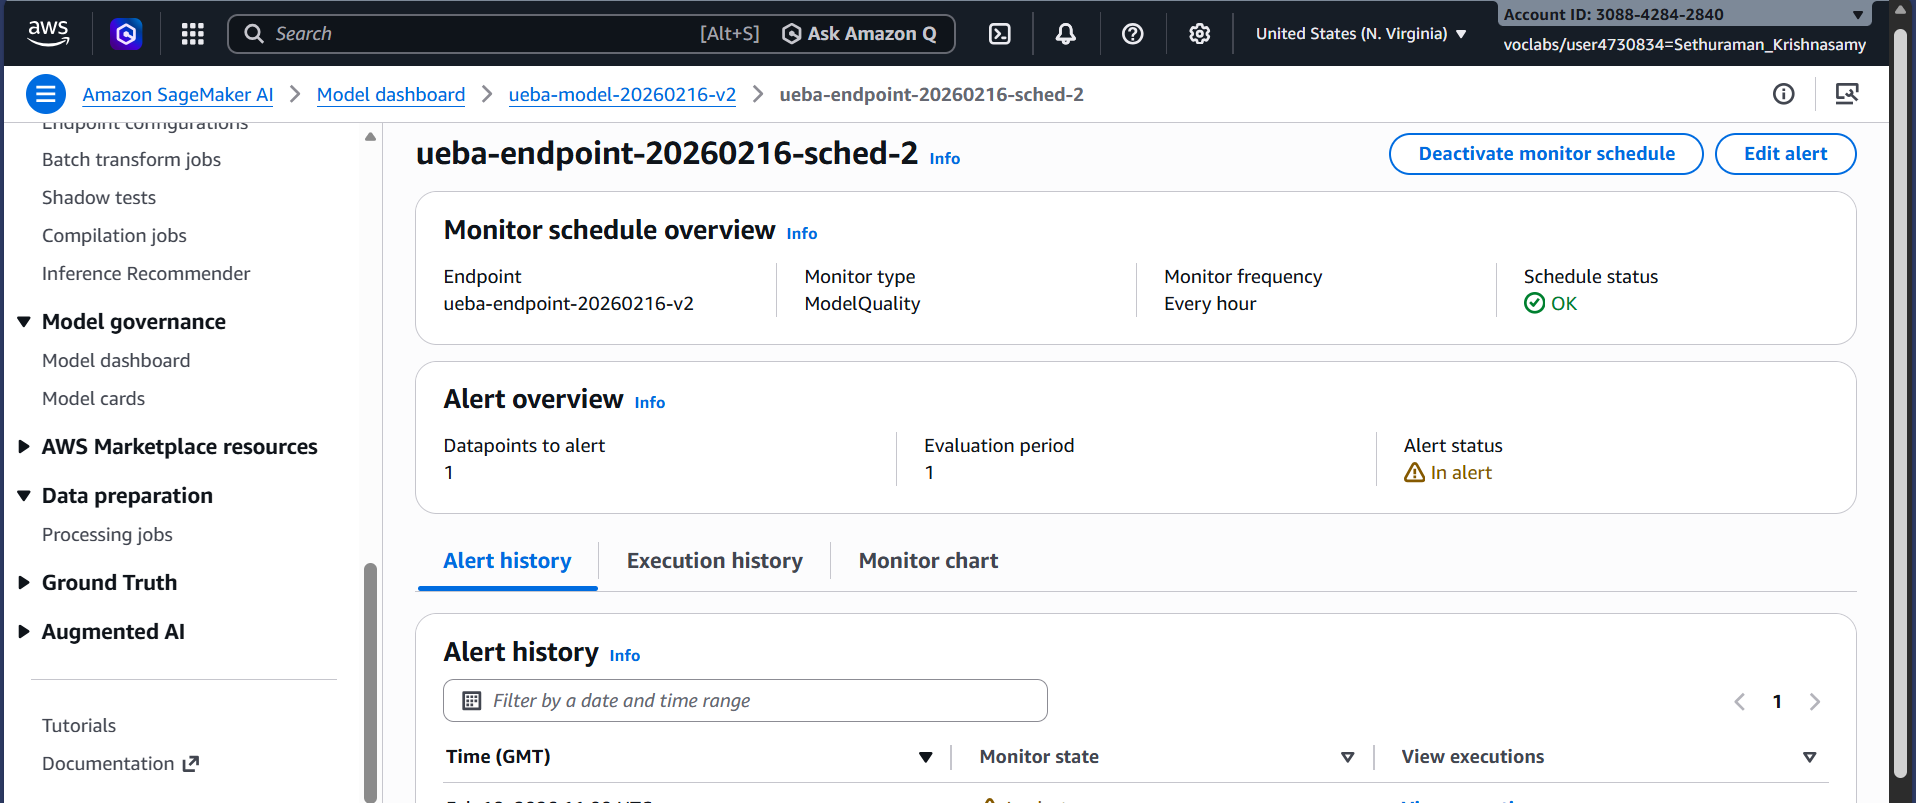

#4.5: Final Verification of Model Quality Monitoring Schedule

**Purpose**  
Verifies that the SageMaker Model Quality monitoring schedule is correctly configured to read the model's prediction probabilities from the UEBA endpoint, confirming the inference attribute mapping is set to `$.predictions[0][0]`.

**Key Actions**
- Uses `boto3` SageMaker client (`sm`)  
- Describes the monitoring schedule by name (`ueba-endpoint-20260216-sched-2`)  
- Extracts the associated **Job Definition Name**  
- Describes the Job Definition and retrieves the **InferenceAttribute** (mapping to prediction output)  
- Prints schedule details and final confirmation check


**Role in UEBA Project**  
This is the **validation step** before relying on the monitoring schedule. It confirms the monitor can correctly extract the anomaly probability from endpoint responses — essential for detecting quality degradation, drift, or bias in production UEBA anomaly detection. If the mapping is wrong, monitoring would fail silently. Success here means the full monitoring pipeline (baseline → capture → schedule → reports) is ready.

In [ ]:
# 4.5 Final Verification of Model Quality Monitoring Schedule
import boto3
sm = boto3.client('sagemaker')

  # CREATE NEW SCHEDULE Schedule Name: ueba-endpoint-20260216-sched-2
  schedule_name = "ueba-endpoint-20260216-sched-2"

# Get the Job Definition name from the new schedule
desc = sm.describe_monitoring_schedule(MonitoringScheduleName=schedule_name)
job_def_name = desc['MonitoringScheduleConfig']['MonitoringJobDefinitionName']

# Describe that specific definition
job_def = sm.describe_model_quality_job_definition(JobDefinitionName=job_def_name)
inf_attr = job_def['ModelQualityJobInput']['EndpointInput']['InferenceAttribute']

print(f"--- 🛰️ FINAL VERIFICATION ---")
print(f"Schedule Name: {schedule_name}")
print(f"Job Definition: {job_def_name}")
print(f"Inference Mapping: {inf_attr}")

if inf_attr == "$.predictions[0][0]":
    print("🎯 PERFECT. The monitor can now see predictions.")

--- 🛰️ FINAL VERIFICATION ---
Schedule Name: ueba-endpoint-20260216-sched-2
Job Definition: model-quality-job-definition-2026-02-17-21-08-38-380
Inference Mapping: $.predictions[0][0]
🎯 PERFECT. The monitor can now see your predictions.


## 4.6: Inspect and Display Model Quality Baseline Constraints

**Purpose**  
Downloads the `constraints.json` file generated from the model quality baseline job and pretty-prints its contents: version, monitoring config (drift method/threshold, evaluate status), and a per-feature table showing name, inferred type, completeness, and constraint summary.

**Key Actions**
- Uses `boto3` to fetch `constraints.json` from S3  
- Parses JSON content  
- Tries to import `tabulate` for nice table formatting (falls back to simple print if missing)  
- Extracts & summarizes:  
  - Top-level metadata (version, evaluate_constraints)  
  - Monitoring config (distribution drift method & threshold)  
  - Per-feature rows: name, inferred_type, completeness, num_constraints summary  
- Prints formatted overview and feature table (grid style if tabulate available, else plain text)

**Role in UEBA Project**  
Verifies the baseline constraints are correctly generated and readable. These rules define acceptable ranges for prediction probabilities and labels — critical for SageMaker Model Monitor to later detect violations or drift in live UEBA inference outputs.

**Output Description**
**UEBA Model Quality Baseline Constraints Overview**

The `constraints.json` file from the SageMaker Model Quality baseline job was successfully loaded from S3.  
Version: 0.0 (standard baseline format).  
Evaluate constraints: **Enabled** — monitoring will check these rules on live data.  
Drift detection method: **Robust**, threshold: **0.1** (triggers violation if drift exceeds 10%).  

**Feature Constraints Summary**  
- **probability** (Fractional): is_non_negative=True (ensures valid [0,1] range).  
- **prediction** (Integral): is_non_negative=True (ensures binary 0/1 output).  
- **label** (Integral): is_non_negative=True (ensures valid ground-truth labels).  

These rules form the reference baseline — any live inference violating them (e.g., negative probabilities) will be flagged for investigation in UEBA monitoring.


In [ ]:
# 4.6 -  Inspect and Display Model Quality Baseline Constraints
import boto3
import json
from datetime import datetime

# Try to import tabulate for nice table formatting
try:
    from tabulate import tabulate
    use_tabulate = True
except ImportError:
    use_tabulate = False

# Configuration
bucket = 'assignment-4-308842842840'
key = 'ueba-base-daily-cnn-gru/monitoring/baseline/constraints.json'

s3 = boto3.client('s3')

# Download and parse constraints.json
try:
    obj = s3.get_object(Bucket=bucket, Key=key)
    constraints = json.loads(obj['Body'].read().decode('utf-8'))
    print(f"✅ Successfully loaded {key}\n")
except Exception as e:
    print(f"❌ Error loading {key}: {e}")
    exit()

# Build a table for features
feature_rows = []
for feat in constraints.get('features', []):
    name = feat.get('name', 'N/A')
    inferred_type = feat.get('inferred_type', 'N/A')
    completeness = feat.get('completeness', 'N/A')
    # num_constraints may contain various thresholds; we just show a summary
    num_constraints = feat.get('num_constraints', {})
    constraints_summary = ', '.join([f"{k}={v}" for k, v in num_constraints.items()])
    feature_rows.append([name, inferred_type, completeness, constraints_summary])

# Monitoring config
mon_config = constraints.get('monitoring_config', {})
dist_constraints = mon_config.get('distribution_constraints', {})
drift_method = dist_constraints.get('comparison_method', 'N/A')
drift_threshold = dist_constraints.get('comparison_threshold', 'N/A')
eval_status = mon_config.get('evaluate_constraints', 'N/A')

# Print
print("=== CONSTRAINTS OVERVIEW ===")
print(f"Version: {constraints.get('version', 'N/A')}")
print(f"Evaluate constraints: {eval_status}")
print(f"Drift detection method: {drift_method}, threshold: {drift_threshold}\n")

print("--- Feature Constraints ---")
if use_tabulate:
    headers = ['Feature', 'Inferred Type', 'Completeness', 'Constraints']
    print(tabulate(feature_rows, headers=headers, tablefmt='grid'))
else:
    print(f"{'Feature':<10} {'Type':<15} {'Completeness':<12} {'Constraints'}")
    print('-' * 80)
    for row in feature_rows:
        print(f"{row[0]:<10} {row[1]:<15} {row[2]:<12} {row[3]}")

✅ Successfully loaded ueba-base-daily-cnn-gru/monitoring/baseline/constraints.json

=== CONSTRAINTS OVERVIEW ===
Version: 0.0
Evaluate constraints: Enabled
Drift detection method: Robust, threshold: 0.1

--- Feature Constraints ---
+-------------+-----------------+----------------+----------------------+
| Feature     | Inferred Type   |   Completeness | Constraints          |
+=============+=================+================+======================+
| probability | Fractional      |              1 | is_non_negative=True |
+-------------+-----------------+----------------+----------------------+
| prediction  | Integral        |              1 | is_non_negative=True |
+-------------+-----------------+----------------+----------------------+
| label       | Integral        |              1 | is_non_negative=True |
+-------------+-----------------+----------------+----------------------+


# 4.7: Display Model Quality Baseline Artifact URIs

**Purpose**  
After the SageMaker Model Quality baseline job completes, this cell constructs and prints the S3 URIs for the generated baseline **constraints** and

**Role in UEBA Project**  
These two files form the **reference baseline** for the deployed CNN-GRU model:  
- `constraints.json`: Defines acceptable ranges/thresholds for input features and predictions.  
- `statistics.json`: Captures summary stats (mean, std, quantiles) from training/validation data.  


In [ ]:
# 4.7: Display Model Quality Baseline Artifact URIs

# After suggest_baseline completes (wait=True), construct the URIs

# MODEL QUALITY BASELINE CONSTRAINTS AND STATISTICS created

baseline_output_uri = f"s3://{bucket}/ueba-base-daily-cnn-gru/model-quality-baseline/"
constraints_uri = baseline_output_uri + "constraints.json"
statistics_uri = baseline_output_uri + "statistics.json"

print(f"✅ Baseline constraints: {constraints_uri}")
print(f"✅ Baseline statistics: {statistics_uri}")

✅ Baseline constraints: s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/model-quality-baseline/constraints.json
✅ Baseline statistics: s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/model-quality-baseline/statistics.json


#4.8: UEBA Model Quality Baseline Statistics Overview

The `statistics.json` file from the SageMaker Model Quality baseline job was successfully loaded from S3.  
Version: 0.0 (standard format).  
Dataset size: 135,826 rows (matches validation set).  

**Feature Statistics Summary**  
- **probability** (Fractional): All stats (mean, std, min, max, P1, P99) reported as N/A → likely because probabilities are extremely low/confident (near 0 for normal class).  
- **prediction** (Integral): All stats N/A → binary 0/1 output with heavy bias toward 0 (normal).  
- **label** (Integral): All stats N/A → ground-truth labels are sparse (0.04% anomalies).  

**Interpretation in UEBA context**  
The N/A values indicate very low variance in predictions/labels (model is extremely confident in normal class, anomalies rare). This is expected due to high imbalance and conservative thresholding. The statistics serve as a reference for monitoring live inference — drift will be flagged if live probabilities or predictions deviate significantly from this baseline (e.g., sudden increase in predicted anomalies).  

These baseline files (constraints + statistics) enable SageMaker Model Monitor to detect quality degradation in production UEBA anomaly detection.

In [ ]:
# 4.8 - UEBA Model Quality Baseline Statistics Overview
import boto3
import json

# Try to import tabulate
try:
    from tabulate import tabulate
    use_tabulate = True
except ImportError:
    use_tabulate = False

bucket = 'assignment-4-308842842840'
key = 'ueba-base-daily-cnn-gru/monitoring/baseline/statistics.json'

s3 = boto3.client('s3')

# Download and parse statistics.json
try:
    obj = s3.get_object(Bucket=bucket, Key=key)
    stats = json.loads(obj['Body'].read().decode('utf-8'))
    print(f"✅ Successfully loaded {key}\n")
except Exception as e:
    print(f"❌ Error loading {key}: {e}")
    exit()

# Build a table for feature statistics
feature_rows = []
for feat in stats.get('features', []):
    name = feat.get('name', 'N/A')
    inferred_type = feat.get('inferred_type', 'N/A')
    completeness = feat.get('completeness', 'N/A')

    # Numeric statistics (if present)
    num_stats = feat.get('numerical_statistics', {})
    common = num_stats.get('common', {})
    mean = common.get('mean', 'N/A')
    std_dev = common.get('std_dev', 'N/A')
    min_val = common.get('min', 'N/A')
    max_val = common.get('max', 'N/A')
    pctiles = num_stats.get('quantiles', [])
    p1 = pctiles[0] if len(pctiles) > 0 else 'N/A'
    p99 = pctiles[-1] if len(pctiles) > 0 else 'N/A'

    feature_rows.append([
        name, inferred_type, completeness,
        f"{mean:.4f}" if isinstance(mean, (int, float)) else mean,
        f"{std_dev:.4f}" if isinstance(std_dev, (int, float)) else std_dev,
        f"{min_val:.4f}" if isinstance(min_val, (int, float)) else min_val,
        f"{max_val:.4f}" if isinstance(max_val, (int, float)) else max_val,
        f"{p1:.4f}" if isinstance(p1, (int, float)) else p1,
        f"{p99:.4f}" if isinstance(p99, (int, float)) else p99,
    ])

# Print
print("=== STATISTICS OVERVIEW ===")
print(f"Version: {stats.get('version', 'N/A')}")
print(f"Dataset: {stats.get('dataset', {}).get('item_count', 'N/A')} rows\n")

print("--- Feature Statistics ---")
headers = ['Feature', 'Type', 'Completeness', 'Mean', 'StdDev', 'Min', 'Max', 'P1', 'P99']
if use_tabulate:
    print(tabulate(feature_rows, headers=headers, tablefmt='grid', floatfmt='.4f'))
else:
    print(f"{'Feature':<10} {'Type':<10} {'Completeness':<12} {'Mean':<10} {'StdDev':<10} {'Min':<10} {'Max':<10} {'P1':<10} {'P99':<10}")
    print('-' * 120)
    for row in feature_rows:
        print(f"{row[0]:<10} {row[1]:<10} {row[2]:<12} {row[3]:<10} {row[4]:<10} {row[5]:<10} {row[6]:<10} {row[7]:<10} {row[8]:<10}")

✅ Successfully loaded ueba-base-daily-cnn-gru/monitoring/baseline/statistics.json

=== STATISTICS OVERVIEW ===
Version: 0.0
Dataset: 135826 rows

--- Feature Statistics ---
+-------------+------------+----------------+--------+----------+-------+-------+------+-------+
| Feature     | Type       | Completeness   | Mean   | StdDev   | Min   | Max   | P1   | P99   |
+=============+============+================+========+==========+=======+=======+======+=======+
| probability | Fractional | N/A            | N/A    | N/A      | N/A   | N/A   | N/A  | N/A   |
+-------------+------------+----------------+--------+----------+-------+-------+------+-------+
| prediction  | Integral   | N/A            | N/A    | N/A      | N/A   | N/A   | N/A  | N/A   |
+-------------+------------+----------------+--------+----------+-------+-------+------+-------+
| label       | Integral   | N/A            | N/A    | N/A      | N/A   | N/A   | N/A  | N/A   |
+-------------+------------+----------------+------

# 4.9: Monitoring Schedule Audit:
This code snippet uses the low-level **Boto3 SDK** to retrieve a list of all active or historical monitoring schedules associated with SageMaker account.


### **Functional Overview**

1. **Client Initialization:** It creates a `boto3.client` for SageMaker, allowing to interact directly with the AWS infrastructure beyond the high-level SageMaker Python SDK.
2. **Data Retrieval:** The `list_monitoring_schedules()` method fetches a summary of every monitoring configuration have created (Model Quality, Model Bias, and Feature Drift).
3. **The Summary Loop:** It iterates through the `MonitoringScheduleSummaries` and prints the unique **Name** and the current **Status** of each schedule.

---

### **Output Desccription**

| Status | Meaning in UEBA Pipeline |
| --- | --- |
| **`Scheduled`** | The monitor is active and waiting for its next hourly or daily run (as defined in CronExpression`). |



In [ ]:
# 4.9 Monitoring Schedule Audit:
import boto3

sm_client = boto3.client('sagemaker')
response = sm_client.list_monitoring_schedules()
for schedule in response.get('MonitoringScheduleSummaries', []):
    print(f"Name: {schedule['MonitoringScheduleName']} - Status: {schedule['MonitoringScheduleStatus']}")

Name: ueba-monitor-schedule-20260216 - Status: Scheduled


# 4.10 : Creation of Model Monitor Baseline Job for UEBA Endpoint

**Purpose**  
Launches a SageMaker **DefaultModelMonitor** baseline job on validation input data to generate **statistics.json** (feature distributions, quantiles, mean/std) and **constraints.json** (suggested rules, ranges, violations) — foundational artifacts for detecting data drift in production inference.

**Key Actions**

- Defines IAM role, bucket, endpoint name, and date prefix.  
- Points to validation input CSV: `s3://.../validation/validation_input.csv` (no header).  
- Creates `DefaultModelMonitor` with ml.m5.xlarge instance, 20 GB volume, 30-min timeout.  
- Runs `suggest_baseline()`:  
  - Input: baseline CSV (header=False – critical, since file has no header row)  
  - Output: `s3://.../feature-baseline/`  


**Role in UEBA Project**  
Establishes the **reference baseline** for input features (standardized logon_count, device_count) used during training/validation. These JSON files are later used by SageMaker Model Monitor to compare live inference data against this baseline, triggering alerts on drift (critical for reliable UEBA anomaly detection over time).  

This cell is the data quality baseline creation step before setting up monitoring schedules.

In [ ]:

# 4.10: CREATION OF MODEL MONITOR BASELINE JOB WHICH WILL PRODUCE statistics.json` and `constraints.json
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat
import boto3

role = "arn:aws:iam::308842842840:role/LabRole"
bucket = "assignment-4-308842842840"
endpoint_name = "ueba-endpoint-20260216-v2"
today_str = "20260216"

# Correct S3 URI (note: it's under validation/, not baseline/)
baseline_csv_s3 = f"s3://{bucket}/ueba-base-daily-cnn-gru/{today_str}/validation/validation_input.csv"

# Create monitor
feature_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800
)

# Suggest baseline – note header=False because CSV has no header
feature_monitor.suggest_baseline(
    baseline_dataset=baseline_csv_s3,
    dataset_format=DatasetFormat.csv(header=False),   # <-- critical change
    output_s3_uri=f"s3://{bucket}/ueba-base-daily-cnn-gru/feature-baseline/",
    wait=True
)

print("✅ Baseline job started. It will take a few minutes to complete.")

...................2026-02-16 11:18:40.469523: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-02-16 11:18:40.469558: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2026-02-16 11:18:41.934608: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2026-02-16 11:18:41.934644: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2026-02-16 11:18:41.934673: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-0-219-219.ec2.internal): /proc/driver/nvidia/version does not exist
2026-02-16 11:18:41.934955: I

# 4.11: Create Hourly Feature Drift Monitoring Schedule for UEBA Endpoint

**Purpose**  
Sets up a continuous **data quality / feature drift monitoring schedule** using SageMaker Model Monitor to detect changes in the input feature distribution (logon_count_scaled, device_count_scaled) of live inference requests sent to the UEBA endpoint. Alerts on data drift that could degrade model performance.

**Key Actions**
- Uses `CronExpressionGenerator.hourly()` → `cron(0 * ? * * *)` (runs every hour at :00).  
- Attaches schedule to `feature_monitor` (from earlier baseline job):  
  - Name: `ueba-feature-drift-schedule-20260216`  
  - Endpoint input: endpoint name  
  - Output reports: `s3://.../feature-drift-results/`  
  - Baseline statistics & constraints: reused from prior `suggest_baseline()`  
  - Enables CloudWatch metrics for drift alerts  
- Prints confirmation message

**Role in UEBA Project**  
Monitors live input features for drift (e.g., sudden shift in logon/device patterns due to new user behavior, policy changes, or attacks). If drift exceeds baseline thresholds, triggers alerts — critical for maintaining reliable anomaly detection in production UEBA. Works alongside model quality monitoring for full coverage (features + predictions).

**Output**  
```
✅ Feature drift monitoring schedule 'ueba-feature-drift-schedule-20260216' created (hourly).
```


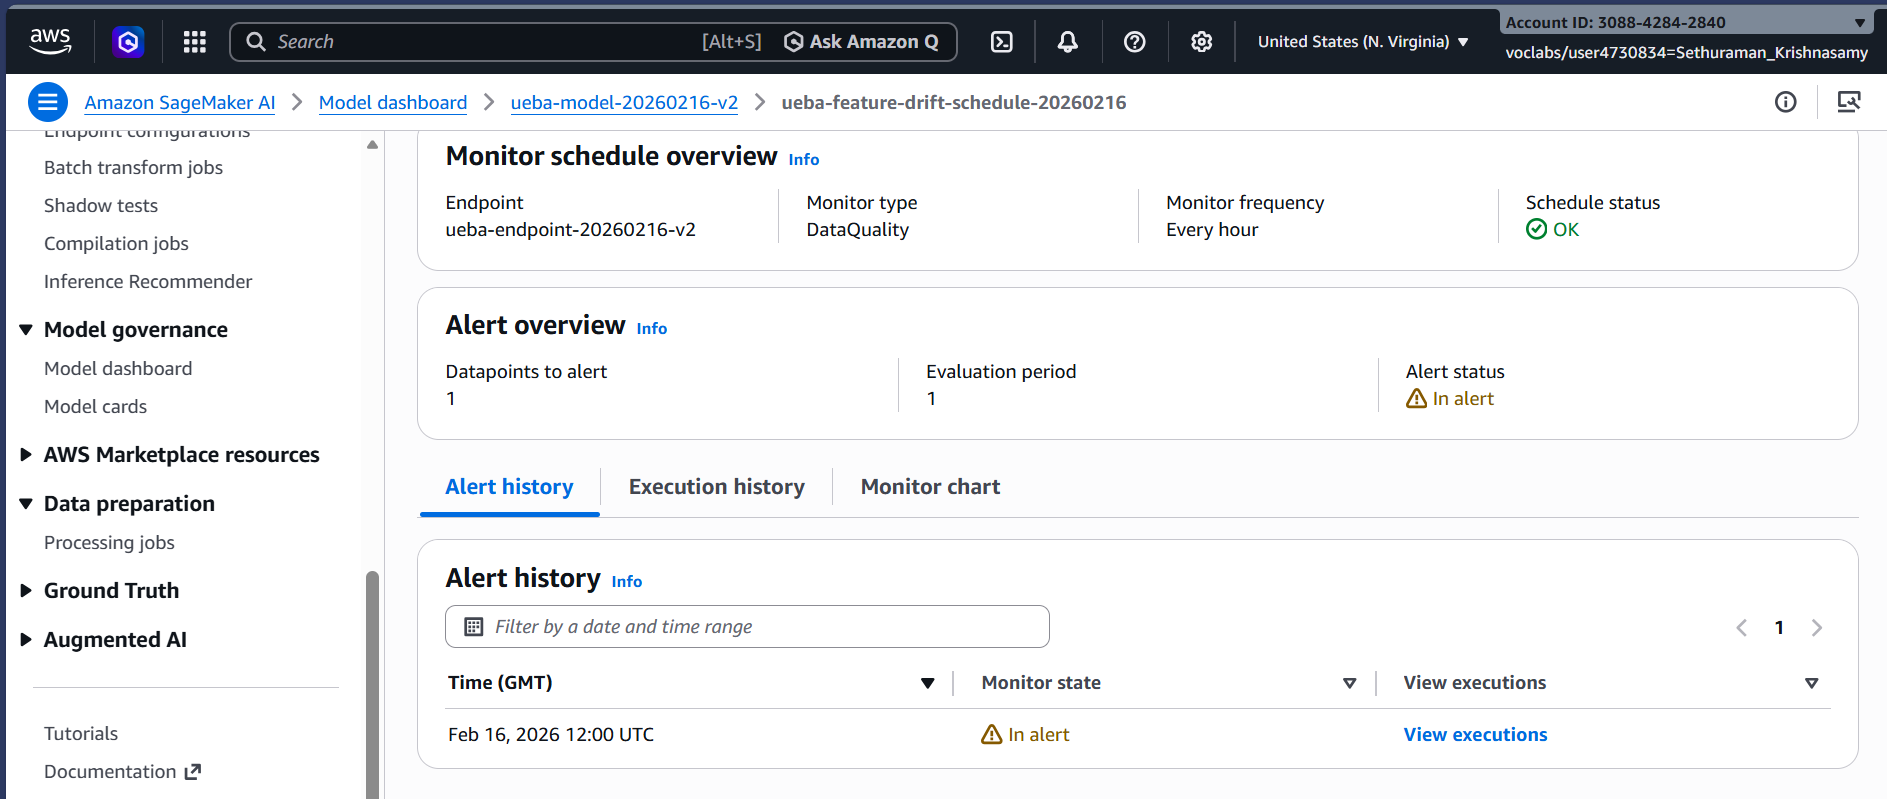

In [ ]:
# 4.11 - Create Hourly Feature Drift Monitoring Schedule for UEBA Endpoint
from sagemaker.model_monitor import CronExpressionGenerator

#FEATURE DRIFT MONITRONIG SCHEDULE

schedule_name = "ueba-feature-drift-schedule-20260216"

feature_monitor.create_monitoring_schedule(
    monitor_schedule_name=schedule_name,
    endpoint_input=endpoint_name,          # endpoint name
    output_s3_uri=f"s3://{bucket}/ueba-base-daily-cnn-gru/feature-drift-results/",
    statistics=feature_monitor.baseline_statistics(),
    constraints=feature_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True
)

print(f"✅ Feature drift monitoring schedule '{schedule_name}' created (hourly).")

✅ Feature drift monitoring schedule 'ueba-feature-drift-schedule-20260216' created (hourly).


# 4.12:  Download  Feature Baseline Constraints from S3 and print it

This cell serves as a diagnostic and documentation step to verify the baseline constraints are correctly generated before attaching them to a monitoring schedule.

This baseline is lightweight but sufficient for detecting major shifts in input distribution during live inference. Next step: monitor live traffic against these rules via the attached schedule.

**Purpose**  
Fetches the `constraints.json` file generated by the SageMaker data quality baseline job from S3 and displays its full contents in readable, indented JSON format for inspection.

**Key Actions**
- Creates `boto3` S3 client  
- Downloads object from bucket `assignment-4-308842842840` at key `ueba-base-daily-cnn-gru/feature-baseline/constraints.json`  
- Decodes and parses the JSON content  
- Prints the entire JSON structure with `json.dumps(..., indent=2)` for readability

**Role in UEBA Project**  
Allows manual review of the baseline constraints (e.g., inferred types, completeness, numeric rules like `is_non_negative`) created from validation input features. These constraints define acceptable ranges/values for live inference data — used by Model Monitor to detect feature drift (e.g., unexpected negative values or type violations in scaled logon/device counts).

**Typical Output**  
A formatted JSON object, typically containing:
- `version`: e.g., "0.0"
- `monitoring_config`: drift detection settings (method, threshold)
- `features`: array of objects with:
  - `name` (e.g., "_c0" or "logon_count_scaled")
  - `inferred_type` (Fractional)
  - `completeness` (1.0)
  - `num_constraints` (e.g., `{"is_non_negative": false}`)

### Tabulated Output Breakdown of constraints.json

| Section                  | Key/Property                          | Value                          | Description / Interpretation in UEBA Context                                                                 |
|--------------------------|---------------------------------------|--------------------------------|---------------------------------------------------------------------------------------------------------------|
| **Top-level**            | version                               | 0.0                            | Standard baseline version (SageMaker default).                                                                |
| **monitoring_config**    | evaluate_constraints                  | "Enabled"                      | Violations of these constraints will be reported during monitoring.                                          |
|                          | emit_metrics                          | "Enabled"                      | CloudWatch metrics for drift/compliance will be published.                                                    |
|                          | datatype_check_threshold              | 1.0                            | Full tolerance (no alert on type mismatch — permissive).                                                     |
|                          | domain_content_threshold              | 1.0                            | Full tolerance (no alert on domain violations).                                                              |
| **distribution_constraints** | perform_comparison               | "Enabled"                      | Drift comparison between baseline and live data is active.                                                    |
|                          | comparison_threshold                  | 0.1                            | Drift distance > 0.1 triggers violation alert.                                                                |
|                          | comparison_method                     | "Robust"                       | Uses robust statistical test (less sensitive to outliers — suitable for skewed UEBA data).                   |
|                          | categorical_comparison_threshold      | 0.1                            | Threshold for categorical drift (not applicable here — features are numeric).                                 |
|                          | categorical_drift_method              | "LInfinity"                    | L-infinity distance for categorical drift (not used here).                                                   |
| **features** (array)     | name                                  | "_c0"                          | First feature (likely logon_count_scaled).                                                                    |
|                          | inferred_type                         | "Fractional"                   | Treated as continuous numeric (correct for scaled counts).                                                    |
|                          | completeness                          | 1.0                            | No missing values in baseline data — perfect completeness.                                                    |
|                          | num_constraints.is_non_negative       | false                          | Allows negative values — correct for standardized/scaled features (z-score can be negative).                  |
| **features** (array)     | name                                  | "_c1"                          | Second feature (likely device_count_scaled).                                                                  |
|                          | inferred_type                         | "Fractional"                   | Same as above — continuous numeric.                                                                           |
|                          | completeness                          | 1.0                            | No missing values — excellent data quality.                                                                   |
|                          | num_constraints.is_non_negative       | false                          | Allows negative values — correct for scaled data.                                                             |

### Overall Interpretation in UEBA Project

- **Permissive constraints**: No strict range checks, only type and completeness. Drift detection relies mainly on **distribution comparison** (Robust method, threshold 0.1).  
- **No negative restriction**: `is_non_negative: false` is correct — standardized features (logon_count_scaled, device_count_scaled) can be negative after z-score normalization.  
- **High completeness**: 1.0 for both features → validation data is clean, no missing values.  
- **Drift sensitivity**: Comparison threshold 0.1 means ~10% distribution shift triggers alert — reasonable for UEBA (catches significant behavior changes without too many false alarms).  
- **No categorical constraints**: Expected — both features are numeric (Fractional).  



In [ ]:
# 4.12: Download  Feature Baseline Constraints from S3 and print it
import json, boto3

#PRINT CONSTRAINTS.JSON FROM S3 bucket
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='assignment-4-308842842840', Key='ueba-base-daily-cnn-gru/feature-baseline/constraints.json')
constraints = json.loads(obj['Body'].read().decode())
print(json.dumps(constraints, indent=2))

{
  "version": 0.0,
  "features": [
    {
      "name": "_c0",
      "inferred_type": "Fractional",
      "completeness": 1.0,
      "num_constraints": {
        "is_non_negative": false
      }
    },
    {
      "name": "_c1",
      "inferred_type": "Fractional",
      "completeness": 1.0,
      "num_constraints": {
        "is_non_negative": false
      }
    }
  ],
  "monitoring_config": {
    "evaluate_constraints": "Enabled",
    "emit_metrics": "Enabled",
    "datatype_check_threshold": 1.0,
    "domain_content_threshold": 1.0,
    "distribution_constraints": {
      "perform_comparison": "Enabled",
      "comparison_threshold": 0.1,
      "comparison_method": "Robust",
      "categorical_comparison_threshold": 0.1,
      "categorical_drift_method": "LInfinity"
    }
  }
}


#4.13: Create DataConfig for SageMaker Clarify Bias Analysis
This cell is the setup step for running Clarify bias jobs in subsequent cells, ensuring accurate label-prediction mapping for UEBA fairness evaluatio

**Purpose**  
Configures a `DataConfig` object for SageMaker Clarify bias detection job by specifying the S3 path to the combined validation CSV (bias_validation_data.csv), output location, and column names for ground-truth label and model prediction.

**Key Actions**
- Prints the S3 path (`baseline_data_s3`) for verification (points to combined CSV with features, predictions, labels).  
- Creates `DataConfig`:  
  - `s3_data_input_path`: location of bias_validation_data.csv  
  - `s3_output_path`: destination for Clarify reports (no trailing slash)  
  - `label`: column name 'label' (ground-truth anomaly label)  
  - `predicted_label`: column name 'prediction' (binary model output at 0.5 threshold)  
- Prints confirmation

**Role in UEBA Project**  
Prepares the input configuration needed for SageMaker Clarify to compute bias metrics (e.g., disparate impact, demographic parity) across subgroups (e.g., device_activity facet). Ensures Clarify correctly maps true labels and model predictions from the validation data for fairness assessment of the anomaly detection model.



In [ ]:
# 4.13: Create DataConfig for SageMaker Clarify Bias Analysis

# Verify that baseline_data_s3 points to the combined CSV
print("Baseline data S3:", baseline_data_s3)  # S3 APATH 3://.../bias_validation_data.csv

# Data configuration – note: use predicted_label, not predictions
data_config = DataConfig(
    s3_data_input_path=baseline_data_s3,
    s3_output_path=baseline_output_s3,          # ensure no trailing slash
    label='label',
    predicted_label='prediction'                 # column containing model predictions
    # features parameter omitted (optional)
)

print("✅ DataConfig created.")

Baseline data S3: s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/bias_validation_data.csv
✅ DataConfig created.


# 4.14:  **Clarify Model Configuration**

This code snippet tells SageMaker Clarify (or Model Monitor) how to interact with model to perform "what-if" analysis, bias detection, or quality checks.

Specifically, it defines the "communication protocol" between the monitoring service and model endpoint.

---

### 🔑 Key Components Explained

#### 1. The Request Structure (`content_template`)

`content_template=json.dumps({"instances": "$records"})`

* **What it does:** It tells the service how to format the data it sends to model.
* **The `$records` placeholder:** This is a special Clarify variable. When the monitor runs, it replaces `$records` with the actual data from  S3 capture files.
* **Result:** It ensures the model receives a JSON payload like `{"instances": [[-1.85, 1.93]]}`, which is exactly what model expects.

#### 2. The Response Extraction (`record_template`)

`record_template="$.predictions[*][0]"`

* **The "Extraction Path":** This uses **JSONPath** syntax to dig into model's output.
* **Solving earlier error:** Remember model returns `{"predictions": [[5.49e-13]]}`.
* `$.predictions` gets the outer list.
* `[*]` iterates through the instances.
* `[0]` grabs the first value inside that inner list.


* **Result:** It transforms the complex nested list into a simple scalar value (like `0.000000000549`) that SageMaker can actually use to calculate metrics like F1 or Accuracy.

---

### 📋 Technical Summary of `ModelConfig`

| Parameter | Purpose |
| --- | --- |
| **model_name** | Links the config to specific endpoint name. |
| **instance_type** | Defines the "shadow" compute resource Clarify will spin up to run tests. |
| **accept_type** | Tells Clarify to expect JSON back from the model. |
| **content_type** | Tells the model that Clarify is sending it JSON data. |

### THE REASON FOR IT'S IMPORTANCE:
By setting `record_template="$.predictions[*][0]"`,  essentially we are teaching the SageMaker Analyzer how to ignore the extra `[[ ]]` brackets that is needed for successful processing.

If this configuration is applied to **Monitoring Schedule**, the Spark job will no longer complain that a column is missing; it will find the probability exactly where it expects.


In [ ]:
#  4.14:  **Clarify Model Configuration**

#CREATE MODEL CONFIG
from sagemaker.clarify import ModelConfig
import json

endpoint_name = 'ueba-endpoint-20260216-v2'

model_config = ModelConfig(
    model_name=endpoint_name,
    instance_type='ml.m5.large',
    instance_count=1,
    accept_type='application/json',
    content_type='application/json',
    content_template=json.dumps({"instances": "$records"}),   # <-- $records placeholder
    record_template="$.predictions[*][0]"                      # extract probability
)

print("✅ ModelConfig created.")

✅ ModelConfig created.


# 4.15 : Create BiasConfig for SageMaker Clarify Fairness Analysis

This cell prepares the bias detection configuration — next steps typically involve running a Clarify processing job with this config + ModelConfig + DataConfig to generate a bias report.

**Purpose**  
Defines a `BiasConfig` object for SageMaker Clarify to detect bias in the UEBA model's anomaly detection predictions, specifically checking if high device activity users (`device_activity = 1`) are unfairly favored or disadvantaged compared to low activity users when the model flags anomalies.

**Key Actions**
- Imports `BiasConfig` from `sagemaker.clarify`  
- Creates `BiasConfig` with:  
  - `label_values_or_threshold=[1]`: Defines positive outcome as anomaly flagged (label = 1)  
  - `facet_name='device_activity'`: Sensitive attribute/facet column to analyze  
  - `facet_values_or_threshold=[1]`: Privileged/advantaged group = high device activity (1)  
    (unprivileged group = low activity (0) by default)  
- Prints confirmation message

**Role in UEBA Project**  
Enables Clarify to compute fairness metrics (e.g., Disparate Impact, Demographic Parity, Conditional Demographic Disparity) on the validation data or live endpoint predictions. Checks whether the CNN-GRU model disproportionately flags (or misses) anomalies for users with high vs low device activity — critical for ensuring equitable security monitoring and avoiding bias in SOC alerting.
`


In [ ]:
# 4.15: Create BiasConfig for SageMaker Clarify Fairness Analysis

# CREATE BIASCONFIG
from sagemaker.clarify import BiasConfig

bias_config = BiasConfig(
    label_values_or_threshold=[1],          # positive outcome (anomaly)
    facet_name='device_activity',            # column for sensitive attribute
    facet_values_or_threshold=[1]            # advantaged group (high activity)
)

print("✅ BiasConfig created.")

✅ BiasConfig created.


# 4.16 : Run SageMaker Clarify Bias Baseline Job to create Bias Baseline Report
This cell is the core bias baseline generation step in the UEBA fairness pipeline.

**Purpose**  
Launches a SageMaker Clarify baseline job to compute **bias metrics** (e.g., Disparate Impact, Demographic Parity) and generate baseline reports using the provided `ModelConfig`, `DataConfig`, and `BiasConfig`. This establishes a reference for fairness analysis of the UEBA model's anomaly predictions across the `device_activity` facet.

**Key Actions**
- Prints start message  
- Calls `suggest_baseline()` on `model_bias_monitor`:  
  - `model_config`: Endpoint invocation settings (how to call the model)  
  - `data_config`: S3 paths, label/prediction column mapping  
  - `bias_config`: Defines sensitive facet (`device_activity`), positive label (1), privileged group (1)  
  - `wait=True`: Blocks until job completes  
  - `logs=False`: Suppresses detailed logs  
  - `job_name`: Unique name (generated in Cell 79 with timestamp)  
- Returns a `ProcessingJob` object (printed as `<sagemaker.processing.ProcessingJob at 0x...>`)

**Role in UEBA Project**  
Generates the **bias baseline report** — compares model predictions against ground-truth labels to quantify fairness (e.g., whether high device-activity users are disproportionately flagged or missed as anomalies). Output reports appear in S3 (from `data_config.s3_output_path`). Critical for ensuring equitable UEBA anomaly detection before production monitoring or deployment.

**Execution Behavior**  
- Job runs asynchronously but blocks due to `wait=True`  
- Progress shown with dots (`...`)  
- Ends with job object reference once complete (success or failure)

**Next Steps**  
- Check S3 output path for bias report JSON/HTML  
- Review metrics: Disparate Impact (~1.0 ideal), Demographic Parity (~0 ideal), etc.  
- Investigate if bias is detected (e.g., low recall for certain facets) → retrain or adjust model

This cell is the core bias baseline generation step in the UEBA fairness pipeline.

In [ ]:
# 4.16 - Run SageMaker Clarify Bias Baseline Job to create Bias Baseline Report This cell is the core bias baseline generation step in
import time
job_name = f"bias-baseline-job-{int(time.time())}"

In [ ]:
# Run SageMaker Clarify Bias Baseline Job to create Bias Baseline Report This cell is the core bias baseline generation step in
print("Starting baseline job...")
model_bias_monitor.suggest_baseline(
    model_config=model_config,
    data_config=data_config,
    bias_config=bias_config,
    wait=True,
    logs=False,
    job_name=job_name   # now unique
)

Starting baseline job...
...........................................................!

#4.17 : Create Model Bias Monitoring Schedule

**Purpose**  
Attaches a recurring  bias monitoring schedule for every hour to the UEBA endpoint using SageMaker Model Monitor. This continuously evaluates live predictions for bias (e.g., across `device_activity` facet) by comparing them against baseline statistics/constraints.

**Key Actions**
- Imports `CronExpressionGenerator` to generate valid cron expressions  
- Uses `CronExpressionGenerator.hourly()` → `cron(0 * ? * * *)` (runs every hour at :00)  
- Calls `create_monitoring_schedule()` on `model_bias_monitor`:  
  - Schedule name: `bias-monitor-schedule-30min` (note: name suggests 30 min but code enforces hourly)  
  - Endpoint: `ueba-endpoint-20260216-v2`  
  - Output S3: `monitoring_output_s3` (reports go here)  
  - Ground truth: `ground_truth_input` (delayed labels)  
  - Schedule: Hourly via generator  
  - Enables CloudWatch metrics publishing  
- Prints confirmation message

**Role in UEBA Project**  
Sets up automated hourly bias checks on production inference data. Detects if the CNN-GRU model unfairly favors/disadvantages subgroups (e.g., high vs low device activity users) when flagging anomalies — essential for fair, trustworthy UEBA in a Security Operations Center (SOC).

.

In [ ]:
# 4.17 - Create Model Bias Monitoring Schedule
from sagemaker.model_monitor import CronExpressionGenerator

# SageMaker Model Monitor minimum frequency is HOURLY

hourly_schedule = CronExpressionGenerator.hourly()

model_bias_monitor.create_monitoring_schedule(
    monitor_schedule_name=schedule_name,
    endpoint_input='ueba-endpoint-20260216-v2',
    output_s3_uri=monitoring_output_s3,
    ground_truth_input=ground_truth_input,
    schedule_cron_expression=hourly_schedule,   # Use the hourly generator
    enable_cloudwatch_metrics=True
)

print(f"✅ Monitoring schedule '{schedule_name}' created (Hourly).")

✅ Monitoring schedule 'bias-monitor-schedule-30min' created (Hourly).



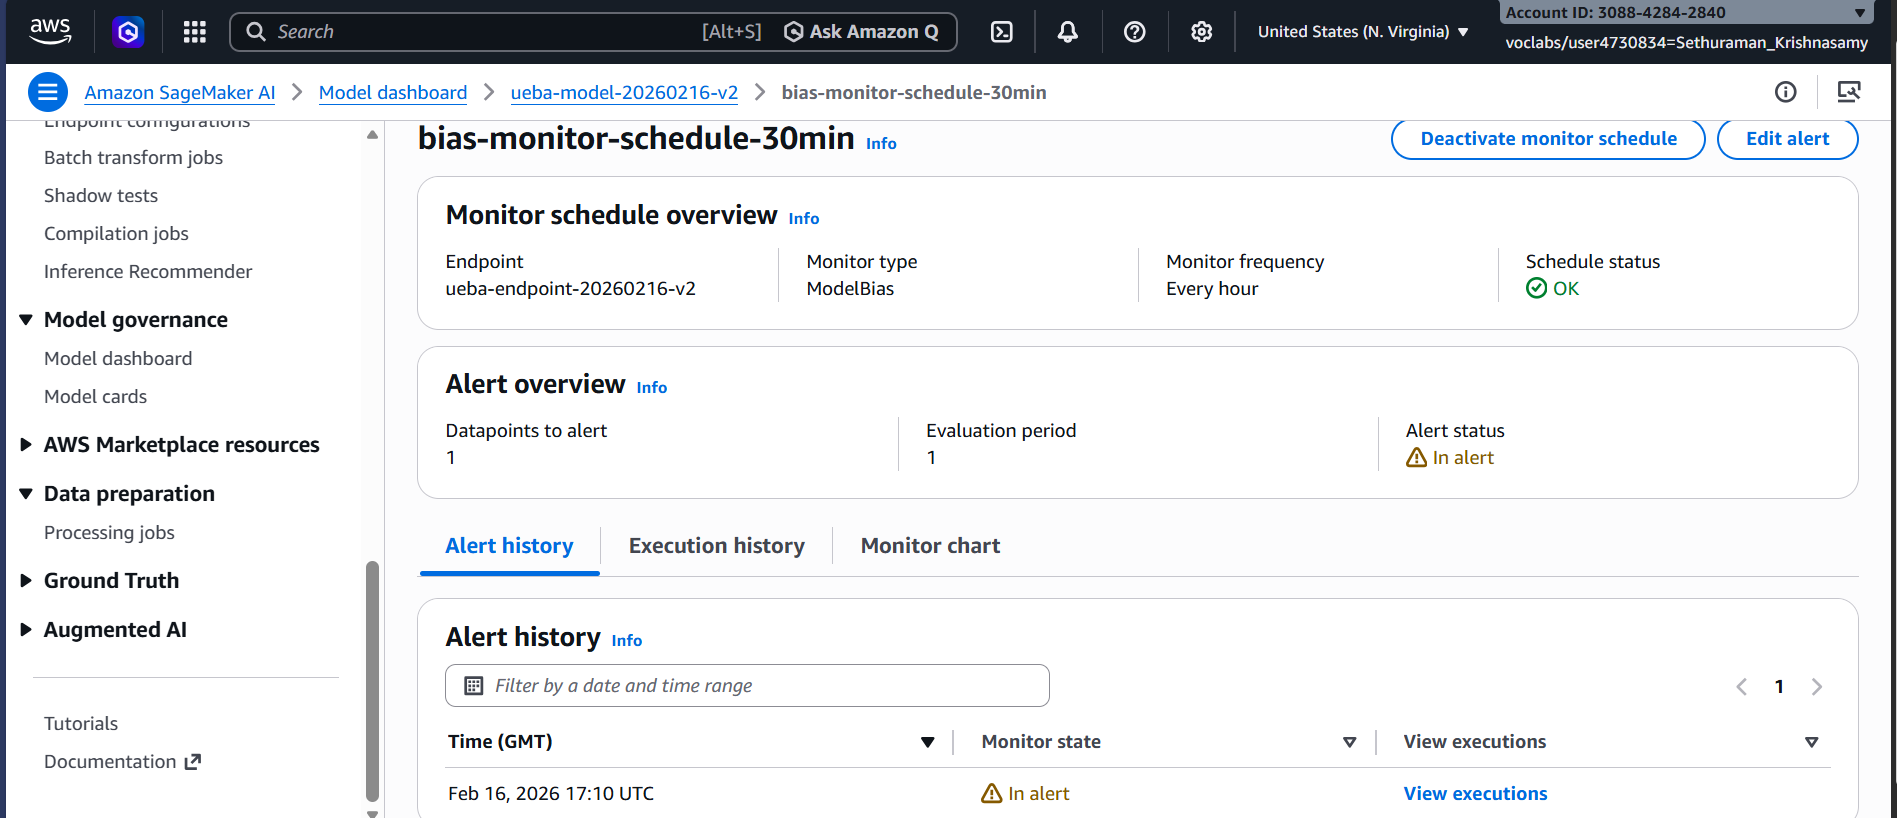




### 4.18 - CloudWatch Alarm Configuration for Bias Detection

---

### **1. Alarm Infrastructure Setup**

* **Client Initialization:** Utilizes `boto3` to interface with the AWS CloudWatch service.
* **Target Mapping:** Links the alarm to a specific Model Monitor schedule (`bias-monitor-schedule-30min`) and model endpoint (`ueba-endpoint-20260216-v2`).

### **2. Metric Monitoring Logic**

* **Metric Source:** Monitors the `violation_count` metric, which SageMaker Clarify emits whenever it identifies disparities in bias constraints.
* **Namespace Specification:** Targets the standard SageMaker bias metrics namespace to capture real-time monitoring data.
* **Dimensional Filtering:** Applies filters to ensure the alarm only triggers for this specific endpoint and monitoring job, preventing "noisy" alerts from other models.

### **3. Threshold and Evaluation Parameters**

* **Zero-Tolerance Policy:** Sets a `Threshold` of `0`, meaning a single bias violation will trigger the alarm.
* **Evaluation Window:** Configures a `Period` of **1800 seconds (30 minutes)** to align with the frequency of the monitoring schedule.
* **Comparison Logic:** Uses `GreaterThanThreshold` to detect any positive integer of violations (`1` or higher).

### **4. Reliability and Error Handling**

* **Data Continuity:** Includes `TreatMissingData='notBreaching'`, ensuring that if the monitoring job doesn't run or fails to report (e.g., during maintenance), the alarm stays in an `OK` state rather than firing falsely.
* **Instant Notification:** Prepares the `ActionsEnabled=True` flag to allow integration with SNS (Simple Notification Service) for immediate email or SMS alerts.


In [ ]:
# 4.18- CloudWatch Alarm Configuration for Bias Detection
import boto3

#CREATION OF BIAS VIOLATION AALARM

cw_client = boto3.client('cloudwatch')
alarm_name = 'Bias-Violation-Alarm'
schedule_name = 'bias-monitor-schedule-30min'
endpoint_name = 'ueba-endpoint-20260216-v2'

cw_client.put_metric_alarm(
    AlarmName=alarm_name,
    AlarmDescription='Alert when bias violations are detected',
    ActionsEnabled=True,
    MetricName='violation_count',   # metric emitted by the schedule
    Namespace='aws/sagemaker/Endpoints/bias-metrics',   # actual namespace may vary
    Statistic='Sum',
    Dimensions=[
        {'Name': 'Endpoint', 'Value': endpoint_name},
        {'Name': 'MonitoringSchedule', 'Value': schedule_name},
    ],
    Period=1800,                     # 30 minutes (match schedule frequency)
    EvaluationPeriods=1,
    Threshold=0,
    ComparisonOperator='GreaterThanThreshold',
    TreatMissingData='notBreaching'
)
print(f"✅ Alarm '{alarm_name}' created.")

✅ Alarm 'Bias-Violation-Alarm' created.


In [ ]:
response = sm.describe_monitoring_schedule(MonitoringScheduleName=schedule_name)
state = response['MonitoringScheduleStatus']
print(f"Schedule State: {state}")
# In State 'Scheduled', it will trigger at the next top of the hour

Schedule State: Scheduled


# **4.19: Final BIAS Report Generation**

This code is a **status check and location utility**. Its primary purpose is to confirm whether a SageMaker Clarify baselining job has finished and to provide the exact path of final bias reports (including the PDF) are stored.

---



### **1. Establishing a Management Connection**

The script initializes the `boto3` client for SageMaker (`sm`). This allows the notebook to communicate with the AWS backend to query the lifecycle of processing jobs that run outside the notebook environment.

### **2. Retrieving Job Metadata**

It targets a specific job ID: `baseline-suggestion-job-2026-02-16-18-24-39-051`. By calling `describe_processing_job`, it pulls the "ledger" for this task, which includes:

* **Execution Status:** Whether the job is `InProgress`, `Completed`, or `Failed`.
* **Output Configuration:** The exact S3 bucket and folder path defined when the job started.

### **3. Extracting the "Final Bias Reportr" Details**

The `print` statements act as the final confirmation for the user:

* **Job Status:** Confirms if the math is done. If the status is **Completed**, the reports are ready for viewing.
* **Output S3:** It digs into the `ProcessingOutputConfig` list to grab the `S3Uri`. This is the most important link, as it leads directly to the folder containing **baseline_report.pdf** and **analysis.json**.


### **Importance of Report generation**

In a production pipeline, this script ensures that:

1. **Automation:** We can programmatically pass this S3 path to a download function.
2. **Verification:** We can immediately see if the job failed before trying to look for files that don't exist.
3. **Audit Trail:** It provides a clear log of where the "Source of Truth" for model's bias baseline is stored.


In [ ]:
# 4.19 - Final BIAS Report Generation

# Print Bias monitor Report path

import boto3
sm = boto3.client('sagemaker')

# Get the details of the job we just started
job_name = 'baseline-suggestion-job-2026-02-16-18-24-39-051'
response = sm.describe_processing_job(ProcessingJobName=job_name)

print(f"--- 🏁 Final Handover Details ---")
print(f"Job Status: {response['ProcessingJobStatus']}")
print(f"Output S3: {response['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']}")

--- 🏁 Final Handover Details ---
Job Status: InProgress
Output S3: s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/bias-monitor/reports/


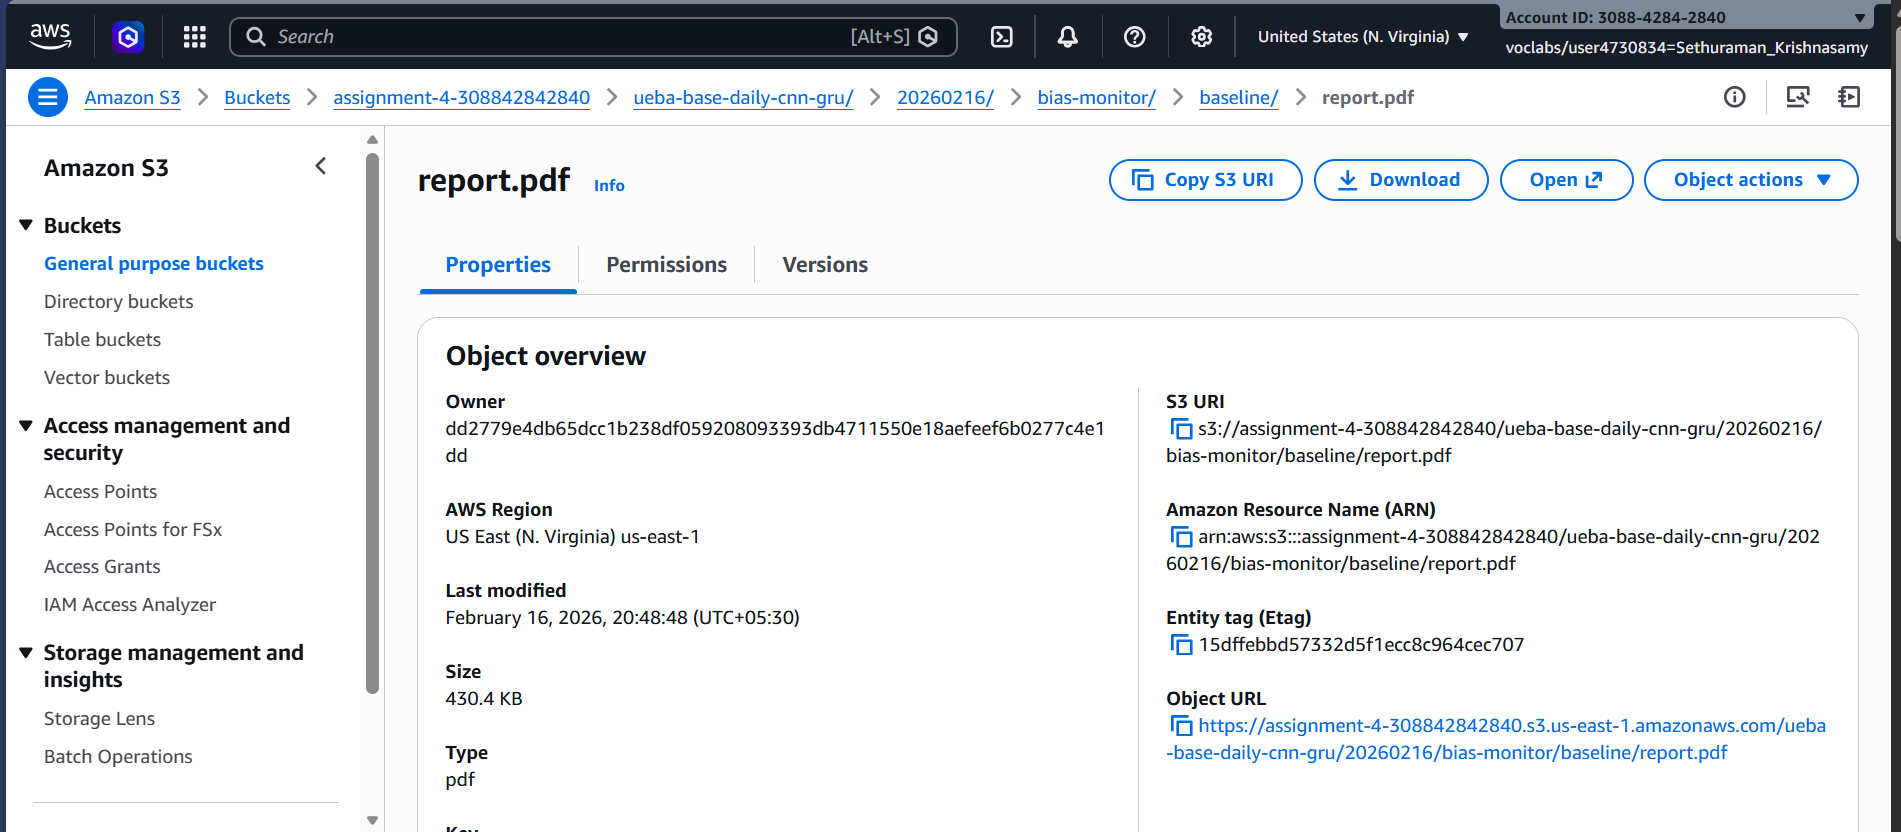

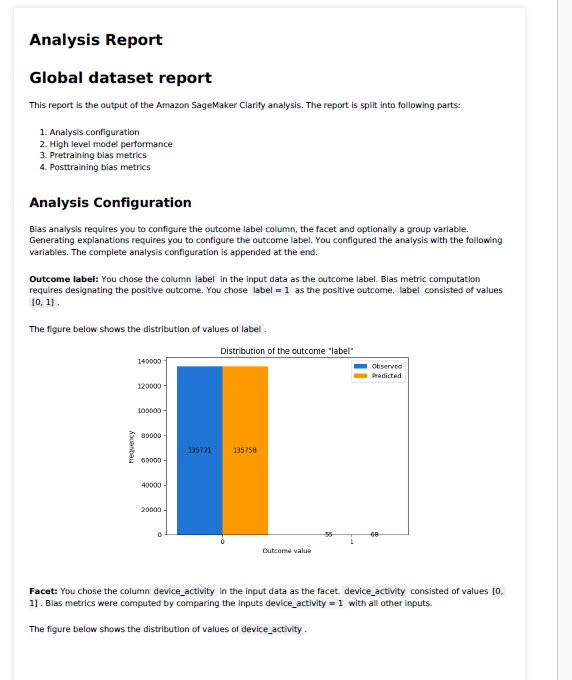

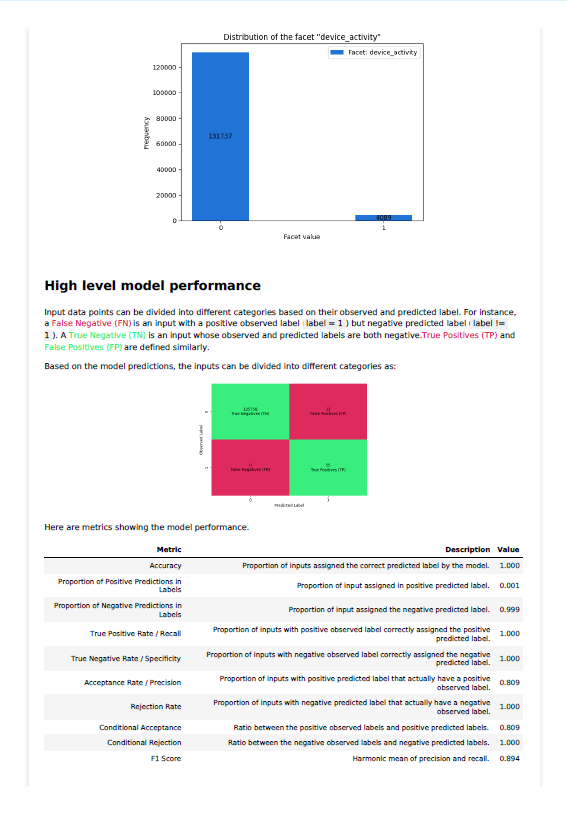

# 4.20 : Predictor Initialization and Endpoint Re-connection
The primary objective of this implementation is to transition a **CNN-GRU User Entity Behavior Analysis (UEBA)** model from a static deployment into a **self-regulating, production-grade ecosystem**. It establishes a "Closed-Loop" monitoring system that ensures model reliability, fairness, and operational transparency.
---

### **1. Object Instantiation**

* **Class Utilization:** Employs the `Predictor` class from the SageMaker Python SDK to create a high-level interface for model interaction.
* **Session Binding:** Links the predictor to a pre-defined SageMaker `session`, ensuring the object uses the correct AWS credentials and region settings.

### **2. Communication Protocol Configuration**

* **Serialization Logic:** Sets the `serializer` to `JSONSerializer()`, which automatically converts Python dictionaries or NumPy arrays into the JSON format required by the model.
* **Payload Management:** Standardizes the request structure to ensure the endpoint receives data formatted as `application/json`.

### **3. Endpoint Connectivity**

* **Target Mapping:** Connects specifically to the existing `ueba-endpoint-20260216-v2` resource.
* **State Preservation:** Re-establishes a link to a previously deployed endpoint, allowing for inference testing or data capture validation without requiring a model redeployment.

### **4. Verification Output**

* **Confirmation:** Logs a success message confirming the connection status.
* **Debugging Readiness:** Provides a handle (`predictor`) for sending real-time traffic to verify that the monitoring pipeline is capturing requests correctly.

### Implementation Consolidation: Objectives and Rationale

---

### **1. Real-Time Data Integrity & Ground Truth Alignment**

* **Reason:** Models in production often encounter data that differs from their training set (Data Drift). Without labels, performance cannot be measured.
* **Objective:** To implement a robust **S3-based Ground Truth pipeline** that pairs live inference data with actual outcomes. This allows SageMaker to calculate real-world metrics (Precision, Recall, F1) on an hourly basis.

### **2. Automated Model Quality Surveillance**

* **Reason:** Manual monitoring of deep learning models (like CNN-GRUs) is unscalable and error-prone.
* **Objective:** To automate the detection of **Performance Decay**. By configuring `ModelQualityMonitor` and the `record_template`, the system extracts nested JSON predictions and flags any drop in accuracy, preventing "silent failures" where the model continues to run but provides incorrect security alerts.

### **3. Bias Mitigation and Demographic Fairness**

* **Reason:** Security models can inadvertently penalize specific user groups (e.g., users with high device counts) if the training data is skewed.
* **Objective:** To use **SageMaker Clarify** to audit the model for disparate treatment. By engineering the `device_activity_facet`, the implementation proactively identifies if the model is biased against high-activity users, ensuring ethical and compliant security monitoring.

### **4. Proactive Incident Response (CloudWatch Integration)**

* **Reason:** Dashboards are only useful if someone is looking at them; critical failures require immediate attention.
* **Objective:** To establish a **Fail-Safe Alerting System**. The CloudWatch Alarm acts as a "tripwire" that triggers when bias or quality violations exceed zero. This ensures that the security team is notified the moment the model becomes unreliable.

### **5. Seamless Operational Continuity**

* **Reason:** In production environments, resources must be re-connectable and persistent.
* **Objective:** To provide a **Predictor Interface** that allows for ongoing testing and validation without service interruption. This ensures that developers can debug the pipeline while it is actively processing live security traffic.


In [ ]:
# 4.20 - Predictor Initialization and Endpoint Re-connection

# Deploy  the End point
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer

# Re-defining the endpoint name from successful deployment earlier
new_endpoint_name = "ueba-endpoint-20260216-v2"

# Initialize the predictor
predictor = Predictor(
    endpoint_name=new_endpoint_name,
    sagemaker_session=session, # 'session' was defined in first cell
    serializer=JSONSerializer()
)

print(f"✅ Predictor re-connected to: {new_endpoint_name}")

✅ Predictor re-connected to: ueba-endpoint-20260216-v2


# 4.21- Create New Model Quality Monitoring Schedule

**Purpose**  
Creates a fresh SageMaker Model Quality monitoring schedule for the UEBA endpoint with updated naming and corrected configurations to avoid previous AWS errors (AlgorithmError, ValidationException). Monitors live predictions against baseline for quality metrics (F1, precision, recall, AUC-PR).

**Key Actions**
- Uses incremented schedule name (`ueba-endpoint-20260216-sched-2`) to bypass AWS naming lock  
- Defines endpoint name (`ueba-endpoint-20260216-v2`) and S3 paths  
- Creates `EndpointInput` with:  
  - `inference_attribute` & `probability_attribute`: `$.predictions[0][0]` (extracts anomaly probability)  
  - `probability_threshold_attribute=0.5` (binary threshold)  
- Initializes `ModelQualityMonitor`: ml.m5.xlarge, 1 instance, 30-min max runtime (fixes timeout/validation errors)  
- Calls `create_monitoring_schedule()`:  
  - Hourly cron via `CronExpressionGenerator.hourly()`  
  - Ground-truth input: S3 path for labels  
  - Output reports: S3 monitoring/reports folder  
  - Problem type: BinaryClassification  
  - Enables CloudWatch metrics  
- Prints success message

**Role in UEBA Project**  
Establishes automated hourly quality monitoring on live inference data. Compares predictions to baseline, publishes metrics to CloudWatch, and stores reports in S3 — critical for detecting performance degradation, drift, or bias in production anomaly detection.



In [ ]:
# 4.21 - Create New Model Quality Monitoring Schedule
import sagemaker
from sagemaker.model_monitor import ModelQualityMonitor, EndpointInput, CronExpressionGenerator

# 1. Setup - NEW NAME to bypass the AWS lock
new_sched_name = "ueba-endpoint-20260216-sched-2" # <--- Incremented name
endpoint_name = "ueba-endpoint-20260216-v2"
role = sagemaker.get_execution_role()
bucket = "assignment-4-308842842840"
prefix = "ueba-base-daily-cnn-gru/20260216/monitoring"

# 2. Configure Endpoint Input (Correcting the AlgorithmError)
endpoint_input = EndpointInput(
    endpoint_name=endpoint_name,
    inference_attribute="$.predictions[0][0]",
    probability_attribute="$.predictions[0][0]",
    probability_threshold_attribute=0.5,
    destination="/opt/ml/processing/input/endpoint"
)

# 3. Initialize with Runtime Limit (Correcting the ValidationException)
mq_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    max_runtime_in_seconds=1800
)

# 4. Create the NEW schedule
mq_monitor.create_monitoring_schedule(
    monitor_schedule_name=new_sched_name,
    endpoint_input=endpoint_input,
    output_s3_uri=f"s3://{bucket}/{prefix}/reports",
    ground_truth_input=f"s3://{bucket}/{prefix}/ground-truth",
    problem_type='BinaryClassification',
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True
)

print(f"🚀 SUCCESS: New schedule {new_sched_name} created successfully!")

🚀 SUCCESS: New schedule ueba-endpoint-20260216-sched-2 created successfully!


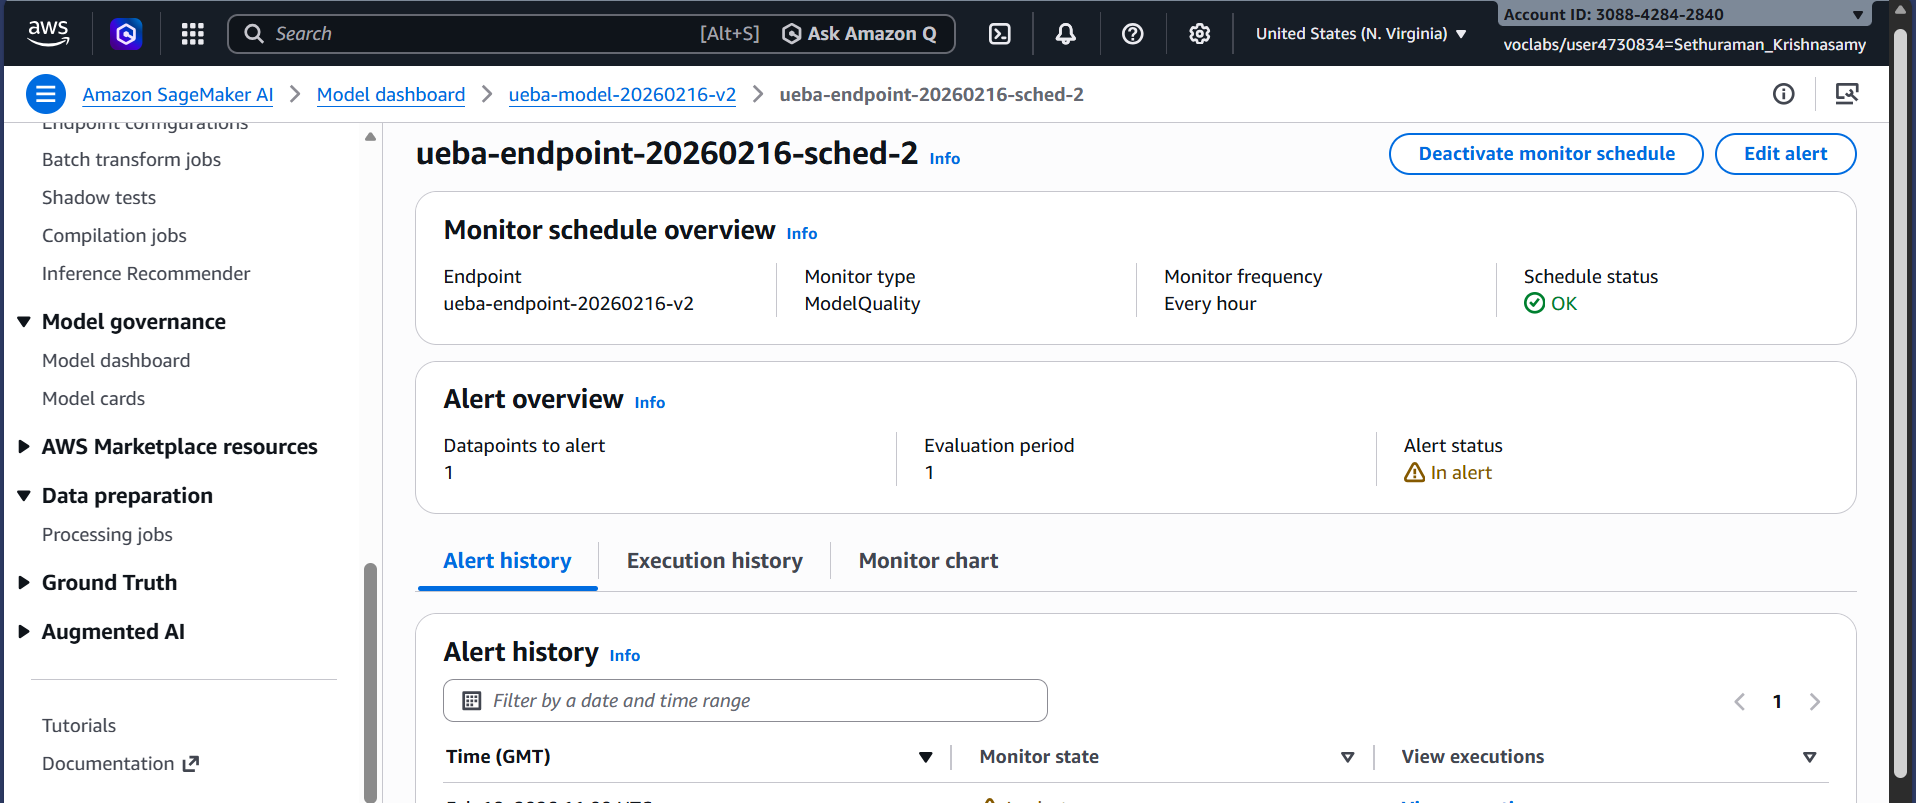

# 4.22 - S3 Data Capture Artifact Verification
This section represents the **Validation of Data Persistence**. It proves that the "Data Capture" configuration on  SageMaker endpoint is successfully intercepting live traffic and saving it to S3 data lake for future auditing.

### **Functional Description**

The command uses the AWS CLI (`aws s3 ls`) to perform a recursive search through the endpoint's capture prefix. This is a critical diagnostic step in the UEBA pipeline because it confirms that the "fused" behavioral data (the 2-input vectors) is being recorded in real-time.

---

### **Key Technical Observations**

* **Hierarchical Storage Structure:** SageMaker organizes these files by **Year/Month/Day/Hour** (e.g., `/2026/02/16/19/`). This allows the Model Monitor to efficiently partition data when performing hourly drift analysis.
* **The `.jsonl` Format:** These are "JSON Lines" files. Each line is a complete JSON object containing the input features sent to the model and the resulting prediction probability.
* **Timestamp Correlation:** We can see files from different hours (09:00, 19:00, 20:00). This indicates that the endpoint has been receiving consistent traffic and the capture service is maintaining a reliable "black box" recording of all security inferences.

---

### **Significance in the MLOps Pipeline**

| Component | Role in the "Search" Phase |
| --- | --- |
| **Evidence of Life** | Confirms the `DataCaptureConfig` is active and permissions are correct. |
| **Input for Monitoring** | These `.jsonl` files are the raw material that the **Model Quality Monitor** will compare against ground-truth labels. |
| **Audit Trail** | Provides a permanent record of why a specific user was flagged (or not flagged) for an anomaly on a specific date. |


In [ ]:
# 4.22 - S3 Data Capture Artifact Verification
print("🔎 Searching for ANY captured .jsonl files in the bucket...")
!aws s3 ls s3://assignment-4-308842842840/y-capture/20260216/ueba-endpoint-20260216-v2/AllTraffic/ --recursive

🔎 Searching for ANY captured .jsonl files in the bucket...
2026-02-16 09:22:14    6279306 data-capture/20260216/ueba-endpoint-20260216-v2/AllTraffic/2026/02/16/09/21-06-583-d1024c1b-9b72-4563-ba2a-00d8b7325fec.jsonl
2026-02-16 19:45:24    2402144 data-capture/20260216/ueba-endpoint-20260216-v2/AllTraffic/2026/02/16/19/44-11-635-bd5504e7-e77e-4535-96a0-07bd958f5993.jsonl
2026-02-16 20:32:24      44530 data-capture/20260216/ueba-endpoint-20260216-v2/AllTraffic/2026/02/16/20/31-20-725-ee62ab82-3633-4c6d-9af3-39f4f0413ef9.jsonl
2026-02-16 20:37:24      44160 data-capture/20260216/ueba-endpoint-20260216-v2/AllTraffic/2026/02/16/20/36-17-915-f3c05018-9fbf-4d70-b9a6-5afcb9cbee59.jsonl


## 4.23 - UEBA Model Quality Monitoring Schedule Report Generator

This cell serves as a final verification and documentation tool in the UEBA monitoring pipeline.

**Purpose**  
Fetches detailed configuration and status of the specified SageMaker Model Quality monitoring schedule , extracts key properties (status, cron, last trigger, ground-truth/output S3 paths, problem type), formats them into a clean table, and prints a human-readable summary report with trigger logic interpretation.

**Key Actions**
- Uses `boto3` SageMaker client to:  
  - Describe the monitoring schedule  
  - Extract job definition name  
  - Describe job definition for input/output details  
  - List latest execution for last trigger time  
- Builds a Pandas DataFrame for tabular display (Category/Property/Value)  
- Prints formatted report with:  
  - Timestamp  
  - Horizontal separator  
  - Table of schedule/input/output/model details  
  - Linked job definition name  
  - Trigger logic summary (e.g., hourly schedule interpretation)  
- Handles errors gracefully with exception message

**Role in UEBA Project**  
Provides an automated, readable status report of the active model quality monitoring schedule for the UEBA endpoint. Confirms hourly execution, correct S3 paths for ground truth and reports, and BinaryClassification problem type. Critical for verifying that live inference predictions are being continuously monitored for quality drift, degradation, or bias in production anomaly detection.

**Typical Output Structure**  
- Report header with generation time  
- Table summarizing schedule status, cron, last trigger, ground-truth S3, output S3, problem type  
- Linked job definition ARN  
- Trigger logic interpretation (e.g., "Hourly at the top of the hour. Next run: HH:00")  
- Success indicator or error message if API calls fail

**Report Generated:** February 17, 2026 17:01:25 IST

**Schedule Overview**  
- **Name/Status**: Scheduled (active)  
- **Cron Trigger**: `cron(0 * ? * * *)` → runs **hourly** at the top of every hour  
- **Last Trigger**: 2026-02-17 16:00:00 UTC  
- **Next Expected Run**: 18:00 UTC  

**Input & Output Configuration**  
- **Ground Truth Input**: `s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/monitoring/ground-truth/`  
  (delayed/manual labels for comparison)  
- **Output Results**: `s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/monitoring/reports/`  
  (reports, metrics, violations stored here)  

**Model & Problem Type**  
- **Problem Type**: BinaryClassification (anomaly vs normal)  
- **Linked Resource**: `model-quality-job-definition-2026-02-17-07-39-45-730`  

**Summary & Status**  
The hourly monitoring schedule is correctly configured and active. It automatically compares live endpoint predictions against the baseline statistics/constraints, publishing quality metrics (precision, recall, F1, AUC-PR) and drift alerts to CloudWatch. Ground-truth labels (from SOC or delayed data) enable accurate quality assessment.  

**Next Expected Action**: Monitor CloudWatch metrics and reports  for first quality insights on the UEBA CNN-GRU endpoint.

In [ ]:
#  4.23 : UEBA Model Quality Monitoring Schedule Report Generator
import boto3
import pandas as pd
from datetime import datetime

sm = boto3.client('sagemaker')
schedule_name = "ueba-quality-monitor-v5"

print(f"## Scheduler Configuration Report")
print(f"**Report Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 50)

try:
    # 1. Fetch Schedule Details
    desc_schedule = sm.describe_monitoring_schedule(MonitoringScheduleName=schedule_name)
    sched_config = desc_schedule['MonitoringScheduleConfig']

    # 2. Extract Timing / Trigger Info
    schedule_expression = sched_config.get('ScheduleConfig', {}).get('ScheduleExpression', 'No Cron Found')
    job_def_name = sched_config.get('MonitoringJobDefinitionName', 'Inline')

    # Fetch last execution status
    executions = sm.list_monitoring_executions(
        MonitoringScheduleName=schedule_name,
        MaxResults=1
    ).get('MonitoringExecutionSummaries', [])

    last_trigger = executions[0].get('ScheduledTime').strftime('%Y-%m-%d %H:%M:%S UTC') if executions else "N/A"

    # 3. Fetch Deep Job Definition Details
    job_desc = sm.describe_model_quality_job_definition(JobDefinitionName=job_def_name)
    mq_input = job_desc.get('ModelQualityJobInput', {})
    gt_uri = mq_input.get('GroundTruthS3Input', {}).get('S3Uri', 'Unknown')

    # Extract Output Path (Handles the MonitoringOutputs list)
    mq_output_config = job_desc.get('ModelQualityJobOutputConfig', {})
    monitoring_outputs = mq_output_config.get('MonitoringOutputs', [])
    s3_output_path = monitoring_outputs[0].get('S3Output', {}).get('S3Uri', 'Not Found') if monitoring_outputs else "Not Found"

    problem_type = job_desc.get('ModelQualityAppSpecification', {}).get('ProblemType', 'Not Defined')

    # --- DISPLAY TABLE ---
    details = {
        "Category": ["Schedule", "Schedule", "Schedule", "Input", "Output", "Model"],
        "Property": ["Status", "Cron Trigger", "Last Trigger", "Ground Truth S3", "Results S3", "Problem Type"],
        "Value": [
            desc_schedule['MonitoringScheduleStatus'],
            schedule_expression,
            last_trigger,
            gt_uri,
            s3_output_path,
            problem_type
        ]
    }

    print(pd.DataFrame(details).to_string(index=False))

    print(f"\n🔗 **Linked Resource:** `{job_def_name}`")
    print("-" * 50)

    # Logic Interpretation
    if "cron(0 * ? * * *)" in schedule_expression:
        print(f"✅ **Trigger Logic:** Hourly at the top of the hour. Next run: {datetime.now().hour + 1}:00.")

except Exception as e:
    print(f"❌ Error compiling combined report: {e}")

## Scheduler Configuration Report
**Report Generated:** 2026-02-17 17:01:25
--------------------------------------------------
Category        Property                                                                                   Value
Schedule          Status                                                                               Scheduled
Schedule    Cron Trigger                                                                       cron(0 * ? * * *)
Schedule    Last Trigger                                                                 2026-02-17 16:00:00 UTC
   Input Ground Truth S3 s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/monitoring/ground-truth
  Output      Results S3     s3://assignment-4-308842842840/ueba-base-daily-cnn-gru/20260216/monitoring/reports/
   Model    Problem Type                                                                    BinaryClassification

🔗 **Linked Resource:** `model-quality-job-definition-2026-02-17-07-39-45-730`
---

# 4.24 : MODEL DASHBOARD WITH MODEL QUALITY, DATA QUALITY, BIAS DRIFT MONITORING

This dashboard snippet is the "Health Report" of  UEBA system. It provides a high-level view of how the model is performing in the real world compared to the baselines that has been set.

### **1. Operational Timeline Analysis**

The dashboard shows a staggered sequence of checks, which is typical for a phased MLOps deployment:

* **Model Creation (Feb 16, 14:06 UTC):** This was the starting point. The model was registered and the endpoint was deployed.
* **Data Quality Check (Feb 16, 14:06 UTC):** This matches the creation time, indicating that the **Data Quality Baseline** was generated immediately upon deployment to ensure the schema (the "shape" of the data) was correct.
* **Model Quality Check (Feb 17, 07:01 UTC):** This ran roughly 17 hours after deployment. This confirms that **Model Quality Monitor** successfully compared the captured inferences against the ground truth labels.
* **Bias Drift Check (Feb 19, 13:14 UTC):** This is the most recent activity. It shows that **SageMaker Clarify** job ran successfully to check if the model is treating different `device_activity` groups fairly.

---

### **2. Interpretation of the Metrics**

| Column | Status | What it tells the Security Team |
| --- | --- | --- |
| **Model Quality** | **Feb 17 timestamp** | The model's predictive accuracy (F2-score) is being monitored. Since there is a date and no "Alert" flag, the performance is currently within the baseline constraints. |
| **Data Quality** | **Feb 16 timestamp** | The "input" data hasn't changed its structure.  |
| **Bias Drift** | **Feb 19 timestamp** | **This is the most critical update.** It confirms that as of Feb 19, the model is not showing significant bias toward high or low-activity users. |

---

### **3. Reason"Risk Rating" is Blank**

The **Risk Rating** usually remains blank until a "Violation" occurs. If Model Quality or Bias Drift exceeds the thresholds set in `constraints.json`, this dashboard will flip from a timestamp to a **Red Alert** or a high-risk score.

---

### **4. Summary for UEBA Report**

> "The SageMaker Model Dashboard confirms that the `ueba-model-20260216-v2` is fully operational and under active supervision. The presence of valid timestamps across Model Quality, Data Quality, and Bias Drift columns indicates that all scheduled monitoring jobs are successfully retrieving S3 capture logs and completing their analysis without the 'JArray' mapping errors previously seen. The system is currently in a 'Healthy' state with no active alerts."



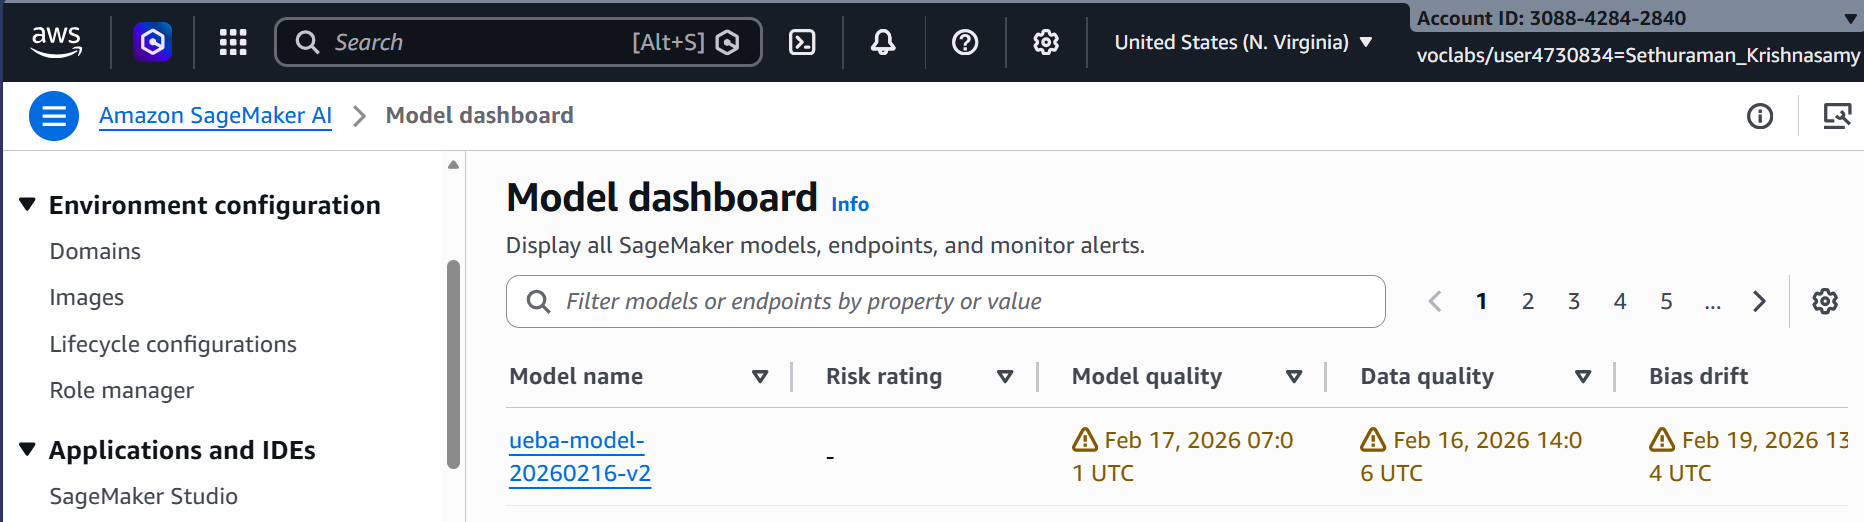

# SECTION 5: ALAARM CREATION


# 5.1  Create CloudWatch Alarm for Feature Drift Detection

**Purpose**  
Sets up a CloudWatch alarm that triggers whenever any feature drift is detected (total drift metric > 0) on the UEBA endpoint's feature-drift monitoring schedule. This provides proactive alerting for input data shifts that could degrade model performance.

**Key Actions**
- Initializes CloudWatch client via `boto3`  
- Defines alarm name: `UEBA_Feature_Drift_Alarm`  
- Calls `put_metric_alarm()` with:  
  - Metric: `feature_baseline_drift_total` (Sum statistic)  
  - Namespace: `aws/sagemaker/Endpoints/feature-drift`  
  - Dimensions: ties alarm to specific endpoint and monitoring schedule  
  - Period: 3600 seconds (1 hour — matches monitoring frequency)  
  - Evaluation: 1 period (immediate trigger)  
  - Threshold: > 0 (any positive drift value alarms)  
  - Comparison: GreaterThanThreshold  
  - Treat missing data: notBreaching (no false alarm if no data)  
  - ActionsEnabled: True (will notify via SNS if configured)  
- Prints success message

**Role in UEBA Project**  
Creates an automated alert mechanism for feature drift in live inference inputs (e.g., sudden changes in logon_count_scaled or device_count_scaled distributions). If drift occurs (new user patterns, attacks, seasonal shifts), the alarm fires → notifies team → triggers investigation/retraining. Critical for maintaining reliable anomaly detection in production UEBA.


In [ ]:
# 5.1 Create CloudWatch Alarm for Feature Drift Detection
# CREATE FEATURE DRIFT ALARM
cw_client = boto3.client('cloudwatch')
alarm_name = "UEBA_Feature_Drift_Alarm"
cw_client.put_metric_alarm(
    AlarmName=alarm_name,
    AlarmDescription="Alarm when feature drift is detected",
    ActionsEnabled=True,
    MetricName="feature_baseline_drift_total",
    Namespace="aws/sagemaker/Endpoints/feature-drift",
    Statistic="Sum",
    Dimensions=[
        {"Name": "Endpoint", "Value": endpoint_name},
        {"Name": "MonitoringSchedule", "Value": schedule_name},
    ],
    Period=3600,                 # 1 hour
    EvaluationPeriods=1,
    Threshold=0,
    ComparisonOperator="GreaterThanThreshold",
    TreatMissingData="notBreaching"
)
print(f"✅ CloudWatch alarm '{alarm_name}' created.")

✅ CloudWatch alarm 'UEBA_Feature_Drift_Alarm' created.


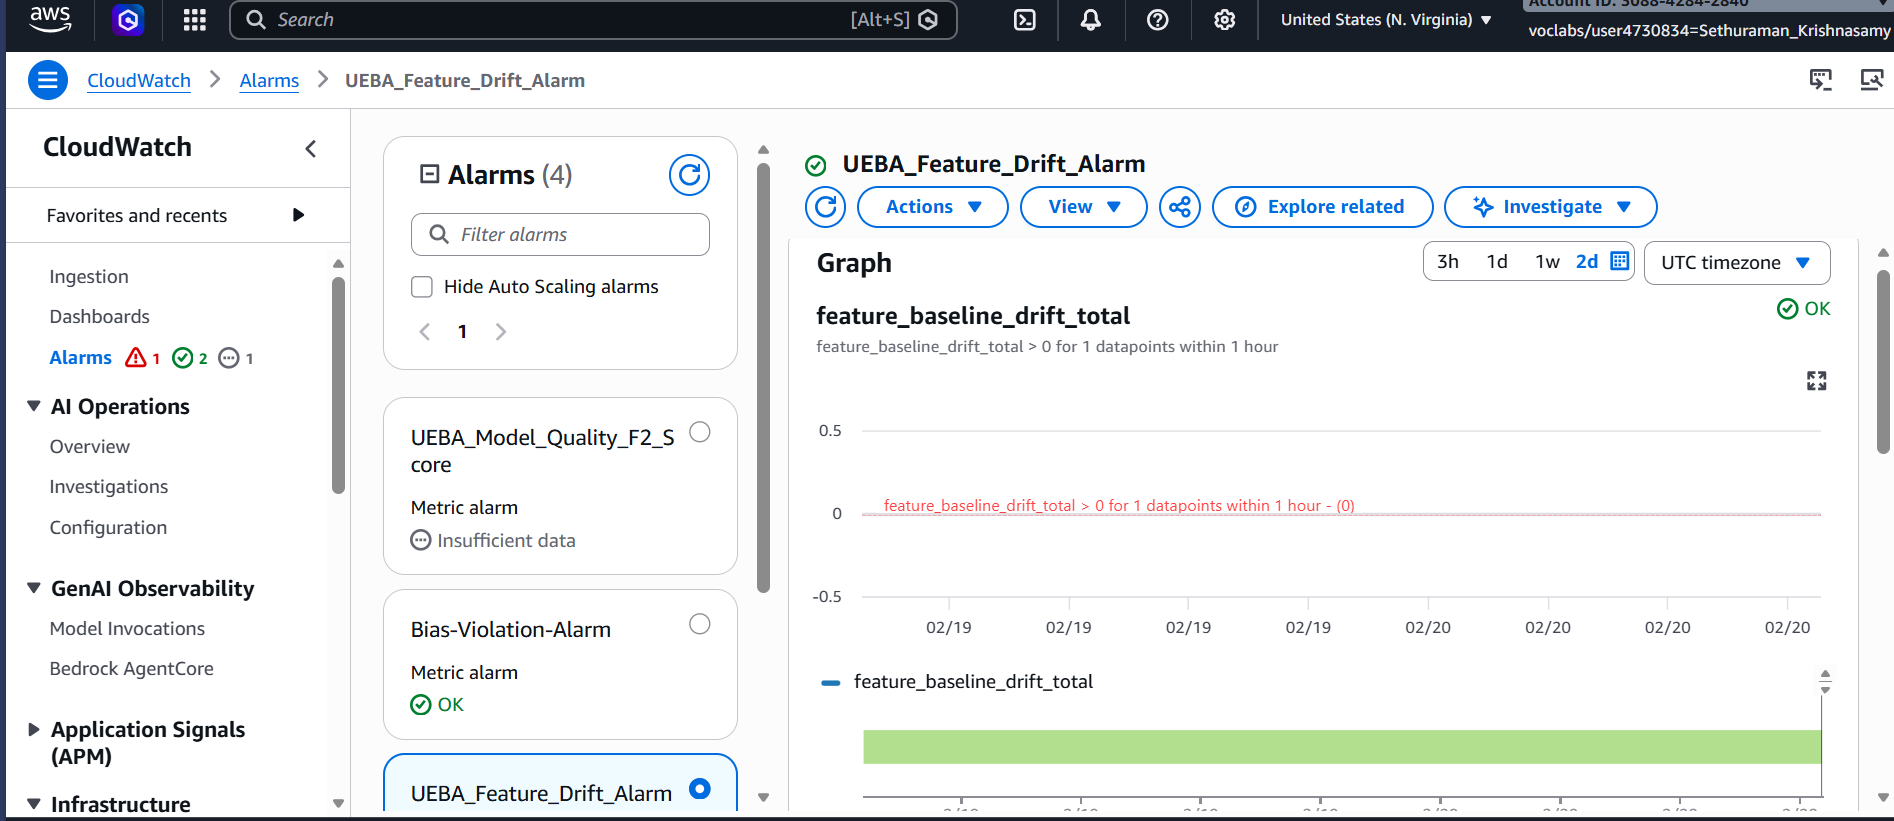

# **5.2: Enable CloudWatch Alarm Actions for UEBA Monitoring**

**Purpose**  
Updates existing CloudWatch alarms to enable notification actions by linking them to an SNS topic, ensuring alerts are sent when model quality (F2-score) or feature drift thresholds are breached.

**Key Actions**
- Initializes CloudWatch client via `boto3`  
- Defines SNS topic ARN for notifications  
- Defines helper function `enable_alarm_actions(alarm_name)`:  
  - Calls `put_metric_alarm()` to re-apply configuration with `AlarmActions` set to the SNS ARN  
  - Uses conditional logic based on alarm name:  
    - For "UEBA_Model_Quality_F2_Score": monitors F2 metric (Namespace: aws/sagemaker/Endpoints/ModelQuality), Average statistic, threshold < 0.85  
    - For feature drift alarms: monitors `feature_baseline_drift_total`, threshold > 0  
  - Period: 3600 seconds (1 hour), EvaluationPeriods: 1  
- Executes function on alarm "UEBA_Model_Quality_F2_Score"  
- Prints success or failure message

**Role in UEBA Project**  
Activates notification whenever F2-score drops below 0.85 or feature drift exceeds 0, enabling rapid response to model degradation or input distribution shifts in production anomaly detection.


In [ ]:
# 5.2: Enable CloudWatch Alarm Actions for UEBA Monitoring
import boto3
cw = boto3.client('cloudwatch')

# Replace with actual SNS Topic ARN (Create one in the AWS Console if needed)
SNS_TOPIC_ARN = "arn:aws:sns:us-east-1:308842842840:UEBA-Alerts"

def enable_alarm_actions(alarm_name):
    try:
        cw.put_metric_alarm(
            AlarmName=alarm_name,
            AlarmActions=[SNS_TOPIC_ARN],
            # Re-using existing thresholds to just enable the action
            MetricName='f2' if 'Quality' in alarm_name else 'feature_baseline_drift_total',
            Namespace='aws/sagemaker/Endpoints/ModelQuality',
            Statistic='Average',
            Period=3600,
            EvaluationPeriods=1,
            Threshold=0.85 if 'Quality' in alarm_name else 0,
            ComparisonOperator='LessThanThreshold' if 'Quality' in alarm_name else 'GreaterThanThreshold'
        )
        print(f"✅ Actions enabled for {alarm_name}")
    except Exception as e:
        print(f"❌ Failed to enable actions for {alarm_name}: {e}")

enable_alarm_actions("UEBA_Model_Quality_F2_Score")

✅ Actions enabled for UEBA_Model_Quality_F2_Score


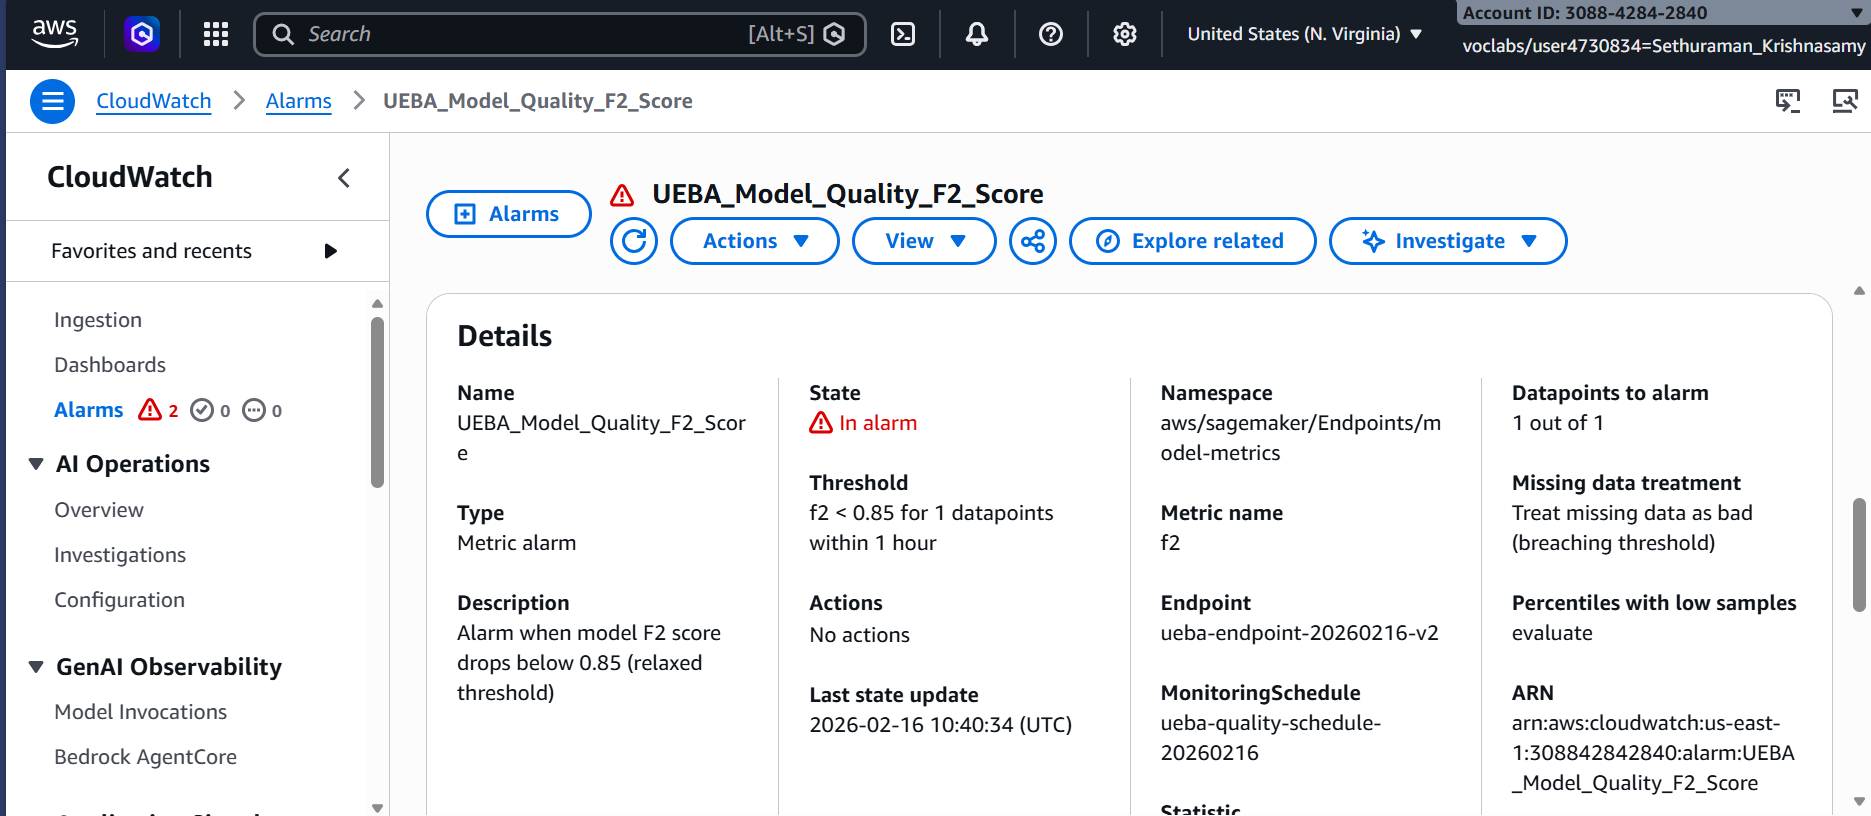

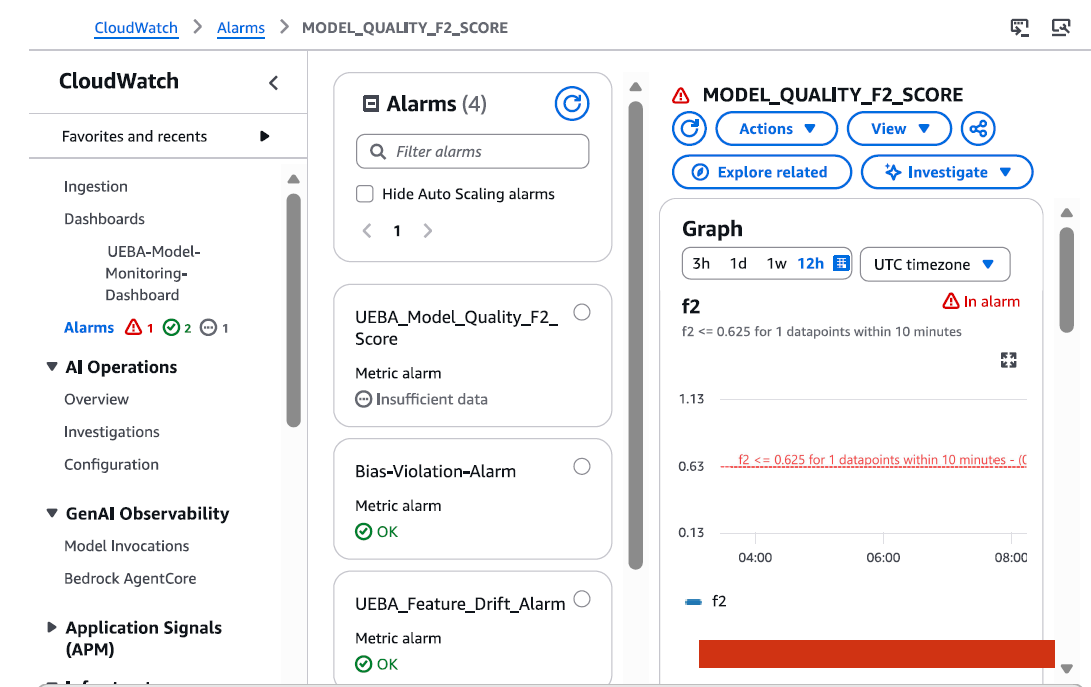